# COMS 4995_002 Deep Learning Assignment 1
Due on Monday, Oct 9, 11:59pm

This assignment can be done in groups of at most 3 students. Everyone must submit on Courseworks individually.

Write down the UNIs of your group (if applicable)

Member 1: Name, UNI

Member 2: Name, UNI

Member 3: Name, UNI

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc
import glob
import sys
# you shouldn't need to make any more imports

In [60]:
class NeuralNetwork(object):
    """
    Abstraction of neural network.
    Stores parameters, activations, cached values. 
    Provides necessary functions for training and prediction. 
    """
    def __init__(self, layer_dimensions, drop_prob=0.0, reg_lambda=0.0):
        """
        Initializes the weights and biases for each layer
        :param layer_dimensions: (list) number of nodes in each layer
        :param drop_prob: drop probability for dropout layers. Only required in part 2 of the assignment
        :param reg_lambda: regularization parameter. Only required in part 2 of the assignment
        """
        np.random.seed(1)
        
        self.parameters = {}
        self.num_layers =len(layer_dimensions)
        self.drop_prob = drop_prob
        self.reg_lambda = reg_lambda
        self.train_cost = []
        self.validation_cost = []
        self.train_accuracy = []
        self.validation_accuracy = []
        
        # init parameters
        self.parameters = self.init_parameters(layer_dimensions)
        
    def init_parameters(self, layer_dimensions):
        
        parameters = {}
        
        for i in range(len(layer_dimensions) - 1):
            forwoard_unit_number = layer_dimensions[i+1]
            backwoard_unit_number = layer_dimensions[i]
            parameters['W'+str(i+1)] = 0.01 * np.random.randn(forwoard_unit_number, backwoard_unit_number)
            parameters['b'+str(i+1)] = np.zeros((forwoard_unit_number,1))
            
        return parameters

    def affineForward(self, A, W, b):
        """
        Forward pass for the affine layer.
        :param A: input matrix, shape (L, S), where L is the number of hidden units in the previous layer and S is
        the number of samples
        :returns: the affine product WA + b, along with the cache required for the backward pass
        """
        return np.dot(W, A) + b

    def activationForward(self, A, activation="relu"):
        """
        Common interface to access all activation functions.
        :param A: input to the activation function
        :param prob: activation funciton to apply to A. Just "relu" for this assignment.
        :returns: activation(A)
        """ 
        return relu(A)

    def relu(self, X):
        return np.maximum(0,X)
            
    def dropout(self, A, prob):
        """
        :param A: 
        :param prob: drop prob
        :returns: tuple (A, M) 
            WHERE
            A is matrix after applying dropout
            M is dropout mask, used in the backward pass
        """
        M = np.random.rand(A.shape[0], A.shape[1])
        M = 1*(M >= prob)
        A = np.multiply(A, M)
        A = A / (1 - prob)

        return A, M

    
    def forwardPropagation(self, X):
        """
        Runs an input X through the neural network to compute activations
        for all layers. Returns the output computed at the last layer along
        with the cache required for backpropagation.
        :returns: (tuple) AL, cache
            WHERE 
            AL is activation of last layer
            cache is cached values for each layer that
                     are needed in further steps
        """
        cache = {}
        cache['A' + str(0)] = X
        
        for i in range(self.num_layers - 2):
            W = self.parameters['W' + str(i+1)]
            b = self.parameters['b' + str(i+1)]
            A = cache['A' + str(i)]
            Z = self.affineForward(A, W, b)
            A_next = self.relu(Z)
            cache['A' + str(i+1)] = A_next
            cache['Z' + str(i+1)] = Z
        
        W = self.parameters['W' + str(self.num_layers - 1)]
        b = self.parameters['b' + str(self.num_layers - 1)]
        Z = self.affineForward(cache['A' + str(self.num_layers - 2)], W, b)
        cache['Z' + str(self.num_layers - 1)] = Z
        AL = self.softmax(Z)

        return AL, cache
    
    def softmax(self, Z):
        K = Z - np.amax(Z, axis=0)
        K = np.exp(K)
        sum_ = np.sum(K,axis=0, keepdims=True)
        return K / sum_
    
    def costFunction(self, AL, y):
        """
        :param AL: Activation of last layer, shape (num_classes, S)
        :param y: labels, shape (S)
        :param alpha: regularization parameter
        :returns cost, dAL: A scalar denoting cost and the gradient of cost
        """
        # compute loss
#         dAL = np.zeros((AL.shape[0], AL.shape[1]))
        y_one_hot = np.zeros((AL.shape[0], AL.shape[1]))
        
        cost = 0
        for i in range(len(y)):
            cost += -np.log(AL[y[i], i]) / len(y)
            y_one_hot[y[i], i] = 1
        
#         cost /= len(y)
        if self.reg_lambda > 0:
            # add regularization
            pass
        
        dAL = AL - y_one_hot
    
        return cost, dAL

    def affineBackward(self, dA_prev, cache, layer_num):
        """
        Backward pass for the affine layer.
        :param dA_prev: gradient from the next layer.
        :param cache: cache returned in affineForward
        :returns dA: gradient on the input to this layer
                 dW: gradient on the weights
                 db: gradient on the bias
        """
        m = dA_prev.shape[1]
        A = cache['A' + str(layer_num-1)]
        W = self.parameters['W' + str(layer_num)]
        dZ = self.activationBackward(dA_prev, cache, layer_num)
        dW = 1 / m * np.dot(dZ, A.T)
        db = 1 / m * np.sum(dZ, axis = 1, keepdims = True)
        dA = np.dot(W.T, dZ)

        return dA, dW, db

    def activationBackward(self, dA, cache, layer_num, activation="relu"):
        """
        Interface to call backward on activation functions.
        In this case, it's just relu. 
        """
        dZ = dA * self.relu_derivative(cache['Z' + str(layer_num)])
        return dZ

        
    def relu_derivative(self, cached_x):
        dx = 1*(cached_x > 0)
        return dx

    def dropout_backward(self, dA, cache):

        return dA

    def backPropagation(self, dAL, AL, cache):
        """
        Run backpropagation to compute gradients on all paramters in the model
        :param dAL: gradient on the last layer of the network. Returned by the cost function.
        :param Y: labels
        :param cache: cached values during forwardprop
        :returns gradients: dW and db for each weight/bias
        """
        gradients = {}
        
        m = AL.shape[1]
        A = cache['A' + str(self.num_layers - 2)]
        W = self.parameters['W' + str(self.num_layers - 1)]
        dZ = dAL
        dW = 1 / m * np.dot(dZ, A.T)
        db = 1 / m * np.sum(dZ, axis = 1, keepdims = True)
        dA = np.dot(W.T, dZ)
        
        gradients['dW' + str(self.num_layers - 1)] = dW
        gradients['db' + str(self.num_layers - 1)] = db
        
        print('the dW' + str(self.num_layers - 1) + ' is' + str(np.sum(dW)/ (dW.shape[0] * dW.shape[1])))
#         print('the db' + str(self.num_layers - 1) + ' is' + str(np.sum(db)/ (db.shape[0] * db.shape[1])))
        
        for layer_num in range(self.num_layers - 2, 0, -1):
            dA, dW, db = self.affineBackward(dA, cache, layer_num)
            gradients['dW' + str(layer_num)] = dW
            gradients['db' + str(layer_num)] = db
            
            print('the dW' + str(layer_num) + ' is' + str(np.sum(dW)/ (dW.shape[0] * dW.shape[1])))
#             print('the db' + str(layer_num) + ' is' + str(np.sum(db)/ (db.shape[0] * db.shape[1])))
            
            if self.drop_prob > 0:
                #call dropout_backward
                pass
        
        if self.reg_lambda > 0:
            # add gradients from L2 regularization to each dW
            pass
            
        return gradients


    def updateParameters(self, gradients, alpha):
        """
        :param gradients: gradients for each weight/bias
        :param alpha: step size for gradient descent 
        """
        for i in range(self.num_layers - 1):
            W = self.parameters['W' + str(i+1)]
            b = self.parameters['b' + str(i+1)]
            
            dW = gradients['dW' + str(i+1)]
            db = gradients['db' + str(i+1)]
            
            print('the dW' + str(i+1) + ' is' + str(np.sum(dW) / (dW.shape[0] * dW.shape[1])))
#             print('the db' + str(i+1) + ' is' + str(np.sum(db)/ (db.shape[0] * db.shape[1])))


            W -= alpha * dW
            b -= alpha * db
            self.parameters['W' + str(i+1)] = W
            self.parameters['b' + str(i+1)] = b

    def train(self, X, y,X_validation, y_validation, iters=1000, alpha=0.1, batch_size=100, print_every=100):
        """
        :param X: input samples, each column is a sample
        :param y: labels for input samples, y.shape[0] must equal X.shape[1]
        :param iters: number of training iterations
        :param alpha: step size for gradient descent
        :param batch_size: number of samples in a minibatch
        :param print_every: no. of iterations to print debug info after
        """
        
        for i in range(0, iters):
            # get minibatch
            X_batch, y_batch = self.get_batch(X, y, batch_size)
            
            # forward prop
            AL, cache = self.forwardPropagation(X_batch)
            
            # compute loss
            cost, dAL = self.costFunction(AL, y_batch)
            
            # compute gradients
            gradients = self.backPropagation(dAL, AL, cache)
            
            # update weights and biases based on gradient
            self.updateParameters(gradients, alpha)
            
            if i % print_every == 0:
                # print cost, train and validation set accuracies
                train_y_predict = self.predict(X_batch)
                train_accuracy = np.sum((train_y_predict == y_batch) * 1) / len(y_batch)
                self.train_cost.append(cost)
                self.train_accuracy.append(train_accuracy)
                
                print('the training cost after %04d iteration is %8.6f:'%(i, cost))
                print('the training accuracy after %04d iteration is %8.2f:'%(i, train_accuracy))
                
                AL, _ = self.forwardPropagation(X_validation)
                validation_cost, _ = self.costFunction(AL, y_validation)
                validation_y_predict = self.predict(X_validation)
                validation_accuracy = np.sum((validation_y_predict == y_validation) * 1) / len(y_validation)
                self.validation_cost.append(validation_cost)
                self.validation_accuracy.append(validation_accuracy)
                print('the validation cost after %04d iteration is %8.6f:'%(i, validation_cost))
                print('the validation accuracy after %04d iteration is %8.2f:'%(i, validation_accuracy)) 
    
                            
    def predict(self, X):
        """
        Make predictions for each sample
        """
        AL,_ = self.forwardPropagation(X)
        y_pred = np.argmax(AL, axis=0)
        
        return y_pred

    def get_batch(self, X, y, batch_size):
        """
        Return minibatch of samples and labels
        
        :param X, y: samples and corresponding labels
        :parma batch_size: minibatch size
        :returns: (tuple) X_batch, y_batch
        """
        m = X.shape[1]
        start_index = np.random.randint(0, m - batch_size)
        X_batch = X[:, start_index:(start_index + batch_size)]
        y_batch = y[start_index:(start_index + batch_size)]

        return X_batch, y_batch

In [61]:
# try train, you can adjust your hyperparameter here, and plot the it on the next block
layer_dimensions = [X_train.shape[0], 64, 32, 10]  # including the input and output layers
NN = NeuralNetwork(layer_dimensions)
NN.train(X_train, y_train, X_validation, y_validation,iters=10000, alpha=0.01, batch_size=128, print_every=100)


the dW3 is-4.40457132572e-21
the dW2 is1.25738261009e-05
the dW1 is1.34540563278e-06
the dW1 is1.34540563278e-06
the dW2 is1.25738261009e-05
the dW3 is-4.40457132572e-21
the training cost after 0000 iteration is 2.302629:
the training accuracy after 0000 iteration is     0.10:
the validation cost after 0000 iteration is 2.302595:
the validation accuracy after 0000 iteration is     0.09:
the dW3 is5.42101086243e-21
the dW2 is-1.74022926375e-05
the dW1 is-9.49370367486e-07
the dW1 is-9.49370367486e-07
the dW2 is-1.74022926375e-05
the dW3 is5.42101086243e-21
the dW3 is-5.42101086243e-21
the dW2 is2.55032949485e-06
the dW1 is9.17788203813e-07
the dW1 is9.17788203813e-07
the dW2 is2.55032949485e-06
the dW3 is-5.42101086243e-21
the dW3 is2.71050543121e-21
the dW2 is2.97909818288e-06
the dW1 is1.81392674181e-07
the dW1 is1.81392674181e-07
the dW2 is2.97909818288e-06
the dW3 is2.71050543121e-21
the dW3 is-1.62630325873e-20
the dW2 is-3.87637015071e-08
the dW1 is7.91309747987e-07
the dW1 is7.91

the dW3 is-5.42101086243e-21
the dW3 is0.0
the dW2 is-6.87204403639e-06
the dW1 is-2.80969900684e-07
the dW1 is-2.80969900684e-07
the dW2 is-6.87204403639e-06
the dW3 is0.0
the dW3 is5.42101086243e-21
the dW2 is7.53752636115e-07
the dW1 is-4.77090238517e-07
the dW1 is-4.77090238517e-07
the dW2 is7.53752636115e-07
the dW3 is5.42101086243e-21
the dW3 is-1.08420217249e-20
the dW2 is1.91105366804e-05
the dW1 is1.71461082031e-06
the dW1 is1.71461082031e-06
the dW2 is1.91105366804e-05
the dW3 is-1.08420217249e-20
the dW3 is-1.08420217249e-20
the dW2 is1.32831170239e-05
the dW1 is1.10173902614e-06
the dW1 is1.10173902614e-06
the dW2 is1.32831170239e-05
the dW3 is-1.08420217249e-20
the dW3 is0.0
the dW2 is-2.05481606962e-05
the dW1 is-1.59279723013e-06
the dW1 is-1.59279723013e-06
the dW2 is-2.05481606962e-05
the dW3 is0.0
the dW3 is1.08420217249e-20
the dW2 is-2.06168967234e-05
the dW1 is8.14300195066e-08
the dW1 is8.14300195066e-08
the dW2 is-2.06168967234e-05
the dW3 is1.08420217249e-20
the

the dW1 is3.16707088896e-07
the dW2 is-8.31814653659e-06
the dW3 is2.71050543121e-21
the dW3 is-1.08420217249e-20
the dW2 is-8.22519268373e-06
the dW1 is2.9738285926e-07
the dW1 is2.9738285926e-07
the dW2 is-8.22519268373e-06
the dW3 is-1.08420217249e-20
the dW3 is-2.71050543121e-21
the dW2 is5.42333476671e-06
the dW1 is-7.83803973532e-08
the dW1 is-7.83803973532e-08
the dW2 is5.42333476671e-06
the dW3 is-2.71050543121e-21
the dW3 is-5.42101086243e-21
the dW2 is-2.18519521814e-06
the dW1 is-1.13459374272e-06
the dW1 is-1.13459374272e-06
the dW2 is-2.18519521814e-06
the dW3 is-5.42101086243e-21
the dW3 is8.13151629364e-21
the dW2 is-2.58934219348e-06
the dW1 is3.53508587612e-07
the dW1 is3.53508587612e-07
the dW2 is-2.58934219348e-06
the dW3 is8.13151629364e-21
the dW3 is1.08420217249e-20
the dW2 is-1.26739056694e-07
the dW1 is8.5346169991e-07
the dW1 is8.5346169991e-07
the dW2 is-1.26739056694e-07
the dW3 is1.08420217249e-20
the dW3 is2.16840434497e-20
the dW2 is-1.51484761737e-05
the 

the dW1 is-1.0499149095e-06
the dW1 is-1.0499149095e-06
the dW2 is-1.49310527771e-05
the dW3 is1.08420217249e-20
the dW3 is1.62630325873e-20
the dW2 is-2.87104150455e-05
the dW1 is-1.63554053035e-06
the dW1 is-1.63554053035e-06
the dW2 is-2.87104150455e-05
the dW3 is1.62630325873e-20
the dW3 is0.0
the dW2 is-1.02054031268e-05
the dW1 is-7.5259955619e-08
the dW1 is-7.5259955619e-08
the dW2 is-1.02054031268e-05
the dW3 is0.0
the dW3 is5.42101086243e-21
the dW2 is1.07366617109e-05
the dW1 is3.94238245919e-07
the dW1 is3.94238245919e-07
the dW2 is1.07366617109e-05
the dW3 is5.42101086243e-21
the dW3 is0.0
the dW2 is6.32243115523e-06
the dW1 is-1.59555601508e-07
the dW1 is-1.59555601508e-07
the dW2 is6.32243115523e-06
the dW3 is0.0
the dW3 is4.06575814682e-21
the dW2 is-2.57824665566e-05
the dW1 is-1.63976842826e-06
the dW1 is-1.63976842826e-06
the dW2 is-2.57824665566e-05
the dW3 is4.06575814682e-21
the dW3 is-3.38813178902e-21
the dW2 is-1.53972505246e-05
the dW1 is-2.17926434339e-06
the 

the dW1 is1.31890493383e-06
the dW1 is1.31890493383e-06
the dW2 is-7.09484353309e-07
the dW3 is5.42101086243e-21
the dW3 is8.13151629364e-21
the dW2 is2.68249536569e-05
the dW1 is5.86481093892e-07
the dW1 is5.86481093892e-07
the dW2 is2.68249536569e-05
the dW3 is8.13151629364e-21
the dW3 is-2.71050543121e-21
the dW2 is7.48922661677e-06
the dW1 is1.18206276055e-06
the dW1 is1.18206276055e-06
the dW2 is7.48922661677e-06
the dW3 is-2.71050543121e-21
the dW3 is0.0
the dW2 is-2.63137546934e-05
the dW1 is-8.41218104677e-07
the dW1 is-8.41218104677e-07
the dW2 is-2.63137546934e-05
the dW3 is0.0
the dW3 is-5.42101086243e-21
the dW2 is3.71097059826e-06
the dW1 is5.27149202643e-07
the dW1 is5.27149202643e-07
the dW2 is3.71097059826e-06
the dW3 is-5.42101086243e-21
the dW3 is-1.08420217249e-20
the dW2 is-7.88446008614e-06
the dW1 is4.94316205735e-07
the dW1 is4.94316205735e-07
the dW2 is-7.88446008614e-06
the dW3 is-1.08420217249e-20
the dW3 is-2.16840434497e-20
the dW2 is-1.15795954749e-05
the d

the validation cost after 0300 iteration is 2.302526:
the validation accuracy after 0300 iteration is     0.12:
the dW3 is1.08420217249e-20
the dW2 is-1.15920769559e-05
the dW1 is-4.37057723581e-07
the dW1 is-4.37057723581e-07
the dW2 is-1.15920769559e-05
the dW3 is1.08420217249e-20
the dW3 is-1.08420217249e-20
the dW2 is-1.35998598314e-05
the dW1 is-1.98281898072e-06
the dW1 is-1.98281898072e-06
the dW2 is-1.35998598314e-05
the dW3 is-1.08420217249e-20
the dW3 is-5.42101086243e-21
the dW2 is1.35686273779e-05
the dW1 is-6.12446255223e-07
the dW1 is-6.12446255223e-07
the dW2 is1.35686273779e-05
the dW3 is-5.42101086243e-21
the dW3 is-2.71050543121e-21
the dW2 is1.87605532631e-05
the dW1 is1.16334670861e-06
the dW1 is1.16334670861e-06
the dW2 is1.87605532631e-05
the dW3 is-2.71050543121e-21
the dW3 is-1.35525271561e-20
the dW2 is-8.83885754896e-06
the dW1 is-3.86203479168e-07
the dW1 is-3.86203479168e-07
the dW2 is-8.83885754896e-06
the dW3 is-1.35525271561e-20
the dW3 is-1.35525271561e-

the dW3 is5.42101086243e-21
the dW2 is-6.0147663242e-05
the dW1 is-4.5799716889e-06
the dW1 is-4.5799716889e-06
the dW2 is-6.0147663242e-05
the dW3 is5.42101086243e-21
the dW3 is-5.42101086243e-21
the dW2 is-4.74143066845e-05
the dW1 is-3.53591670835e-06
the dW1 is-3.53591670835e-06
the dW2 is-4.74143066845e-05
the dW3 is-5.42101086243e-21
the dW3 is-2.43945488809e-20
the dW2 is-2.37598658366e-05
the dW1 is-8.50709078787e-07
the dW1 is-8.50709078787e-07
the dW2 is-2.37598658366e-05
the dW3 is-2.43945488809e-20
the dW3 is0.0
the dW2 is-1.21949602585e-07
the dW1 is7.37772042785e-08
the dW1 is7.37772042785e-08
the dW2 is-1.21949602585e-07
the dW3 is0.0
the dW3 is-1.76182853029e-20
the dW2 is-1.38845364587e-05
the dW1 is-8.29267713686e-07
the dW1 is-8.29267713686e-07
the dW2 is-1.38845364587e-05
the dW3 is-1.76182853029e-20
the dW3 is-5.42101086243e-21
the dW2 is-1.1966436162e-06
the dW1 is-8.47860744035e-07
the dW1 is-8.47860744035e-07
the dW2 is-1.1966436162e-06
the dW3 is-5.42101086243e

the dW1 is-1.30136304344e-06
the dW1 is-1.30136304344e-06
the dW2 is-2.5653550503e-05
the dW3 is-1.08420217249e-20
the dW3 is0.0
the dW2 is-4.49736677899e-06
the dW1 is-1.24272732311e-06
the dW1 is-1.24272732311e-06
the dW2 is-4.49736677899e-06
the dW3 is0.0
the dW3 is-1.08420217249e-20
the dW2 is-4.1896567351e-05
the dW1 is-2.89886542574e-06
the dW1 is-2.89886542574e-06
the dW2 is-4.1896567351e-05
the dW3 is-1.08420217249e-20
the dW3 is-5.42101086243e-21
the dW2 is-2.84900080301e-05
the dW1 is-2.50133725256e-06
the dW1 is-2.50133725256e-06
the dW2 is-2.84900080301e-05
the dW3 is-5.42101086243e-21
the dW3 is-1.08420217249e-20
the dW2 is-1.47168279427e-05
the dW1 is-1.33801609166e-06
the dW1 is-1.33801609166e-06
the dW2 is-1.47168279427e-05
the dW3 is-1.08420217249e-20
the dW3 is0.0
the dW2 is3.99704753662e-05
the dW1 is1.79170111681e-06
the dW1 is1.79170111681e-06
the dW2 is3.99704753662e-05
the dW3 is0.0
the dW3 is-5.42101086243e-21
the dW2 is-2.29451469627e-05
the dW1 is-3.0115253414

the dW1 is-1.85728673541e-06
the dW2 is-2.00715205391e-05
the dW3 is0.0
the dW3 is-8.47032947254e-21
the dW2 is5.82896963539e-06
the dW1 is-1.0304791192e-06
the dW1 is-1.0304791192e-06
the dW2 is5.82896963539e-06
the dW3 is-8.47032947254e-21
the dW3 is-1.35525271561e-21
the dW2 is9.76355544257e-06
the dW1 is7.96260255968e-07
the dW1 is7.96260255968e-07
the dW2 is9.76355544257e-06
the dW3 is-1.35525271561e-21
the dW3 is2.16840434497e-20
the dW2 is-4.64570139136e-05
the dW1 is-3.12060191551e-06
the dW1 is-3.12060191551e-06
the dW2 is-4.64570139136e-05
the dW3 is2.16840434497e-20
the dW3 is5.42101086243e-21
the dW2 is-2.12778087333e-06
the dW1 is-9.18201910614e-07
the dW1 is-9.18201910614e-07
the dW2 is-2.12778087333e-06
the dW3 is5.42101086243e-21
the dW3 is8.13151629364e-21
the dW2 is-1.63334576383e-05
the dW1 is-9.13734680334e-07
the dW1 is-9.13734680334e-07
the dW2 is-1.63334576383e-05
the dW3 is8.13151629364e-21
the dW3 is1.08420217249e-20
the dW2 is-4.69409188177e-06
the dW1 is9.270

the dW2 is2.38329022129e-05
the dW3 is-1.35525271561e-21
the dW3 is0.0
the dW2 is-3.43422366668e-05
the dW1 is-2.59217046115e-06
the dW1 is-2.59217046115e-06
the dW2 is-3.43422366668e-05
the dW3 is0.0
the dW3 is1.08420217249e-20
the dW2 is-2.99454870446e-05
the dW1 is-3.11761837121e-06
the dW1 is-3.11761837121e-06
the dW2 is-2.99454870446e-05
the dW3 is1.08420217249e-20
the dW3 is3.25260651746e-20
the dW2 is-2.96286169853e-05
the dW1 is-2.3657239337e-06
the dW1 is-2.3657239337e-06
the dW2 is-2.96286169853e-05
the dW3 is3.25260651746e-20
the dW3 is2.71050543121e-20
the dW2 is-1.78953867871e-05
the dW1 is-1.56273137258e-06
the dW1 is-1.56273137258e-06
the dW2 is-1.78953867871e-05
the dW3 is2.71050543121e-20
the dW3 is2.71050543121e-21
the dW2 is-2.10019384891e-06
the dW1 is-1.16860898569e-06
the dW1 is-1.16860898569e-06
the dW2 is-2.10019384891e-06
the dW3 is2.71050543121e-21
the dW3 is-4.06575814682e-21
the dW2 is1.67930742088e-05
the dW1 is6.54099177947e-07
the dW1 is6.54099177947e-07


the dW1 is-8.47622015718e-07
the dW1 is-8.47622015718e-07
the dW2 is-2.83593395082e-05
the dW3 is0.0
the dW3 is0.0
the dW2 is-5.51956607324e-06
the dW1 is-1.4298820993e-06
the dW1 is-1.4298820993e-06
the dW2 is-5.51956607324e-06
the dW3 is0.0
the dW3 is5.42101086243e-21
the dW2 is-2.89792866547e-05
the dW1 is-3.947903706e-06
the dW1 is-3.947903706e-06
the dW2 is-2.89792866547e-05
the dW3 is5.42101086243e-21
the dW3 is5.42101086243e-21
the dW2 is-2.05122941768e-05
the dW1 is-2.84165054893e-06
the dW1 is-2.84165054893e-06
the dW2 is-2.05122941768e-05
the dW3 is5.42101086243e-21
the dW3 is1.08420217249e-20
the dW2 is-3.09005419632e-05
the dW1 is-4.84098319078e-06
the dW1 is-4.84098319078e-06
the dW2 is-3.09005419632e-05
the dW3 is1.08420217249e-20
the dW3 is0.0
the dW2 is-3.56281965305e-05
the dW1 is-3.67370402361e-06
the dW1 is-3.67370402361e-06
the dW2 is-3.56281965305e-05
the dW3 is0.0
the dW3 is2.71050543121e-21
the dW2 is-3.35046702868e-05
the dW1 is-3.04904371713e-06
the dW1 is-3.04

the dW1 is-2.99669029064e-06
the dW1 is-2.99669029064e-06
the dW2 is-3.19452620341e-05
the dW3 is-1.08420217249e-20
the dW3 is-1.08420217249e-20
the dW2 is-2.42328505253e-05
the dW1 is-3.62579284997e-06
the dW1 is-3.62579284997e-06
the dW2 is-2.42328505253e-05
the dW3 is-1.08420217249e-20
the dW3 is5.42101086243e-21
the dW2 is-2.79470627519e-05
the dW1 is-2.88267707638e-06
the dW1 is-2.88267707638e-06
the dW2 is-2.79470627519e-05
the dW3 is5.42101086243e-21
the dW3 is2.71050543121e-20
the dW2 is-1.78516268293e-05
the dW1 is-3.11164146529e-06
the dW1 is-3.11164146529e-06
the dW2 is-1.78516268293e-05
the dW3 is2.71050543121e-20
the dW3 is1.62630325873e-20
the dW2 is-4.09394127001e-06
the dW1 is-1.90999115199e-06
the dW1 is-1.90999115199e-06
the dW2 is-4.09394127001e-06
the dW3 is1.62630325873e-20
the dW3 is0.0
the dW2 is-4.91030532479e-05
the dW1 is-5.13866498205e-06
the dW1 is-5.13866498205e-06
the dW2 is-4.91030532479e-05
the dW3 is0.0
the dW3 is-5.42101086243e-21
the dW2 is-3.12114954

the validation cost after 0700 iteration is 2.302450:
the validation accuracy after 0700 iteration is     0.10:
the dW3 is-3.25260651746e-20
the dW2 is-5.93744009849e-09
the dW1 is-9.4699036506e-07
the dW1 is-9.4699036506e-07
the dW2 is-5.93744009849e-09
the dW3 is-3.25260651746e-20
the dW3 is-2.16840434497e-20
the dW2 is-1.30869187071e-05
the dW1 is-1.9193622841e-06
the dW1 is-1.9193622841e-06
the dW2 is-1.30869187071e-05
the dW3 is-2.16840434497e-20
the dW3 is0.0
the dW2 is-3.63339017131e-06
the dW1 is-2.41519345714e-06
the dW1 is-2.41519345714e-06
the dW2 is-3.63339017131e-06
the dW3 is0.0
the dW3 is-1.08420217249e-20
the dW2 is-1.10118538138e-05
the dW1 is-2.41210453465e-06
the dW1 is-2.41210453465e-06
the dW2 is-1.10118538138e-05
the dW3 is-1.08420217249e-20
the dW3 is8.13151629364e-21
the dW2 is-3.10609613579e-05
the dW1 is-8.00795597235e-07
the dW1 is-8.00795597235e-07
the dW2 is-3.10609613579e-05
the dW3 is8.13151629364e-21
the dW3 is1.08420217249e-20
the dW2 is3.74316058807e-0

the dW3 is-2.71050543121e-20
the dW2 is-4.77472957904e-05
the dW1 is-5.16699511078e-06
the dW1 is-5.16699511078e-06
the dW2 is-4.77472957904e-05
the dW3 is-2.71050543121e-20
the dW3 is-1.08420217249e-20
the dW2 is-2.25137431254e-05
the dW1 is-2.39829852871e-06
the dW1 is-2.39829852871e-06
the dW2 is-2.25137431254e-05
the dW3 is-1.08420217249e-20
the dW3 is5.42101086243e-21
the dW2 is-6.33575071895e-05
the dW1 is-6.26173543065e-06
the dW1 is-6.26173543065e-06
the dW2 is-6.33575071895e-05
the dW3 is5.42101086243e-21
the dW3 is-5.42101086243e-21
the dW2 is-1.166111544e-05
the dW1 is-9.02427073179e-07
the dW1 is-9.02427073179e-07
the dW2 is-1.166111544e-05
the dW3 is-5.42101086243e-21
the dW3 is-2.71050543121e-21
the dW2 is1.98913901766e-05
the dW1 is5.92810718095e-07
the dW1 is5.92810718095e-07
the dW2 is1.98913901766e-05
the dW3 is-2.71050543121e-21
the dW3 is-2.16840434497e-20
the dW2 is1.54492392672e-05
the dW1 is1.4233182761e-06
the dW1 is1.4233182761e-06
the dW2 is1.54492392672e-05
t

the dW1 is-4.34709120129e-06
the dW1 is-4.34709120129e-06
the dW2 is-3.89884224646e-05
the dW3 is1.08420217249e-20
the dW3 is1.89735380185e-20
the dW2 is-3.89345244543e-05
the dW1 is-3.82127853548e-06
the dW1 is-3.82127853548e-06
the dW2 is-3.89345244543e-05
the dW3 is1.89735380185e-20
the dW3 is-1.08420217249e-20
the dW2 is-4.00588032878e-06
the dW1 is-1.26363649233e-06
the dW1 is-1.26363649233e-06
the dW2 is-4.00588032878e-06
the dW3 is-1.08420217249e-20
the dW3 is-5.42101086243e-21
the dW2 is-4.51790287867e-05
the dW1 is-3.08625675616e-06
the dW1 is-3.08625675616e-06
the dW2 is-4.51790287867e-05
the dW3 is-5.42101086243e-21
the dW3 is-2.16840434497e-20
the dW2 is-1.07394740137e-05
the dW1 is-1.78169428003e-06
the dW1 is-1.78169428003e-06
the dW2 is-1.07394740137e-05
the dW3 is-2.16840434497e-20
the dW3 is0.0
the dW2 is-2.17672772999e-05
the dW1 is-2.00695944851e-06
the dW1 is-2.00695944851e-06
the dW2 is-2.17672772999e-05
the dW3 is0.0
the dW3 is-2.16840434497e-20
the dW2 is-2.15650

the validation cost after 0900 iteration is 2.302448:
the validation accuracy after 0900 iteration is     0.11:
the dW3 is1.62630325873e-20
the dW2 is-6.49265211587e-06
the dW1 is-3.58557884234e-06
the dW1 is-3.58557884234e-06
the dW2 is-6.49265211587e-06
the dW3 is1.62630325873e-20
the dW3 is-1.08420217249e-20
the dW2 is-1.14711035993e-05
the dW1 is-3.25811243233e-06
the dW1 is-3.25811243233e-06
the dW2 is-1.14711035993e-05
the dW3 is-1.08420217249e-20
the dW3 is-1.08420217249e-20
the dW2 is1.36430432119e-05
the dW1 is-8.71976557937e-07
the dW1 is-8.71976557937e-07
the dW2 is1.36430432119e-05
the dW3 is-1.08420217249e-20
the dW3 is2.16840434497e-20
the dW2 is-2.96764828404e-05
the dW1 is-1.33779353497e-06
the dW1 is-1.33779353497e-06
the dW2 is-2.96764828404e-05
the dW3 is2.16840434497e-20
the dW3 is0.0
the dW2 is-3.81393205912e-05
the dW1 is-3.35575355239e-06
the dW1 is-3.35575355239e-06
the dW2 is-3.81393205912e-05
the dW3 is0.0
the dW3 is-1.08420217249e-20
the dW2 is-3.48899275152e

the dW1 is-3.20026621716e-06
the dW1 is-3.20026621716e-06
the dW2 is-3.71192837315e-05
the dW3 is2.16840434497e-20
the dW3 is2.71050543121e-21
the dW2 is-6.2382560162e-05
the dW1 is-4.57866825419e-06
the dW1 is-4.57866825419e-06
the dW2 is-6.2382560162e-05
the dW3 is2.71050543121e-21
the dW3 is-2.98155597434e-20
the dW2 is-3.82517066442e-05
the dW1 is-4.35322233525e-06
the dW1 is-4.35322233525e-06
the dW2 is-3.82517066442e-05
the dW3 is-2.98155597434e-20
the dW3 is-2.16840434497e-20
the dW2 is-3.17821279851e-05
the dW1 is-4.50164709767e-06
the dW1 is-4.50164709767e-06
the dW2 is-3.17821279851e-05
the dW3 is-2.16840434497e-20
the dW3 is-4.06575814682e-21
the dW2 is-1.92256070329e-05
the dW1 is-1.88663201415e-06
the dW1 is-1.88663201415e-06
the dW2 is-1.92256070329e-05
the dW3 is-4.06575814682e-21
the dW3 is1.62630325873e-20
the dW2 is-2.63367110736e-05
the dW1 is-3.09375190991e-06
the dW1 is-3.09375190991e-06
the dW2 is-2.63367110736e-05
the dW3 is1.62630325873e-20
the dW3 is0.0
the dW2

the validation cost after 1000 iteration is 2.302411:
the validation accuracy after 1000 iteration is     0.10:
the dW3 is3.25260651746e-20
the dW2 is-5.18175219414e-05
the dW1 is-6.30888067478e-06
the dW1 is-6.30888067478e-06
the dW2 is-5.18175219414e-05
the dW3 is3.25260651746e-20
the dW3 is0.0
the dW2 is-4.03143198211e-05
the dW1 is-3.99121211648e-06
the dW1 is-3.99121211648e-06
the dW2 is-4.03143198211e-05
the dW3 is0.0
the dW3 is3.25260651746e-20
the dW2 is-1.94199334809e-05
the dW1 is-2.49791808673e-06
the dW1 is-2.49791808673e-06
the dW2 is-1.94199334809e-05
the dW3 is3.25260651746e-20
the dW3 is0.0
the dW2 is-5.8647246993e-05
the dW1 is-5.55670601755e-06
the dW1 is-5.55670601755e-06
the dW2 is-5.8647246993e-05
the dW3 is0.0
the dW3 is0.0
the dW2 is-4.44622880874e-05
the dW1 is-3.76869469425e-06
the dW1 is-3.76869469425e-06
the dW2 is-4.44622880874e-05
the dW3 is0.0
the dW3 is5.42101086243e-21
the dW2 is-5.81867415953e-05
the dW1 is-4.71716560901e-06
the dW1 is-4.71716560901e-06

the dW3 is-5.42101086243e-21
the dW2 is-4.75682160765e-06
the dW1 is1.25587391322e-07
the dW1 is1.25587391322e-07
the dW2 is-4.75682160765e-06
the dW3 is-5.42101086243e-21
the dW3 is-1.08420217249e-20
the dW2 is-5.57770230909e-05
the dW1 is-5.28257523159e-06
the dW1 is-5.28257523159e-06
the dW2 is-5.57770230909e-05
the dW3 is-1.08420217249e-20
the dW3 is-5.42101086243e-21
the dW2 is-2.40338345825e-07
the dW1 is5.03063346266e-07
the dW1 is5.03063346266e-07
the dW2 is-2.40338345825e-07
the dW3 is-5.42101086243e-21
the dW3 is-2.16840434497e-20
the dW2 is-1.69736613235e-05
the dW1 is-3.27273986892e-06
the dW1 is-3.27273986892e-06
the dW2 is-1.69736613235e-05
the dW3 is-2.16840434497e-20
the dW3 is-2.16840434497e-20
the dW2 is-3.64643303912e-05
the dW1 is-5.06354913715e-06
the dW1 is-5.06354913715e-06
the dW2 is-3.64643303912e-05
the dW3 is-2.16840434497e-20
the dW3 is0.0
the dW2 is1.3016516006e-06
the dW1 is-1.60679984965e-06
the dW1 is-1.60679984965e-06
the dW2 is1.3016516006e-06
the dW3 

the dW2 is5.90336858564e-06
the dW3 is2.16840434497e-20
the dW3 is-2.71050543121e-21
the dW2 is5.08831734933e-06
the dW1 is9.81221870499e-07
the dW1 is9.81221870499e-07
the dW2 is5.08831734933e-06
the dW3 is-2.71050543121e-21
the dW3 is5.42101086243e-21
the dW2 is-3.67459337532e-05
the dW1 is-3.12567670231e-06
the dW1 is-3.12567670231e-06
the dW2 is-3.67459337532e-05
the dW3 is5.42101086243e-21
the dW3 is1.08420217249e-20
the dW2 is4.03454872038e-05
the dW1 is2.22063516435e-06
the dW1 is2.22063516435e-06
the dW2 is4.03454872038e-05
the dW3 is1.08420217249e-20
the dW3 is0.0
the dW2 is-4.10611267688e-05
the dW1 is-4.59321886878e-06
the dW1 is-4.59321886878e-06
the dW2 is-4.10611267688e-05
the dW3 is0.0
the dW3 is0.0
the dW2 is-2.59592444489e-06
the dW1 is3.79541739104e-07
the dW1 is3.79541739104e-07
the dW2 is-2.59592444489e-06
the dW3 is0.0
the dW3 is2.16840434497e-20
the dW2 is-7.23628738271e-05
the dW1 is-8.96109780276e-06
the dW1 is-8.96109780276e-06
the dW2 is-7.23628738271e-05
the 

the dW3 is-3.25260651746e-20
the dW3 is0.0
the dW2 is-6.40654734753e-05
the dW1 is-8.29356305378e-06
the dW1 is-8.29356305378e-06
the dW2 is-6.40654734753e-05
the dW3 is0.0
the dW3 is2.16840434497e-20
the dW2 is-2.30059420269e-05
the dW1 is-1.56114513274e-06
the dW1 is-1.56114513274e-06
the dW2 is-2.30059420269e-05
the dW3 is2.16840434497e-20
the dW3 is1.62630325873e-20
the dW2 is-2.98541420124e-05
the dW1 is-1.57556621765e-06
the dW1 is-1.57556621765e-06
the dW2 is-2.98541420124e-05
the dW3 is1.62630325873e-20
the dW3 is-2.16840434497e-20
the dW2 is1.15822085915e-06
the dW1 is-8.39069680818e-08
the dW1 is-8.39069680818e-08
the dW2 is1.15822085915e-06
the dW3 is-2.16840434497e-20
the dW3 is-5.42101086243e-20
the dW2 is-3.04683883317e-05
the dW1 is-4.85245546877e-06
the dW1 is-4.85245546877e-06
the dW2 is-3.04683883317e-05
the dW3 is-5.42101086243e-20
the dW3 is-5.42101086243e-21
the dW2 is-4.34997992166e-05
the dW1 is-6.19235542738e-06
the dW1 is-6.19235542738e-06
the dW2 is-4.34997992

the dW1 is-5.55127943492e-06
the dW2 is-2.92659877793e-05
the dW3 is0.0
the dW3 is0.0
the dW2 is-6.12464891251e-05
the dW1 is-8.68638147951e-06
the dW1 is-8.68638147951e-06
the dW2 is-6.12464891251e-05
the dW3 is0.0
the dW3 is-2.16840434497e-20
the dW2 is-5.88514137333e-05
the dW1 is-8.38955911047e-06
the dW1 is-8.38955911047e-06
the dW2 is-5.88514137333e-05
the dW3 is-2.16840434497e-20
the dW3 is-2.16840434497e-20
the dW2 is-5.84269508929e-05
the dW1 is-8.20259704227e-06
the dW1 is-8.20259704227e-06
the dW2 is-5.84269508929e-05
the dW3 is-2.16840434497e-20
the dW3 is0.0
the dW2 is-1.09399780807e-05
the dW1 is-1.11140280081e-06
the dW1 is-1.11140280081e-06
the dW2 is-1.09399780807e-05
the dW3 is0.0
the dW3 is-2.16840434497e-20
the dW2 is-9.98715606141e-05
the dW1 is-1.18239964734e-05
the dW1 is-1.18239964734e-05
the dW2 is-9.98715606141e-05
the dW3 is-2.16840434497e-20
the dW3 is2.71050543121e-20
the dW2 is-2.92493819714e-05
the dW1 is-3.33642936841e-06
the dW1 is-3.33642936841e-06
the

the validation cost after 1300 iteration is 2.302155:
the validation accuracy after 1300 iteration is     0.09:
the dW3 is0.0
the dW2 is2.42193327831e-05
the dW1 is2.49841177887e-06
the dW1 is2.49841177887e-06
the dW2 is2.42193327831e-05
the dW3 is0.0
the dW3 is2.16840434497e-20
the dW2 is-2.00083334224e-05
the dW1 is-3.86406274593e-06
the dW1 is-3.86406274593e-06
the dW2 is-2.00083334224e-05
the dW3 is2.16840434497e-20
the dW3 is0.0
the dW2 is-7.08953800773e-06
the dW1 is-1.05464298115e-06
the dW1 is-1.05464298115e-06
the dW2 is-7.08953800773e-06
the dW3 is0.0
the dW3 is-2.98155597434e-20
the dW2 is-6.11569667412e-05
the dW1 is-5.43211342862e-06
the dW1 is-5.43211342862e-06
the dW2 is-6.11569667412e-05
the dW3 is-2.98155597434e-20
the dW3 is5.42101086243e-21
the dW2 is-2.14406471325e-05
the dW1 is-3.00043660451e-06
the dW1 is-3.00043660451e-06
the dW2 is-2.14406471325e-05
the dW3 is5.42101086243e-21
the dW3 is-4.20128341838e-20
the dW2 is-2.0524983927e-05
the dW1 is-2.29400121021e-06


the dW3 is0.0
the dW2 is-5.22756087372e-05
the dW1 is-9.71486111294e-06
the dW1 is-9.71486111294e-06
the dW2 is-5.22756087372e-05
the dW3 is0.0
the dW3 is-4.33680868994e-20
the dW2 is-2.3455701369e-05
the dW1 is-5.6355541646e-06
the dW1 is-5.6355541646e-06
the dW2 is-2.3455701369e-05
the dW3 is-4.33680868994e-20
the dW3 is2.16840434497e-20
the dW2 is-1.80908991246e-05
the dW1 is-2.58879921929e-06
the dW1 is-2.58879921929e-06
the dW2 is-1.80908991246e-05
the dW3 is2.16840434497e-20
the dW3 is0.0
the dW2 is-0.000105150520187
the dW1 is-1.59454458643e-05
the dW1 is-1.59454458643e-05
the dW2 is-0.000105150520187
the dW3 is0.0
the dW3 is-2.16840434497e-20
the dW2 is-2.79096946565e-05
the dW1 is-4.04357414146e-06
the dW1 is-4.04357414146e-06
the dW2 is-2.79096946565e-05
the dW3 is-2.16840434497e-20
the dW3 is1.08420217249e-20
the dW2 is-3.19385332103e-05
the dW1 is-3.98498385963e-06
the dW1 is-3.98498385963e-06
the dW2 is-3.19385332103e-05
the dW3 is1.08420217249e-20
the dW3 is1.08420217249e

the dW1 is-6.9977656276e-06
the dW1 is-6.9977656276e-06
the dW2 is-4.81780547446e-05
the dW3 is-2.16840434497e-20
the dW3 is4.33680868994e-20
the dW2 is-8.31923827666e-05
the dW1 is-1.45756877064e-05
the dW1 is-1.45756877064e-05
the dW2 is-8.31923827666e-05
the dW3 is4.33680868994e-20
the dW3 is0.0
the dW2 is-6.70462426011e-05
the dW1 is-1.1972490664e-05
the dW1 is-1.1972490664e-05
the dW2 is-6.70462426011e-05
the dW3 is0.0
the dW3 is-1.21972744405e-20
the dW2 is-8.90625083236e-06
the dW1 is-3.19347355695e-06
the dW1 is-3.19347355695e-06
the dW2 is-8.90625083236e-06
the dW3 is-1.21972744405e-20
the dW3 is0.0
the dW2 is-3.50513416624e-05
the dW1 is-3.82777359978e-06
the dW1 is-3.82777359978e-06
the dW2 is-3.50513416624e-05
the dW3 is0.0
the dW3 is-2.16840434497e-20
the dW2 is7.01200708795e-06
the dW1 is8.50067620171e-07
the dW1 is8.50067620171e-07
the dW2 is7.01200708795e-06
the dW3 is-2.16840434497e-20
the dW3 is0.0
the dW2 is-2.67691196745e-05
the dW1 is-4.65718347114e-06
the dW1 is-4

the dW1 is-4.94407894501e-06
the dW1 is-4.94407894501e-06
the dW2 is-3.42847663531e-05
the dW3 is-6.50521303491e-20
the dW3 is5.42101086243e-21
the dW2 is6.13958726781e-06
the dW1 is-1.09561648262e-06
the dW1 is-1.09561648262e-06
the dW2 is6.13958726781e-06
the dW3 is5.42101086243e-21
the dW3 is-2.16840434497e-20
the dW2 is-0.000121430250371
the dW1 is-1.65891307691e-05
the dW1 is-1.65891307691e-05
the dW2 is-0.000121430250371
the dW3 is-2.16840434497e-20
the dW3 is-4.33680868994e-20
the dW2 is-5.1689808407e-05
the dW1 is-7.75034223291e-06
the dW1 is-7.75034223291e-06
the dW2 is-5.1689808407e-05
the dW3 is-4.33680868994e-20
the dW3 is-8.67361737988e-20
the dW2 is-8.17324109214e-05
the dW1 is-7.91475055431e-06
the dW1 is-7.91475055431e-06
the dW2 is-8.17324109214e-05
the dW3 is-8.67361737988e-20
the dW3 is-2.16840434497e-20
the dW2 is-3.85365202617e-06
the dW1 is6.68581010975e-07
the dW1 is6.68581010975e-07
the dW2 is-3.85365202617e-06
the dW3 is-2.16840434497e-20
the dW3 is-4.336808689

the dW1 is-1.24733288569e-05
the dW1 is-1.24733288569e-05
the dW2 is-7.95223969582e-05
the dW3 is0.0
the dW3 is1.08420217249e-20
the dW2 is-2.28233238463e-05
the dW1 is-3.26531210728e-06
the dW1 is-3.26531210728e-06
the dW2 is-2.28233238463e-05
the dW3 is1.08420217249e-20
the dW3 is-5.42101086243e-20
the dW2 is-3.41058902895e-05
the dW1 is-5.28557189719e-06
the dW1 is-5.28557189719e-06
the dW2 is-3.41058902895e-05
the dW3 is-5.42101086243e-20
the dW3 is4.33680868994e-20
the dW2 is-5.48586492767e-05
the dW1 is-4.56636060065e-06
the dW1 is-4.56636060065e-06
the dW2 is-5.48586492767e-05
the dW3 is4.33680868994e-20
the dW3 is1.08420217249e-20
the dW2 is-1.70148745609e-05
the dW1 is-1.64906281588e-06
the dW1 is-1.64906281588e-06
the dW2 is-1.70148745609e-05
the dW3 is1.08420217249e-20
the dW3 is-3.25260651746e-20
the dW2 is-7.37223020255e-06
the dW1 is3.27221123673e-07
the dW1 is3.27221123673e-07
the dW2 is-7.37223020255e-06
the dW3 is-3.25260651746e-20
the dW3 is-2.16840434497e-20
the dW2 

the dW1 is-1.00262306184e-05
the dW1 is-1.00262306184e-05
the dW2 is-9.00080129571e-05
the dW3 is-7.5894152074e-20
the dW3 is-5.96311194867e-20
the dW2 is-0.000105016736894
the dW1 is-1.23426212054e-05
the dW1 is-1.23426212054e-05
the dW2 is-0.000105016736894
the dW3 is-5.96311194867e-20
the dW3 is-4.33680868994e-20
the dW2 is9.31610099523e-06
the dW1 is3.96861626453e-06
the dW1 is3.96861626453e-06
the dW2 is9.31610099523e-06
the dW3 is-4.33680868994e-20
the dW3 is3.25260651746e-20
the dW2 is-4.60905490934e-05
the dW1 is-3.37988334584e-06
the dW1 is-3.37988334584e-06
the dW2 is-4.60905490934e-05
the dW3 is3.25260651746e-20
the dW3 is-2.16840434497e-20
the dW2 is-2.82813535875e-06
the dW1 is-1.04867700246e-06
the dW1 is-1.04867700246e-06
the dW2 is-2.82813535875e-06
the dW3 is-2.16840434497e-20
the dW3 is-1.08420217249e-20
the dW2 is-8.08466360575e-05
the dW1 is-7.85284818402e-06
the dW1 is-7.85284818402e-06
the dW2 is-8.08466360575e-05
the dW3 is-1.08420217249e-20
the dW3 is4.336808689

the dW1 is-5.71404769872e-06
the dW2 is-2.73557302955e-05
the dW3 is2.16840434497e-20
the dW3 is3.25260651746e-20
the dW2 is-0.000116861547594
the dW1 is-1.49130713804e-05
the dW1 is-1.49130713804e-05
the dW2 is-0.000116861547594
the dW3 is3.25260651746e-20
the dW3 is6.50521303491e-20
the dW2 is-1.78701864106e-05
the dW1 is-5.21623115525e-07
the dW1 is-5.21623115525e-07
the dW2 is-1.78701864106e-05
the dW3 is6.50521303491e-20
the dW3 is-4.33680868994e-20
the dW2 is-9.81153989792e-06
the dW1 is-1.5062783968e-06
the dW1 is-1.5062783968e-06
the dW2 is-9.81153989792e-06
the dW3 is-4.33680868994e-20
the dW3 is-4.33680868994e-20
the dW2 is2.58799640076e-05
the dW1 is4.3378106717e-06
the dW1 is4.3378106717e-06
the dW2 is2.58799640076e-05
the dW3 is-4.33680868994e-20
the dW3 is5.42101086243e-21
the dW2 is3.70287161391e-05
the dW1 is7.23409736554e-06
the dW1 is7.23409736554e-06
the dW2 is3.70287161391e-05
the dW3 is5.42101086243e-21
the dW3 is0.0
the dW2 is-7.04695976016e-05
the dW1 is-8.344743

the dW1 is-5.61337066509e-06
the dW1 is-5.61337066509e-06
the dW2 is-4.96252113535e-05
the dW3 is-2.16840434497e-20
the dW3 is-4.33680868994e-20
the dW2 is-7.30245698834e-05
the dW1 is-8.58032062996e-06
the dW1 is-8.58032062996e-06
the dW2 is-7.30245698834e-05
the dW3 is-4.33680868994e-20
the dW3 is0.0
the dW2 is1.37934893402e-05
the dW1 is3.41158719749e-06
the dW1 is3.41158719749e-06
the dW2 is1.37934893402e-05
the dW3 is0.0
the dW3 is-5.96311194867e-20
the dW2 is-9.55963424269e-05
the dW1 is-1.32954241765e-05
the dW1 is-1.32954241765e-05
the dW2 is-9.55963424269e-05
the dW3 is-5.96311194867e-20
the dW3 is-4.33680868994e-20
the dW2 is-3.06746205641e-05
the dW1 is-5.73524167214e-06
the dW1 is-5.73524167214e-06
the dW2 is-3.06746205641e-05
the dW3 is-4.33680868994e-20
the dW3 is-1.08420217249e-20
the dW2 is-4.13436278967e-05
the dW1 is-6.377823793e-06
the dW1 is-6.377823793e-06
the dW2 is-4.13436278967e-05
the dW3 is-1.08420217249e-20
the dW3 is0.0
the dW2 is-2.65406037868e-05
the dW1 i

the dW1 is5.82775535419e-06
the dW1 is5.82775535419e-06
the dW2 is2.9554672497e-05
the dW3 is-5.42101086243e-20
the dW3 is-1.08420217249e-20
the dW2 is-8.93693687996e-05
the dW1 is-1.64460492293e-05
the dW1 is-1.64460492293e-05
the dW2 is-8.93693687996e-05
the dW3 is-1.08420217249e-20
the dW3 is-1.08420217249e-20
the dW2 is1.70899227027e-05
the dW1 is3.02000509564e-06
the dW1 is3.02000509564e-06
the dW2 is1.70899227027e-05
the dW3 is-1.08420217249e-20
the dW3 is-1.89735380185e-20
the dW2 is-1.71891762177e-05
the dW1 is-3.60579691323e-06
the dW1 is-3.60579691323e-06
the dW2 is-1.71891762177e-05
the dW3 is-1.89735380185e-20
the dW3 is4.33680868994e-20
the dW2 is-0.000124905487349
the dW1 is-1.75364660999e-05
the dW1 is-1.75364660999e-05
the dW2 is-0.000124905487349
the dW3 is4.33680868994e-20
the dW3 is0.0
the dW2 is-0.000134417162704
the dW1 is-2.36874668277e-05
the dW1 is-2.36874668277e-05
the dW2 is-0.000134417162704
the dW3 is0.0
the dW3 is0.0
the dW2 is-4.5881836349e-05
the dW1 is-5

the validation cost after 1800 iteration is 2.300774:
the validation accuracy after 1800 iteration is     0.10:
the dW3 is8.67361737988e-20
the dW2 is3.81150889896e-05
the dW1 is1.81621773299e-06
the dW1 is1.81621773299e-06
the dW2 is3.81150889896e-05
the dW3 is8.67361737988e-20
the dW3 is-6.50521303491e-20
the dW2 is-8.21084556013e-05
the dW1 is-1.21823510769e-05
the dW1 is-1.21823510769e-05
the dW2 is-8.21084556013e-05
the dW3 is-6.50521303491e-20
the dW3 is3.25260651746e-20
the dW2 is-7.6174284529e-05
the dW1 is-6.3978748894e-06
the dW1 is-6.3978748894e-06
the dW2 is-7.6174284529e-05
the dW3 is3.25260651746e-20
the dW3 is1.08420217249e-19
the dW2 is-3.54738469492e-05
the dW1 is-4.91303300735e-06
the dW1 is-4.91303300735e-06
the dW2 is-3.54738469492e-05
the dW3 is1.08420217249e-19
the dW3 is0.0
the dW2 is-4.51760500046e-05
the dW1 is-4.85746724172e-06
the dW1 is-4.85746724172e-06
the dW2 is-4.51760500046e-05
the dW3 is0.0
the dW3 is-4.33680868994e-20
the dW2 is-0.000117870725949
the 

the dW3 is-4.33680868994e-20
the dW2 is-5.27249336726e-05
the dW1 is-1.19460898249e-05
the dW1 is-1.19460898249e-05
the dW2 is-5.27249336726e-05
the dW3 is-4.33680868994e-20
the dW3 is0.0
the dW2 is-7.62037908293e-05
the dW1 is-7.93460852013e-06
the dW1 is-7.93460852013e-06
the dW2 is-7.62037908293e-05
the dW3 is0.0
the dW3 is4.33680868994e-20
the dW2 is-5.94110214924e-05
the dW1 is-5.9664626e-06
the dW1 is-5.9664626e-06
the dW2 is-5.94110214924e-05
the dW3 is4.33680868994e-20
the dW3 is0.0
the dW2 is-0.000167102445583
the dW1 is-2.78922277493e-05
the dW1 is-2.78922277493e-05
the dW2 is-0.000167102445583
the dW3 is0.0
the dW3 is-4.33680868994e-20
the dW2 is-9.04029231678e-06
the dW1 is1.05604252071e-06
the dW1 is1.05604252071e-06
the dW2 is-9.04029231678e-06
the dW3 is-4.33680868994e-20
the dW3 is1.08420217249e-19
the dW2 is-8.98410127651e-05
the dW1 is-1.6127002544e-05
the dW1 is-1.6127002544e-05
the dW2 is-8.98410127651e-05
the dW3 is1.08420217249e-19
the dW3 is0.0
the dW2 is-0.00020

the dW3 is-6.50521303491e-20
the dW2 is1.79946581515e-05
the dW1 is6.11344117083e-06
the dW1 is6.11344117083e-06
the dW2 is1.79946581515e-05
the dW3 is-6.50521303491e-20
the dW3 is0.0
the dW2 is-6.47107185155e-05
the dW1 is-4.72206780712e-06
the dW1 is-4.72206780712e-06
the dW2 is-6.47107185155e-05
the dW3 is0.0
the dW3 is-1.08420217249e-20
the dW2 is-0.000136754114086
the dW1 is-1.73107240028e-05
the dW1 is-1.73107240028e-05
the dW2 is-0.000136754114086
the dW3 is-1.08420217249e-20
the dW3 is0.0
the dW2 is-2.34638443556e-05
the dW1 is-1.23027867473e-06
the dW1 is-1.23027867473e-06
the dW2 is-2.34638443556e-05
the dW3 is0.0
the dW3 is5.42101086243e-20
the dW2 is-2.81231839279e-05
the dW1 is-5.30095749499e-06
the dW1 is-5.30095749499e-06
the dW2 is-2.81231839279e-05
the dW3 is5.42101086243e-20
the dW3 is4.33680868994e-20
the dW2 is-0.000134986982697
the dW1 is-1.9600071682e-05
the dW1 is-1.9600071682e-05
the dW2 is-0.000134986982697
the dW3 is4.33680868994e-20
the dW3 is-5.42101086243e-

the validation cost after 2000 iteration is 2.298907:
the validation accuracy after 2000 iteration is     0.10:
the dW3 is1.30104260698e-19
the dW2 is-0.000153096322897
the dW1 is-2.8581551361e-05
the dW1 is-2.8581551361e-05
the dW2 is-0.000153096322897
the dW3 is1.30104260698e-19
the dW3 is-8.67361737988e-20
the dW2 is-0.000218729604509
the dW1 is-3.15496428636e-05
the dW1 is-3.15496428636e-05
the dW2 is-0.000218729604509
the dW3 is-8.67361737988e-20
the dW3 is-8.67361737988e-20
the dW2 is-0.000223625100188
the dW1 is-3.79280567914e-05
the dW1 is-3.79280567914e-05
the dW2 is-0.000223625100188
the dW3 is-8.67361737988e-20
the dW3 is4.33680868994e-20
the dW2 is-8.52746006175e-05
the dW1 is-1.03169940543e-05
the dW1 is-1.03169940543e-05
the dW2 is-8.52746006175e-05
the dW3 is4.33680868994e-20
the dW3 is-2.16840434497e-20
the dW2 is-4.20525715085e-05
the dW1 is-4.28725886499e-06
the dW1 is-4.28725886499e-06
the dW2 is-4.20525715085e-05
the dW3 is-2.16840434497e-20
the dW3 is4.33680868994e

the dW1 is-1.87375461895e-05
the dW1 is-1.87375461895e-05
the dW2 is-0.000128307314912
the dW3 is-8.67361737988e-20
the dW3 is-1.30104260698e-19
the dW2 is-0.000187640960235
the dW1 is-3.14526888375e-05
the dW1 is-3.14526888375e-05
the dW2 is-0.000187640960235
the dW3 is-1.30104260698e-19
the dW3 is1.30104260698e-19
the dW2 is-0.000296449527671
the dW1 is-5.15933945642e-05
the dW1 is-5.15933945642e-05
the dW2 is-0.000296449527671
the dW3 is1.30104260698e-19
the dW3 is5.42101086243e-20
the dW2 is-0.000225022012143
the dW1 is-3.31881678226e-05
the dW1 is-3.31881678226e-05
the dW2 is-0.000225022012143
the dW3 is5.42101086243e-20
the dW3 is-2.16840434497e-20
the dW2 is-5.03681202419e-05
the dW1 is-1.52879272163e-06
the dW1 is-1.52879272163e-06
the dW2 is-5.03681202419e-05
the dW3 is-2.16840434497e-20
the dW3 is4.33680868994e-20
the dW2 is-3.0846228396e-05
the dW1 is3.78478662082e-06
the dW1 is3.78478662082e-06
the dW2 is-3.0846228396e-05
the dW3 is4.33680868994e-20
the dW3 is-6.50521303491

the dW2 is-0.000375402973881
the dW1 is-6.10066253807e-05
the dW1 is-6.10066253807e-05
the dW2 is-0.000375402973881
the dW3 is4.33680868994e-20
the dW3 is-2.16840434497e-19
the dW2 is-0.000223359417116
the dW1 is-3.16619365688e-05
the dW1 is-3.16619365688e-05
the dW2 is-0.000223359417116
the dW3 is-2.16840434497e-19
the dW3 is1.73472347598e-19
the dW2 is-0.000226191230513
the dW1 is-2.71817021806e-05
the dW1 is-2.71817021806e-05
the dW2 is-0.000226191230513
the dW3 is1.73472347598e-19
the dW3 is1.73472347598e-19
the dW2 is-0.00037102190671
the dW1 is-5.9854741815e-05
the dW1 is-5.9854741815e-05
the dW2 is-0.00037102190671
the dW3 is1.73472347598e-19
the dW3 is1.73472347598e-19
the dW2 is-7.96800069952e-05
the dW1 is-1.3170183708e-06
the dW1 is-1.3170183708e-06
the dW2 is-7.96800069952e-05
the dW3 is1.73472347598e-19
the dW3 is-1.08420217249e-19
the dW2 is-0.000248008408525
the dW1 is-3.88194882668e-05
the dW1 is-3.88194882668e-05
the dW2 is-0.000248008408525
the dW3 is-1.08420217249e-1

the dW1 is-9.48567249406e-06
the dW1 is-9.48567249406e-06
the dW2 is-0.000131751917945
the dW3 is-1.73472347598e-19
the dW3 is8.67361737988e-20
the dW2 is-0.000495823316373
the dW1 is-8.5324942829e-05
the dW1 is-8.5324942829e-05
the dW2 is-0.000495823316373
the dW3 is8.67361737988e-20
the dW3 is-4.33680868994e-20
the dW2 is-0.000120365492085
the dW1 is-1.10628724011e-05
the dW1 is-1.10628724011e-05
the dW2 is-0.000120365492085
the dW3 is-4.33680868994e-20
the dW3 is4.33680868994e-20
the dW2 is-0.000287811190401
the dW1 is-3.90481911394e-05
the dW1 is-3.90481911394e-05
the dW2 is-0.000287811190401
the dW3 is4.33680868994e-20
the dW3 is8.67361737988e-20
the dW2 is4.01055794909e-05
the dW1 is3.43747275975e-05
the dW1 is3.43747275975e-05
the dW2 is4.01055794909e-05
the dW3 is8.67361737988e-20
the dW3 is2.81892564846e-19
the dW2 is-0.000152842207675
the dW1 is-1.80950027017e-05
the dW1 is-1.80950027017e-05
the dW2 is-0.000152842207675
the dW3 is2.81892564846e-19
the dW3 is0.0
the dW2 is-0.0

the dW1 is-6.69236746313e-05
the dW1 is-6.69236746313e-05
the dW2 is-0.000427317800324
the dW3 is-4.33680868994e-20
the dW3 is-2.16840434497e-20
the dW2 is4.47834870009e-05
the dW1 is2.48646338105e-05
the dW1 is2.48646338105e-05
the dW2 is4.47834870009e-05
the dW3 is-2.16840434497e-20
the dW3 is8.67361737988e-20
the dW2 is3.75743504371e-05
the dW1 is1.44040441329e-05
the dW1 is1.44040441329e-05
the dW2 is3.75743504371e-05
the dW3 is8.67361737988e-20
the dW3 is8.67361737988e-20
the dW2 is-0.000125902724535
the dW1 is-1.78949442814e-05
the dW1 is-1.78949442814e-05
the dW2 is-0.000125902724535
the dW3 is8.67361737988e-20
the dW3 is-1.73472347598e-19
the dW2 is-0.000267681713082
the dW1 is-3.42850474363e-05
the dW1 is-3.42850474363e-05
the dW2 is-0.000267681713082
the dW3 is-1.73472347598e-19
the dW3 is-2.60208521397e-19
the dW2 is0.00015398962174
the dW1 is3.79704544375e-05
the dW1 is3.79704544375e-05
the dW2 is0.00015398962174
the dW3 is-2.60208521397e-19
the dW3 is-8.67361737988e-20
the

the dW1 is-3.35576951731e-05
the dW1 is-3.35576951731e-05
the dW2 is-0.000278134568886
the dW3 is0.0
the dW3 is-8.67361737988e-20
the dW2 is-0.000295191893837
the dW1 is-3.0386000891e-05
the dW1 is-3.0386000891e-05
the dW2 is-0.000295191893837
the dW3 is-8.67361737988e-20
the dW3 is0.0
the dW2 is-0.000406401370084
the dW1 is-7.16953907032e-05
the dW1 is-7.16953907032e-05
the dW2 is-0.000406401370084
the dW3 is0.0
the dW3 is-1.73472347598e-19
the dW2 is1.36312101113e-05
the dW1 is5.13398882456e-05
the dW1 is5.13398882456e-05
the dW2 is1.36312101113e-05
the dW3 is-1.73472347598e-19
the dW3 is8.67361737988e-20
the dW2 is-0.000119028587763
the dW1 is1.43991176582e-05
the dW1 is1.43991176582e-05
the dW2 is-0.000119028587763
the dW3 is8.67361737988e-20
the dW3 is8.67361737988e-20
the dW2 is-0.000287252907822
the dW1 is-2.39109209968e-05
the dW1 is-2.39109209968e-05
the dW2 is-0.000287252907822
the dW3 is8.67361737988e-20
the dW3 is1.73472347598e-19
the dW2 is-0.000288131049539
the dW1 is-4.8

the dW1 is-6.11304130679e-05
the dW1 is-6.11304130679e-05
the dW2 is-0.000388646162479
the dW3 is1.30104260698e-19
the dW3 is1.73472347598e-19
the dW2 is-6.52064186808e-05
the dW1 is1.11324124405e-06
the dW1 is1.11324124405e-06
the dW2 is-6.52064186808e-05
the dW3 is1.73472347598e-19
the dW3 is-5.20417042793e-19
the dW2 is-0.00088518359364
the dW1 is-0.000172424488382
the dW1 is-0.000172424488382
the dW2 is-0.00088518359364
the dW3 is-5.20417042793e-19
the dW3 is-2.16840434497e-19
the dW2 is-0.000433313632028
the dW1 is-5.99353882603e-05
the dW1 is-5.99353882603e-05
the dW2 is-0.000433313632028
the dW3 is-2.16840434497e-19
the dW3 is-4.77048955894e-19
the dW2 is-0.000329314601133
the dW1 is-4.25675755466e-05
the dW1 is-4.25675755466e-05
the dW2 is-0.000329314601133
the dW3 is-4.77048955894e-19
the dW3 is-8.67361737988e-20
the dW2 is-0.000151095163814
the dW1 is1.36815508196e-05
the dW1 is1.36815508196e-05
the dW2 is-0.000151095163814
the dW3 is-8.67361737988e-20
the dW3 is-1.7347234759

the dW2 is7.58325812362e-05
the dW3 is-1.73472347598e-19
the dW3 is-2.60208521397e-19
the dW2 is-9.16559618613e-05
the dW1 is2.14607548919e-05
the dW1 is2.14607548919e-05
the dW2 is-9.16559618613e-05
the dW3 is-2.60208521397e-19
the dW3 is-8.67361737988e-20
the dW2 is-0.000475005622159
the dW1 is-5.99277240379e-05
the dW1 is-5.99277240379e-05
the dW2 is-0.000475005622159
the dW3 is-8.67361737988e-20
the dW3 is-1.73472347598e-19
the dW2 is-0.000145342277803
the dW1 is1.21604290557e-05
the dW1 is1.21604290557e-05
the dW2 is-0.000145342277803
the dW3 is-1.73472347598e-19
the dW3 is0.0
the dW2 is-0.000170356194924
the dW1 is7.96852474727e-06
the dW1 is7.96852474727e-06
the dW2 is-0.000170356194924
the dW3 is0.0
the dW3 is-3.46944695195e-19
the dW2 is-0.000533168434967
the dW1 is-8.54244887005e-05
the dW1 is-8.54244887005e-05
the dW2 is-0.000533168434967
the dW3 is-3.46944695195e-19
the dW3 is-1.51788304148e-19
the dW2 is0.000284665779855
the dW1 is0.000126361051144
the dW1 is0.000126361051

the dW1 is-5.65058896594e-05
the dW2 is-0.00036001860577
the dW3 is-6.50521303491e-20
the dW3 is2.16840434497e-19
the dW2 is-0.000197935468568
the dW1 is1.60999861297e-05
the dW1 is1.60999861297e-05
the dW2 is-0.000197935468568
the dW3 is2.16840434497e-19
the dW3 is2.60208521397e-19
the dW2 is0.000116921863749
the dW1 is7.08355016323e-05
the dW1 is7.08355016323e-05
the dW2 is0.000116921863749
the dW3 is2.60208521397e-19
the dW3 is-3.46944695195e-19
the dW2 is-0.000648027270936
the dW1 is-0.000118155247066
the dW1 is-0.000118155247066
the dW2 is-0.000648027270936
the dW3 is-3.46944695195e-19
the dW3 is8.67361737988e-20
the dW2 is-0.000697679810113
the dW1 is-0.000127860503651
the dW1 is-0.000127860503651
the dW2 is-0.000697679810113
the dW3 is8.67361737988e-20
the dW3 is-8.67361737988e-20
the dW2 is-0.000748502546943
the dW1 is-0.000123153886824
the dW1 is-0.000123153886824
the dW2 is-0.000748502546943
the dW3 is-8.67361737988e-20
the dW3 is-3.46944695195e-19
the dW2 is-0.00042443776562

the dW1 is-9.3791202538e-05
the dW1 is-9.3791202538e-05
the dW2 is-0.000642911263432
the dW3 is4.33680868994e-20
the dW3 is-1.73472347598e-19
the dW2 is-0.000299490168114
the dW1 is-2.04751073421e-05
the dW1 is-2.04751073421e-05
the dW2 is-0.000299490168114
the dW3 is-1.73472347598e-19
the dW3 is-3.46944695195e-19
the dW2 is7.18251622833e-05
the dW1 is8.44317473592e-05
the dW1 is8.44317473592e-05
the dW2 is7.18251622833e-05
the dW3 is-3.46944695195e-19
the dW3 is8.67361737988e-20
the dW2 is-0.000172761227079
the dW1 is1.73692074741e-05
the dW1 is1.73692074741e-05
the dW2 is-0.000172761227079
the dW3 is8.67361737988e-20
the dW3 is-8.67361737988e-20
the dW2 is-0.00115977021111
the dW1 is-0.000234492826238
the dW1 is-0.000234492826238
the dW2 is-0.00115977021111
the dW3 is-8.67361737988e-20
the dW3 is0.0
the dW2 is-0.00092637386762
the dW1 is-0.000198364528132
the dW1 is-0.000198364528132
the dW2 is-0.00092637386762
the dW3 is0.0
the dW3 is-3.46944695195e-19
the dW2 is-0.000162871583422
t

the dW1 is5.49637457613e-06
the dW2 is-0.000204741080208
the dW3 is2.60208521397e-19
the dW3 is4.33680868994e-20
the dW2 is0.000177197002752
the dW1 is0.000103004170643
the dW1 is0.000103004170643
the dW2 is0.000177197002752
the dW3 is4.33680868994e-20
the dW3 is1.73472347598e-19
the dW2 is-0.000268208625698
the dW1 is-1.13895875665e-05
the dW1 is-1.13895875665e-05
the dW2 is-0.000268208625698
the dW3 is1.73472347598e-19
the dW3 is0.0
the dW2 is-0.000497362730345
the dW1 is-5.86778585957e-05
the dW1 is-5.86778585957e-05
the dW2 is-0.000497362730345
the dW3 is0.0
the dW3 is0.0
the dW2 is-0.000259147543908
the dW1 is-4.71154759414e-06
the dW1 is-4.71154759414e-06
the dW2 is-0.000259147543908
the dW3 is0.0
the dW3 is6.07153216592e-19
the dW2 is-0.000692175765851
the dW1 is-0.000128683797232
the dW1 is-0.000128683797232
the dW2 is-0.000692175765851
the dW3 is6.07153216592e-19
the dW3 is0.0
the dW2 is-0.000414167484372
the dW1 is-6.03502004681e-05
the dW1 is-6.03502004681e-05
the dW2 is-0.0

the dW3 is5.42101086243e-20
the dW2 is0.000141741082137
the dW1 is0.000121259347752
the dW1 is0.000121259347752
the dW2 is0.000141741082137
the dW3 is5.42101086243e-20
the dW3 is-2.16840434497e-19
the dW2 is-0.00129357290105
the dW1 is-0.000276823455764
the dW1 is-0.000276823455764
the dW2 is-0.00129357290105
the dW3 is-2.16840434497e-19
the dW3 is1.73472347598e-19
the dW2 is-0.000394821725912
the dW1 is-6.79406436971e-06
the dW1 is-6.79406436971e-06
the dW2 is-0.000394821725912
the dW3 is1.73472347598e-19
the dW3 is0.0
the dW2 is-0.000180320999964
the dW1 is8.09786045259e-06
the dW1 is8.09786045259e-06
the dW2 is-0.000180320999964
the dW3 is0.0
the dW3 is4.33680868994e-20
the dW2 is-0.000352646864539
the dW1 is-1.07546633143e-05
the dW1 is-1.07546633143e-05
the dW2 is-0.000352646864539
the dW3 is4.33680868994e-20
the dW3 is8.67361737988e-20
the dW2 is4.4590752642e-05
the dW1 is0.000103933215421
the dW1 is0.000103933215421
the dW2 is4.4590752642e-05
the dW3 is8.67361737988e-20
the dW3 

the dW3 is0.0
the dW2 is-0.000813612252678
the dW1 is-0.000160103112878
the dW1 is-0.000160103112878
the dW2 is-0.000813612252678
the dW3 is0.0
the dW3 is8.67361737988e-20
the dW2 is-0.000287753869227
the dW1 is2.70331399706e-05
the dW1 is2.70331399706e-05
the dW2 is-0.000287753869227
the dW3 is8.67361737988e-20
the dW3 is1.73472347598e-19
the dW2 is-0.000520575417332
the dW1 is-4.26798020174e-05
the dW1 is-4.26798020174e-05
the dW2 is-0.000520575417332
the dW3 is1.73472347598e-19
the dW3 is5.20417042793e-19
the dW2 is-0.000505179249287
the dW1 is-2.09852324346e-05
the dW1 is-2.09852324346e-05
the dW2 is-0.000505179249287
the dW3 is5.20417042793e-19
the dW3 is-1.73472347598e-19
the dW2 is-0.0012386517453
the dW1 is-0.000261409964788
the dW1 is-0.000261409964788
the dW2 is-0.0012386517453
the dW3 is-1.73472347598e-19
the dW3 is-8.67361737988e-20
the dW2 is-0.000514082663993
the dW1 is-4.7636921705e-05
the dW1 is-4.7636921705e-05
the dW2 is-0.000514082663993
the dW3 is-8.67361737988e-20


the dW3 is0.0
the dW2 is7.36983902967e-05
the dW1 is8.46005544215e-05
the dW1 is8.46005544215e-05
the dW2 is7.36983902967e-05
the dW3 is0.0
the dW3 is1.73472347598e-19
the dW2 is-0.000157326308686
the dW1 is9.26882681656e-05
the dW1 is9.26882681656e-05
the dW2 is-0.000157326308686
the dW3 is1.73472347598e-19
the dW3 is3.46944695195e-19
the dW2 is0.000148967415736
the dW1 is8.69732570555e-05
the dW1 is8.69732570555e-05
the dW2 is0.000148967415736
the dW3 is3.46944695195e-19
the dW3 is-1.30104260698e-19
the dW2 is0.000576067432774
the dW1 is0.000336906197544
the dW1 is0.000336906197544
the dW2 is0.000576067432774
the dW3 is-1.30104260698e-19
the dW3 is-3.46944695195e-19
the dW2 is-0.000495979229802
the dW1 is-5.30753220114e-05
the dW1 is-5.30753220114e-05
the dW2 is-0.000495979229802
the dW3 is-3.46944695195e-19
the dW3 is8.67361737988e-20
the dW2 is-0.000430614257445
the dW1 is-4.76780156411e-05
the dW1 is-4.76780156411e-05
the dW2 is-0.000430614257445
the dW3 is8.67361737988e-20
the dW

the validation cost after 2800 iteration is 2.204841:
the validation accuracy after 2800 iteration is     0.15:
the dW3 is3.46944695195e-19
the dW2 is-0.000528292219987
the dW1 is-0.000106029540999
the dW1 is-0.000106029540999
the dW2 is-0.000528292219987
the dW3 is3.46944695195e-19
the dW3 is-1.73472347598e-19
the dW2 is-0.0010395286182
the dW1 is-0.000280077433877
the dW1 is-0.000280077433877
the dW2 is-0.0010395286182
the dW3 is-1.73472347598e-19
the dW3 is0.0
the dW2 is-0.000211283611925
the dW1 is9.3764981537e-05
the dW1 is9.3764981537e-05
the dW2 is-0.000211283611925
the dW3 is0.0
the dW3 is0.0
the dW2 is-0.000761926472463
the dW1 is-0.000141745970558
the dW1 is-0.000141745970558
the dW2 is-0.000761926472463
the dW3 is0.0
the dW3 is0.0
the dW2 is-0.000170508795542
the dW1 is0.00011422706189
the dW1 is0.00011422706189
the dW2 is-0.000170508795542
the dW3 is0.0
the dW3 is3.46944695195e-19
the dW2 is-0.000854680988201
the dW1 is-0.000155520392949
the dW1 is-0.000155520392949
the dW2

the dW3 is1.73472347598e-19
the dW2 is-0.00089210852548
the dW1 is-0.000160779332042
the dW1 is-0.000160779332042
the dW2 is-0.00089210852548
the dW3 is1.73472347598e-19
the dW3 is5.20417042793e-19
the dW2 is-0.00089269448259
the dW1 is-0.000184466133463
the dW1 is-0.000184466133463
the dW2 is-0.00089269448259
the dW3 is5.20417042793e-19
the dW3 is6.93889390391e-19
the dW2 is0.000157849140534
the dW1 is0.000176865683897
the dW1 is0.000176865683897
the dW2 is0.000157849140534
the dW3 is6.93889390391e-19
the dW3 is-1.73472347598e-19
the dW2 is7.72775310197e-05
the dW1 is0.000140155849596
the dW1 is0.000140155849596
the dW2 is7.72775310197e-05
the dW3 is-1.73472347598e-19
the dW3 is-4.55364912444e-19
the dW2 is-9.4808271173e-05
the dW1 is0.000142483142764
the dW1 is0.000142483142764
the dW2 is-9.4808271173e-05
the dW3 is-4.55364912444e-19
the dW3 is5.20417042793e-19
the dW2 is-0.00172761718484
the dW1 is-0.000538701549261
the dW1 is-0.000538701549261
the dW2 is-0.00172761718484
the dW3 is

the dW2 is-0.00154457514681
the dW1 is-0.000429398198641
the dW1 is-0.000429398198641
the dW2 is-0.00154457514681
the dW3 is5.20417042793e-19
the dW3 is0.0
the dW2 is0.00031649468308
the dW1 is0.00027717323052
the dW1 is0.00027717323052
the dW2 is0.00031649468308
the dW3 is0.0
the dW3 is2.60208521397e-19
the dW2 is-0.00124386045017
the dW1 is-0.000341226012951
the dW1 is-0.000341226012951
the dW2 is-0.00124386045017
the dW3 is2.60208521397e-19
the dW3 is-3.46944695195e-19
the dW2 is-0.000640460656914
the dW1 is-0.000115865390752
the dW1 is-0.000115865390752
the dW2 is-0.000640460656914
the dW3 is-3.46944695195e-19
the dW3 is-1.73472347598e-19
the dW2 is-0.00101140346945
the dW1 is-0.000217933606625
the dW1 is-0.000217933606625
the dW2 is-0.00101140346945
the dW3 is-1.73472347598e-19
the dW3 is2.60208521397e-19
the dW2 is0.000434121960571
the dW1 is0.000281695478031
the dW1 is0.000281695478031
the dW2 is0.000434121960571
the dW3 is2.60208521397e-19
the dW3 is-3.46944695195e-19
the dW2 i

the dW1 is-0.00010121966346
the dW2 is-0.000672171104202
the dW3 is0.0
the dW3 is0.0
the dW2 is-3.74334361469e-05
the dW1 is0.000116248870194
the dW1 is0.000116248870194
the dW2 is-3.74334361469e-05
the dW3 is0.0
the dW3 is-3.46944695195e-19
the dW2 is-0.000742735648741
the dW1 is-0.000180256428981
the dW1 is-0.000180256428981
the dW2 is-0.000742735648741
the dW3 is-3.46944695195e-19
the dW3 is-1.73472347598e-19
the dW2 is-0.000428695788392
the dW1 is-8.1134941998e-05
the dW1 is-8.1134941998e-05
the dW2 is-0.000428695788392
the dW3 is-1.73472347598e-19
the dW3 is3.46944695195e-19
the dW2 is-0.000459818080414
the dW1 is-8.20745648166e-06
the dW1 is-8.20745648166e-06
the dW2 is-0.000459818080414
the dW3 is3.46944695195e-19
the dW3 is8.67361737988e-20
the dW2 is-0.00103045536173
the dW1 is-0.000263580968345
the dW1 is-0.000263580968345
the dW2 is-0.00103045536173
the dW3 is8.67361737988e-20
the dW3 is0.0
the dW2 is-0.000832601912514
the dW1 is-0.000177641404333
the dW1 is-0.00017764140433

the dW1 is0.000149663735402
the dW1 is0.000149663735402
the dW2 is0.000115096725505
the dW3 is0.0
the dW3 is1.73472347598e-19
the dW2 is0.000184505224104
the dW1 is0.000212004601595
the dW1 is0.000212004601595
the dW2 is0.000184505224104
the dW3 is1.73472347598e-19
the dW3 is0.0
the dW2 is-0.000743692327255
the dW1 is-0.000182058079334
the dW1 is-0.000182058079334
the dW2 is-0.000743692327255
the dW3 is0.0
the dW3 is0.0
the dW2 is-0.000478507101657
the dW1 is-5.38547762919e-05
the dW1 is-5.38547762919e-05
the dW2 is-0.000478507101657
the dW3 is0.0
the dW3 is-3.46944695195e-19
the dW2 is-0.000775754036863
the dW1 is-0.000106809383762
the dW1 is-0.000106809383762
the dW2 is-0.000775754036863
the dW3 is-3.46944695195e-19
the dW3 is-1.73472347598e-19
the dW2 is2.18452019538e-05
the dW1 is0.000109090997916
the dW1 is0.000109090997916
the dW2 is2.18452019538e-05
the dW3 is-1.73472347598e-19
the dW3 is1.73472347598e-19
the dW2 is-0.00115543694098
the dW1 is-0.000310211316067
the dW1 is-0.0003

the dW1 is-9.21049530255e-05
the dW1 is-9.21049530255e-05
the dW2 is-0.000347355510182
the dW3 is-3.46944695195e-19
the dW3 is-1.73472347598e-19
the dW2 is-0.00120488228605
the dW1 is-0.00028752156431
the dW1 is-0.00028752156431
the dW2 is-0.00120488228605
the dW3 is-1.73472347598e-19
the training cost after 3100 iteration is 2.094117:
the training accuracy after 3100 iteration is     0.23:
the validation cost after 3100 iteration is 2.121365:
the validation accuracy after 3100 iteration is     0.17:
the dW3 is6.93889390391e-19
the dW2 is0.000710048680453
the dW1 is0.000311643745915
the dW1 is0.000311643745915
the dW2 is0.000710048680453
the dW3 is6.93889390391e-19
the dW3 is3.03576608296e-19
the dW2 is-0.00105400259965
the dW1 is-0.000322292565524
the dW1 is-0.000322292565524
the dW2 is-0.00105400259965
the dW3 is3.03576608296e-19
the dW3 is5.20417042793e-19
the dW2 is0.000177875158361
the dW1 is0.000155829475353
the dW1 is0.000155829475353
the dW2 is0.000177875158361
the dW3 is5.2041

the dW2 is0.000629098303877
the dW3 is0.0
the dW3 is-3.46944695195e-19
the dW2 is-0.000641967110459
the dW1 is-6.57818545443e-05
the dW1 is-6.57818545443e-05
the dW2 is-0.000641967110459
the dW3 is-3.46944695195e-19
the dW3 is1.38777878078e-18
the dW2 is0.00123203829047
the dW1 is0.000430506183844
the dW1 is0.000430506183844
the dW2 is0.00123203829047
the dW3 is1.38777878078e-18
the dW3 is-3.46944695195e-19
the dW2 is-0.000994163394065
the dW1 is-0.00034946206242
the dW1 is-0.00034946206242
the dW2 is-0.000994163394065
the dW3 is-3.46944695195e-19
the dW3 is6.93889390391e-19
the dW2 is7.34800055881e-05
the dW1 is0.000133469078573
the dW1 is0.000133469078573
the dW2 is7.34800055881e-05
the dW3 is6.93889390391e-19
the dW3 is3.46944695195e-19
the dW2 is-0.000905378065961
the dW1 is-0.000235110385883
the dW1 is-0.000235110385883
the dW2 is-0.000905378065961
the dW3 is3.46944695195e-19
the dW3 is0.0
the dW2 is-0.00103490968012
the dW1 is-0.000236963545238
the dW1 is-0.000236963545238
the dW

the dW3 is3.46944695195e-19
the dW2 is-0.000581634647559
the dW1 is-0.000168085442101
the dW1 is-0.000168085442101
the dW2 is-0.000581634647559
the dW3 is3.46944695195e-19
the dW3 is-1.38777878078e-18
the dW2 is0.00111987637707
the dW1 is0.000395080639158
the dW1 is0.000395080639158
the dW2 is0.00111987637707
the dW3 is-1.38777878078e-18
the dW3 is6.93889390391e-19
the dW2 is-0.000542918058144
the dW1 is-4.94412847236e-05
the dW1 is-4.94412847236e-05
the dW2 is-0.000542918058144
the dW3 is6.93889390391e-19
the dW3 is-6.93889390391e-19
the dW2 is-0.0011937438805
the dW1 is-0.000370291505641
the dW1 is-0.000370291505641
the dW2 is-0.0011937438805
the dW3 is-6.93889390391e-19
the dW3 is-6.93889390391e-19
the dW2 is-0.00130681344876
the dW1 is-0.000400663502673
the dW1 is-0.000400663502673
the dW2 is-0.00130681344876
the dW3 is-6.93889390391e-19
the dW3 is0.0
the dW2 is0.000843234625484
the dW1 is0.000377745746363
the dW1 is0.000377745746363
the dW2 is0.000843234625484
the dW3 is0.0
the dW

the dW1 is-0.000329740841622
the dW1 is-0.000329740841622
the dW2 is-0.00102779987062
the dW3 is-6.93889390391e-19
the dW3 is-4.33680868994e-19
the dW2 is-0.000678161593628
the dW1 is-0.000213922516895
the dW1 is-0.000213922516895
the dW2 is-0.000678161593628
the dW3 is-4.33680868994e-19
the dW3 is6.93889390391e-19
the dW2 is0.000268570628832
the dW1 is0.000141257273634
the dW1 is0.000141257273634
the dW2 is0.000268570628832
the dW3 is6.93889390391e-19
the dW3 is-3.46944695195e-19
the dW2 is-0.000530551245333
the dW1 is-0.000117645158723
the dW1 is-0.000117645158723
the dW2 is-0.000530551245333
the dW3 is-3.46944695195e-19
the dW3 is0.0
the dW2 is2.92157136562e-05
the dW1 is1.99676416783e-05
the dW1 is1.99676416783e-05
the dW2 is2.92157136562e-05
the dW3 is0.0
the dW3 is-1.38777878078e-18
the dW2 is-0.000730588731436
the dW1 is-0.000184544080187
the dW1 is-0.000184544080187
the dW2 is-0.000730588731436
the dW3 is-1.38777878078e-18
the dW3 is0.0
the dW2 is0.000137058964396
the dW1 is0.0

the dW3 is-6.93889390391e-19
the dW3 is-6.93889390391e-19
the dW2 is-0.00102621778015
the dW1 is-0.000216719025262
the dW1 is-0.000216719025262
the dW2 is-0.00102621778015
the dW3 is-6.93889390391e-19
the dW3 is-1.73472347598e-19
the dW2 is-8.73503031077e-05
the dW1 is9.14203141786e-05
the dW1 is9.14203141786e-05
the dW2 is-8.73503031077e-05
the dW3 is-1.73472347598e-19
the dW3 is0.0
the dW2 is-4.58947290481e-05
the dW1 is2.35834058536e-06
the dW1 is2.35834058536e-06
the dW2 is-4.58947290481e-05
the dW3 is0.0
the dW3 is3.46944695195e-19
the dW2 is-0.000785302236292
the dW1 is-0.00027481692643
the dW1 is-0.00027481692643
the dW2 is-0.000785302236292
the dW3 is3.46944695195e-19
the dW3 is-3.46944695195e-19
the dW2 is-0.00107026906318
the dW1 is-0.000394414257946
the dW1 is-0.000394414257946
the dW2 is-0.00107026906318
the dW3 is-3.46944695195e-19
the dW3 is-1.38777878078e-18
the dW2 is0.00158214170856
the dW1 is0.000619963327892
the dW1 is0.000619963327892
the dW2 is0.00158214170856
the 

the dW3 is-8.23993651089e-19
the dW2 is-0.000586885931065
the dW1 is-0.000167507665093
the dW1 is-0.000167507665093
the dW2 is-0.000586885931065
the dW3 is-8.23993651089e-19
the dW3 is6.93889390391e-19
the dW2 is-0.000451299395336
the dW1 is-0.000130603692983
the dW1 is-0.000130603692983
the dW2 is-0.000451299395336
the dW3 is6.93889390391e-19
the dW3 is1.04083408559e-18
the dW2 is-0.00134920249628
the dW1 is-0.000442644524528
the dW1 is-0.000442644524528
the dW2 is-0.00134920249628
the dW3 is1.04083408559e-18
the dW3 is-3.46944695195e-19
the dW2 is-9.48501353633e-06
the dW1 is5.64785476083e-05
the dW1 is5.64785476083e-05
the dW2 is-9.48501353633e-06
the dW3 is-3.46944695195e-19
the dW3 is-1.73472347598e-19
the dW2 is0.000867275138249
the dW1 is0.000324423917014
the dW1 is0.000324423917014
the dW2 is0.000867275138249
the dW3 is-1.73472347598e-19
the dW3 is0.0
the dW2 is-0.00020755311244
the dW1 is-4.9761671688e-05
the dW1 is-4.9761671688e-05
the dW2 is-0.00020755311244
the dW3 is0.0
th

the dW3 is1.38777878078e-18
the dW2 is-0.000110373775499
the dW1 is-0.000134616756772
the dW1 is-0.000134616756772
the dW2 is-0.000110373775499
the dW3 is1.38777878078e-18
the dW3 is0.0
the dW2 is2.74118358138e-05
the dW1 is-8.87540668343e-06
the dW1 is-8.87540668343e-06
the dW2 is2.74118358138e-05
the dW3 is0.0
the dW3 is6.93889390391e-19
the dW2 is0.002944246972
the dW1 is0.00116753075413
the dW1 is0.00116753075413
the dW2 is0.002944246972
the dW3 is6.93889390391e-19
the dW3 is1.38777878078e-18
the dW2 is1.03874226696e-05
the dW1 is-1.61006261533e-05
the dW1 is-1.61006261533e-05
the dW2 is1.03874226696e-05
the dW3 is1.38777878078e-18
the dW3 is3.46944695195e-19
the dW2 is-0.000601580016537
the dW1 is-0.000144811551061
the dW1 is-0.000144811551061
the dW2 is-0.000601580016537
the dW3 is3.46944695195e-19
the dW3 is-1.38777878078e-18
the dW2 is-0.000546159077077
the dW1 is-0.000265393616253
the dW1 is-0.000265393616253
the dW2 is-0.000546159077077
the dW3 is-1.38777878078e-18
the dW3 is

the dW1 is0.000306903331726
the dW1 is0.000306903331726
the dW2 is0.000715439123281
the dW3 is3.46944695195e-19
the dW3 is-3.46944695195e-19
the dW2 is-0.000231246580539
the dW1 is-0.000160003707781
the dW1 is-0.000160003707781
the dW2 is-0.000231246580539
the dW3 is-3.46944695195e-19
the dW3 is1.38777878078e-18
the dW2 is-2.89551327443e-05
the dW1 is8.54409005763e-05
the dW1 is8.54409005763e-05
the dW2 is-2.89551327443e-05
the dW3 is1.38777878078e-18
the dW3 is6.93889390391e-19
the dW2 is0.000958337734957
the dW1 is0.000340801503614
the dW1 is0.000340801503614
the dW2 is0.000958337734957
the dW3 is6.93889390391e-19
the dW3 is0.0
the dW2 is0.000354099642118
the dW1 is0.000135072458665
the dW1 is0.000135072458665
the dW2 is0.000354099642118
the dW3 is0.0
the dW3 is6.93889390391e-19
the dW2 is0.000487416181803
the dW1 is0.000242846236826
the dW1 is0.000242846236826
the dW2 is0.000487416181803
the dW3 is6.93889390391e-19
the dW3 is0.0
the dW2 is-0.000102280423083
the dW1 is8.52916600735e-

the dW1 is0.000430589751562
the dW1 is0.000430589751562
the dW2 is0.00136570480819
the dW3 is-3.46944695195e-19
the dW3 is1.21430643318e-18
the dW2 is-0.00126104966119
the dW1 is-0.000485921565704
the dW1 is-0.000485921565704
the dW2 is-0.00126104966119
the dW3 is1.21430643318e-18
the dW3 is1.38777878078e-18
the dW2 is0.000347475659861
the dW1 is0.000106367429867
the dW1 is0.000106367429867
the dW2 is0.000347475659861
the dW3 is1.38777878078e-18
the dW3 is6.93889390391e-19
the dW2 is-0.000651700936316
the dW1 is-0.000214926510054
the dW1 is-0.000214926510054
the dW2 is-0.000651700936316
the dW3 is6.93889390391e-19
the dW3 is0.0
the dW2 is0.00132728681997
the dW1 is0.000592951373134
the dW1 is0.000592951373134
the dW2 is0.00132728681997
the dW3 is0.0
the dW3 is1.38777878078e-18
the dW2 is-0.00183897858287
the dW1 is-0.000661879754819
the dW1 is-0.000661879754819
the dW2 is-0.00183897858287
the dW3 is1.38777878078e-18
the dW3 is0.0
the dW2 is0.000818705111263
the dW1 is0.000291213959588


the dW3 is-1.04083408559e-18
the dW2 is-0.000616611293175
the dW1 is-0.000267824635849
the dW1 is-0.000267824635849
the dW2 is-0.000616611293175
the dW3 is-1.04083408559e-18
the dW3 is-1.73472347598e-19
the dW2 is0.00109465529259
the dW1 is0.000437867995875
the dW1 is0.000437867995875
the dW2 is0.00109465529259
the dW3 is-1.73472347598e-19
the dW3 is-1.38777878078e-18
the dW2 is-0.000292170100549
the dW1 is2.13831206893e-05
the dW1 is2.13831206893e-05
the dW2 is-0.000292170100549
the dW3 is-1.38777878078e-18
the dW3 is2.77555756156e-18
the dW2 is-0.00192575400453
the dW1 is-0.000714088163421
the dW1 is-0.000714088163421
the dW2 is-0.00192575400453
the dW3 is2.77555756156e-18
the dW3 is-6.93889390391e-19
the dW2 is-0.000723701881146
the dW1 is-0.00022692381938
the dW1 is-0.00022692381938
the dW2 is-0.000723701881146
the dW3 is-6.93889390391e-19
the dW3 is-3.46944695195e-19
the dW2 is0.000425645510862
the dW1 is0.000171613929285
the dW1 is0.000171613929285
the dW2 is0.000425645510862
the

the dW1 is-0.000244499327623
the dW1 is-0.000244499327623
the dW2 is-0.000906455922381
the dW3 is0.0
the dW3 is-1.30104260698e-18
the dW2 is-0.00032787600138
the dW1 is-0.000185840262586
the dW1 is-0.000185840262586
the dW2 is-0.00032787600138
the dW3 is-1.30104260698e-18
the dW3 is0.0
the dW2 is0.000583367283292
the dW1 is0.000142237047605
the dW1 is0.000142237047605
the dW2 is0.000583367283292
the dW3 is0.0
the dW3 is-1.04083408559e-18
the dW2 is0.00133367087713
the dW1 is0.000466437312624
the dW1 is0.000466437312624
the dW2 is0.00133367087713
the dW3 is-1.04083408559e-18
the dW3 is6.93889390391e-19
the dW2 is-0.000998712565811
the dW1 is-0.000222243058956
the dW1 is-0.000222243058956
the dW2 is-0.000998712565811
the dW3 is6.93889390391e-19
the dW3 is0.0
the dW2 is-0.000731350957056
the dW1 is-0.000261757481231
the dW1 is-0.000261757481231
the dW2 is-0.000731350957056
the dW3 is0.0
the dW3 is-3.46944695195e-19
the dW2 is4.46814123551e-05
the dW1 is-4.74649602243e-05
the dW1 is-4.7464

the dW1 is-0.000406678253212
the dW1 is-0.000406678253212
the dW2 is-0.001290952291
the dW3 is7.3725747729e-19
the dW3 is5.20417042793e-19
the dW2 is-0.00096768673414
the dW1 is-0.000390769695496
the dW1 is-0.000390769695496
the dW2 is-0.00096768673414
the dW3 is5.20417042793e-19
the dW3 is1.73472347598e-19
the dW2 is0.00103984750506
the dW1 is0.000447741407255
the dW1 is0.000447741407255
the dW2 is0.00103984750506
the dW3 is1.73472347598e-19
the dW3 is-1.38777878078e-18
the dW2 is0.00056834938157
the dW1 is0.000178938331674
the dW1 is0.000178938331674
the dW2 is0.00056834938157
the dW3 is-1.38777878078e-18
the dW3 is1.64798730218e-18
the dW2 is-0.000440167190288
the dW1 is-0.000161509068181
the dW1 is-0.000161509068181
the dW2 is-0.000440167190288
the dW3 is1.64798730218e-18
the training cost after 3800 iteration is 2.045622:
the training accuracy after 3800 iteration is     0.23:
the validation cost after 3800 iteration is 2.065153:
the validation accuracy after 3800 iteration is    

the dW1 is0.000140997010098
the dW1 is0.000140997010098
the dW2 is0.00012826616194
the dW3 is0.0
the dW3 is0.0
the dW2 is0.000165264383724
the dW1 is1.8911919962e-05
the dW1 is1.8911919962e-05
the dW2 is0.000165264383724
the dW3 is0.0
the dW3 is0.0
the dW2 is0.000991906205446
the dW1 is0.000235522859219
the dW1 is0.000235522859219
the dW2 is0.000991906205446
the dW3 is0.0
the dW3 is-1.21430643318e-18
the dW2 is-0.000718833115342
the dW1 is-0.000229619025199
the dW1 is-0.000229619025199
the dW2 is-0.000718833115342
the dW3 is-1.21430643318e-18
the dW3 is1.04083408559e-18
the dW2 is-0.00107297535029
the dW1 is-0.000327278537957
the dW1 is-0.000327278537957
the dW2 is-0.00107297535029
the dW3 is1.04083408559e-18
the dW3 is0.0
the dW2 is0.000542855041051
the dW1 is0.000245385278551
the dW1 is0.000245385278551
the dW2 is0.000542855041051
the dW3 is0.0
the dW3 is-1.38777878078e-18
the dW2 is0.000740306785884
the dW1 is0.000221312317481
the dW1 is0.000221312317481
the dW2 is0.000740306785884


the validation cost after 3900 iteration is 2.064495:
the validation accuracy after 3900 iteration is     0.19:
the dW3 is1.04083408559e-18
the dW2 is0.000519546143965
the dW1 is0.000179832334706
the dW1 is0.000179832334706
the dW2 is0.000519546143965
the dW3 is1.04083408559e-18
the dW3 is-1.38777878078e-18
the dW2 is-0.00178473272587
the dW1 is-0.000661581299666
the dW1 is-0.000661581299666
the dW2 is-0.00178473272587
the dW3 is-1.38777878078e-18
the dW3 is1.38777878078e-18
the dW2 is0.000139103346657
the dW1 is4.05168543406e-05
the dW1 is4.05168543406e-05
the dW2 is0.000139103346657
the dW3 is1.38777878078e-18
the dW3 is8.23993651089e-19
the dW2 is0.000292269360439
the dW1 is7.00567288624e-05
the dW1 is7.00567288624e-05
the dW2 is0.000292269360439
the dW3 is8.23993651089e-19
the dW3 is3.46944695195e-19
the dW2 is-0.00122861027814
the dW1 is-0.000417965638648
the dW1 is-0.000417965638648
the dW2 is-0.00122861027814
the dW3 is3.46944695195e-19
the dW3 is0.0
the dW2 is-0.000700141955789

the dW1 is0.000163519946652
the dW1 is0.000163519946652
the dW2 is0.000316820751161
the dW3 is1.38777878078e-18
the dW3 is0.0
the dW2 is-0.000977516202221
the dW1 is-0.000421458306812
the dW1 is-0.000421458306812
the dW2 is-0.000977516202221
the dW3 is0.0
the dW3 is1.38777878078e-18
the dW2 is-0.00104152527854
the dW1 is-0.000402245122902
the dW1 is-0.000402245122902
the dW2 is-0.00104152527854
the dW3 is1.38777878078e-18
the dW3 is6.93889390391e-19
the dW2 is-0.00147909044677
the dW1 is-0.000542661179869
the dW1 is-0.000542661179869
the dW2 is-0.00147909044677
the dW3 is6.93889390391e-19
the dW3 is-3.46944695195e-19
the dW2 is0.00162704491911
the dW1 is0.00066158115875
the dW1 is0.00066158115875
the dW2 is0.00162704491911
the dW3 is-3.46944695195e-19
the dW3 is3.46944695195e-19
the dW2 is-0.000672309820591
the dW1 is-0.000244193875658
the dW1 is-0.000244193875658
the dW2 is-0.000672309820591
the dW3 is3.46944695195e-19
the dW3 is2.08166817117e-18
the dW2 is0.00215683625727
the dW1 is0

the dW2 is-0.000260090913938
the dW3 is-6.93889390391e-19
the dW3 is-6.93889390391e-19
the dW2 is0.000659312366101
the dW1 is0.000255196042475
the dW1 is0.000255196042475
the dW2 is0.000659312366101
the dW3 is-6.93889390391e-19
the dW3 is1.21430643318e-18
the dW2 is0.000460288349302
the dW1 is0.000104883554791
the dW1 is0.000104883554791
the dW2 is0.000460288349302
the dW3 is1.21430643318e-18
the dW3 is5.20417042793e-19
the dW2 is-0.000383715802684
the dW1 is-0.000196614245983
the dW1 is-0.000196614245983
the dW2 is-0.000383715802684
the dW3 is5.20417042793e-19
the dW3 is-6.93889390391e-19
the dW2 is0.000331341928007
the dW1 is5.93378335868e-05
the dW1 is5.93378335868e-05
the dW2 is0.000331341928007
the dW3 is-6.93889390391e-19
the dW3 is-6.93889390391e-19
the dW2 is0.00161472289227
the dW1 is0.000616968931021
the dW1 is0.000616968931021
the dW2 is0.00161472289227
the dW3 is-6.93889390391e-19
the dW3 is2.25514051877e-18
the dW2 is-0.000748444939047
the dW1 is-0.00021919118706
the dW1 i

the dW1 is-0.000530352793356
the dW1 is-0.000530352793356
the dW2 is-0.00132440615689
the dW3 is0.0
the dW3 is-1.04083408559e-18
the dW2 is-0.00064291577056
the dW1 is-0.000247946647243
the dW1 is-0.000247946647243
the dW2 is-0.00064291577056
the dW3 is-1.04083408559e-18
the dW3 is-1.04083408559e-18
the dW2 is0.000474880744357
the dW1 is0.000255040903792
the dW1 is0.000255040903792
the dW2 is0.000474880744357
the dW3 is-1.04083408559e-18
the dW3 is3.46944695195e-19
the dW2 is0.00139510293063
the dW1 is0.000567456383971
the dW1 is0.000567456383971
the dW2 is0.00139510293063
the dW3 is3.46944695195e-19
the dW3 is6.93889390391e-19
the dW2 is-0.00272198734163
the dW1 is-0.00110490946719
the dW1 is-0.00110490946719
the dW2 is-0.00272198734163
the dW3 is6.93889390391e-19
the dW3 is-6.93889390391e-19
the dW2 is0.00189855264716
the dW1 is0.000875029466849
the dW1 is0.000875029466849
the dW2 is0.00189855264716
the dW3 is-6.93889390391e-19
the dW3 is-1.04083408559e-18
the dW2 is-0.00155715814497

the dW1 is6.46394955631e-05
the dW1 is6.46394955631e-05
the dW2 is0.000368224083581
the dW3 is0.0
the dW3 is-1.38777878078e-18
the dW2 is0.000448622609266
the dW1 is0.000231526493557
the dW1 is0.000231526493557
the dW2 is0.000448622609266
the dW3 is-1.38777878078e-18
the dW3 is-6.93889390391e-19
the dW2 is-0.000445044692324
the dW1 is-0.000240160063017
the dW1 is-0.000240160063017
the dW2 is-0.000445044692324
the dW3 is-6.93889390391e-19
the dW3 is6.93889390391e-19
the dW2 is-0.000319410307497
the dW1 is-0.000115433291332
the dW1 is-0.000115433291332
the dW2 is-0.000319410307497
the dW3 is6.93889390391e-19
the dW3 is0.0
the dW2 is0.000260596900317
the dW1 is0.000151611870152
the dW1 is0.000151611870152
the dW2 is0.000260596900317
the dW3 is0.0
the dW3 is9.54097911787e-19
the dW2 is-0.000894478256804
the dW1 is-0.000297611501695
the dW1 is-0.000297611501695
the dW2 is-0.000894478256804
the dW3 is9.54097911787e-19
the dW3 is0.0
the dW2 is0.000657483452048
the dW1 is0.000303746600148
the 

the dW2 is-0.000844294049824
the dW3 is7.8062556419e-19
the dW3 is3.46944695195e-19
the dW2 is0.000780760297217
the dW1 is0.000346823800628
the dW1 is0.000346823800628
the dW2 is0.000780760297217
the dW3 is3.46944695195e-19
the dW3 is-6.93889390391e-19
the dW2 is-0.00161698856708
the dW1 is-0.000646869567368
the dW1 is-0.000646869567368
the dW2 is-0.00161698856708
the dW3 is-6.93889390391e-19
the dW3 is-1.04083408559e-18
the dW2 is0.00046655123155
the dW1 is0.000203965183239
the dW1 is0.000203965183239
the dW2 is0.00046655123155
the dW3 is-1.04083408559e-18
the dW3 is1.73472347598e-19
the dW2 is0.000626747679769
the dW1 is0.000251937518873
the dW1 is0.000251937518873
the dW2 is0.000626747679769
the dW3 is1.73472347598e-19
the dW3 is0.0
the dW2 is0.000414194389255
the dW1 is0.0002306257641
the dW1 is0.0002306257641
the dW2 is0.000414194389255
the dW3 is0.0
the dW3 is1.38777878078e-18
the dW2 is-0.00135662477839
the dW1 is-0.000666915361082
the dW1 is-0.000666915361082
the dW2 is-0.00135

the dW1 is-7.18116489848e-05
the dW1 is-7.18116489848e-05
the dW2 is-0.000200439613716
the dW3 is-6.93889390391e-19
the dW3 is0.0
the dW2 is-0.000603181895204
the dW1 is-0.000162489228231
the dW1 is-0.000162489228231
the dW2 is-0.000603181895204
the dW3 is0.0
the dW3 is-2.77555756156e-18
the dW2 is0.00140365773539
the dW1 is0.00055447999935
the dW1 is0.00055447999935
the dW2 is0.00140365773539
the dW3 is-2.77555756156e-18
the dW3 is-1.73472347598e-19
the dW2 is-7.12177686861e-05
the dW1 is-9.61072021659e-05
the dW1 is-9.61072021659e-05
the dW2 is-7.12177686861e-05
the dW3 is-1.73472347598e-19
the dW3 is0.0
the dW2 is0.000697678287967
the dW1 is0.000275058030526
the dW1 is0.000275058030526
the dW2 is0.000697678287967
the dW3 is0.0
the dW3 is6.93889390391e-19
the dW2 is-0.000376219139535
the dW1 is-0.000119917979602
the dW1 is-0.000119917979602
the dW2 is-0.000376219139535
the dW3 is6.93889390391e-19
the dW3 is0.0
the dW2 is0.00153173654538
the dW1 is0.00058768793408
the dW1 is0.00058768

the dW1 is5.83296106665e-05
the dW1 is5.83296106665e-05
the dW2 is-0.000163952759431
the dW3 is-6.93889390391e-19
the dW3 is-9.10729824888e-19
the dW2 is0.000225739962677
the dW1 is7.70090435044e-05
the dW1 is7.70090435044e-05
the dW2 is0.000225739962677
the dW3 is-9.10729824888e-19
the dW3 is1.38777878078e-18
the dW2 is1.31432736108e-05
the dW1 is2.89923959018e-05
the dW1 is2.89923959018e-05
the dW2 is1.31432736108e-05
the dW3 is1.38777878078e-18
the dW3 is-1.73472347598e-19
the dW2 is-0.00126040674058
the dW1 is-0.000481110745821
the dW1 is-0.000481110745821
the dW2 is-0.00126040674058
the dW3 is-1.73472347598e-19
the dW3 is6.93889390391e-19
the dW2 is0.000366590224729
the dW1 is0.000186250379938
the dW1 is0.000186250379938
the dW2 is0.000366590224729
the dW3 is6.93889390391e-19
the dW3 is0.0
the dW2 is0.000531079845409
the dW1 is0.00026903761651
the dW1 is0.00026903761651
the dW2 is0.000531079845409
the dW3 is0.0
the dW3 is-1.04083408559e-18
the dW2 is-0.0013782228332
the dW1 is-0.0

the dW1 is-8.96482755526e-05
the dW1 is-8.96482755526e-05
the dW2 is-0.000377536438812
the dW3 is0.0
the dW3 is-1.38777878078e-18
the dW2 is-0.000961417170053
the dW1 is-0.00039545509099
the dW1 is-0.00039545509099
the dW2 is-0.000961417170053
the dW3 is-1.38777878078e-18
the dW3 is0.0
the dW2 is0.00103247208829
the dW1 is0.000382067365621
the dW1 is0.000382067365621
the dW2 is0.00103247208829
the dW3 is0.0
the dW3 is6.93889390391e-19
the dW2 is-0.00085725791132
the dW1 is-0.000348924947414
the dW1 is-0.000348924947414
the dW2 is-0.00085725791132
the dW3 is6.93889390391e-19
the dW3 is3.46944695195e-18
the dW2 is5.57119577474e-05
the dW1 is0.000152621352853
the dW1 is0.000152621352853
the dW2 is5.57119577474e-05
the dW3 is3.46944695195e-18
the dW3 is-6.93889390391e-19
the dW2 is0.000321075016787
the dW1 is1.75479462271e-05
the dW1 is1.75479462271e-05
the dW2 is0.000321075016787
the dW3 is-6.93889390391e-19
the dW3 is0.0
the dW2 is-0.00112101228625
the dW1 is-0.000386883115089
the dW1 is

the dW3 is6.93889390391e-19
the dW3 is-1.38777878078e-18
the dW2 is-0.000720947321912
the dW1 is-0.000330552909881
the dW1 is-0.000330552909881
the dW2 is-0.000720947321912
the dW3 is-1.38777878078e-18
the dW3 is-1.38777878078e-18
the dW2 is-0.000950067760027
the dW1 is-0.000422317872735
the dW1 is-0.000422317872735
the dW2 is-0.000950067760027
the dW3 is-1.38777878078e-18
the dW3 is1.38777878078e-18
the dW2 is0.000702727663202
the dW1 is0.000383216236779
the dW1 is0.000383216236779
the dW2 is0.000702727663202
the dW3 is1.38777878078e-18
the dW3 is2.08166817117e-18
the dW2 is0.000997978429365
the dW1 is0.000365556925808
the dW1 is0.000365556925808
the dW2 is0.000997978429365
the dW3 is2.08166817117e-18
the dW3 is-2.08166817117e-18
the dW2 is9.04388014479e-05
the dW1 is8.48400027912e-05
the dW1 is8.48400027912e-05
the dW2 is9.04388014479e-05
the dW3 is-2.08166817117e-18
the dW3 is4.33680868994e-20
the dW2 is-0.000713638806576
the dW1 is-0.000213638535472
the dW1 is-0.000213638535472
the

the validation cost after 4500 iteration is 2.048854:
the validation accuracy after 4500 iteration is     0.20:
the dW3 is6.93889390391e-19
the dW2 is0.000532394413273
the dW1 is0.00018077514072
the dW1 is0.00018077514072
the dW2 is0.000532394413273
the dW3 is6.93889390391e-19
the dW3 is5.20417042793e-19
the dW2 is-0.00204756091769
the dW1 is-0.000877154198969
the dW1 is-0.000877154198969
the dW2 is-0.00204756091769
the dW3 is5.20417042793e-19
the dW3 is1.38777878078e-18
the dW2 is0.00088528870904
the dW1 is0.000530627642451
the dW1 is0.000530627642451
the dW2 is0.00088528870904
the dW3 is1.38777878078e-18
the dW3 is-1.38777878078e-18
the dW2 is0.00150137959127
the dW1 is0.000431608241459
the dW1 is0.000431608241459
the dW2 is0.00150137959127
the dW3 is-1.38777878078e-18
the dW3 is-1.90819582357e-18
the dW2 is-0.00251893125519
the dW1 is-0.00107584732783
the dW1 is-0.00107584732783
the dW2 is-0.00251893125519
the dW3 is-1.90819582357e-18
the dW3 is-3.46944695195e-19
the dW2 is0.0011187

the dW2 is0.000857825138772
the dW1 is0.000411695936566
the dW1 is0.000411695936566
the dW2 is0.000857825138772
the dW3 is1.38777878078e-18
the dW3 is-3.46944695195e-19
the dW2 is8.08280144297e-05
the dW1 is5.1338848531e-05
the dW1 is5.1338848531e-05
the dW2 is8.08280144297e-05
the dW3 is-3.46944695195e-19
the dW3 is-1.38777878078e-18
the dW2 is-0.00322625945997
the dW1 is-0.00144255546078
the dW1 is-0.00144255546078
the dW2 is-0.00322625945997
the dW3 is-1.38777878078e-18
the dW3 is-1.38777878078e-18
the dW2 is0.000759858679541
the dW1 is0.000493012838362
the dW1 is0.000493012838362
the dW2 is0.000759858679541
the dW3 is-1.38777878078e-18
the dW3 is-1.38777878078e-18
the dW2 is5.26367710125e-05
the dW1 is-9.38788250272e-05
the dW1 is-9.38788250272e-05
the dW2 is5.26367710125e-05
the dW3 is-1.38777878078e-18
the dW3 is1.38777878078e-18
the dW2 is0.00059492932559
the dW1 is0.000351368932319
the dW1 is0.000351368932319
the dW2 is0.00059492932559
the dW3 is1.38777878078e-18
the dW3 is6.93

the dW2 is-0.000628332892945
the dW3 is0.0
the dW3 is-6.93889390391e-19
the dW2 is0.0012145198754
the dW1 is0.000434028427504
the dW1 is0.000434028427504
the dW2 is0.0012145198754
the dW3 is-6.93889390391e-19
the dW3 is-2.08166817117e-18
the dW2 is0.000659570014334
the dW1 is0.000370183999737
the dW1 is0.000370183999737
the dW2 is0.000659570014334
the dW3 is-2.08166817117e-18
the dW3 is-2.77555756156e-18
the dW2 is2.2727107066e-05
the dW1 is-5.88681044093e-05
the dW1 is-5.88681044093e-05
the dW2 is2.2727107066e-05
the dW3 is-2.77555756156e-18
the dW3 is1.73472347598e-19
the dW2 is-0.0002674987529
the dW1 is-8.14863870328e-05
the dW1 is-8.14863870328e-05
the dW2 is-0.0002674987529
the dW3 is1.73472347598e-19
the dW3 is6.07153216592e-19
the dW2 is-0.000198711184083
the dW1 is5.66696884318e-05
the dW1 is5.66696884318e-05
the dW2 is-0.000198711184083
the dW3 is6.07153216592e-19
the dW3 is-2.08166817117e-18
the dW2 is-0.000145473157161
the dW1 is-0.000221154647132
the dW1 is-0.0002211546471

the dW1 is-0.000109016735269
the dW1 is-0.000109016735269
the dW2 is-0.000367298150217
the dW3 is0.0
the dW3 is6.93889390391e-19
the dW2 is0.000741968000173
the dW1 is0.000260990807108
the dW1 is0.000260990807108
the dW2 is0.000741968000173
the dW3 is6.93889390391e-19
the dW3 is1.73472347598e-18
the dW2 is0.000212411439541
the dW1 is0.000166382847448
the dW1 is0.000166382847448
the dW2 is0.000212411439541
the dW3 is1.73472347598e-18
the dW3 is6.93889390391e-19
the dW2 is-0.00167285344087
the dW1 is-0.000652231098
the dW1 is-0.000652231098
the dW2 is-0.00167285344087
the dW3 is6.93889390391e-19
the dW3 is0.0
the dW2 is-0.00116242340245
the dW1 is-0.000471518839641
the dW1 is-0.000471518839641
the dW2 is-0.00116242340245
the dW3 is0.0
the dW3 is8.67361737988e-19
the dW2 is0.00142136308437
the dW1 is0.00065032225138
the dW1 is0.00065032225138
the dW2 is0.00142136308437
the dW3 is8.67361737988e-19
the dW3 is-1.04083408559e-18
the dW2 is-0.000400754452929
the dW1 is-0.000163463023579
the dW

the dW1 is-0.00070840216677
the dW1 is-0.00070840216677
the dW2 is-0.00157779786677
the dW3 is-6.93889390391e-19
the dW3 is3.46944695195e-19
the dW2 is0.00110058957031
the dW1 is0.000530049640125
the dW1 is0.000530049640125
the dW2 is0.00110058957031
the dW3 is3.46944695195e-19
the dW3 is3.46944695195e-19
the dW2 is-9.61099278822e-05
the dW1 is-0.000100825555997
the dW1 is-0.000100825555997
the dW2 is-9.61099278822e-05
the dW3 is3.46944695195e-19
the dW3 is6.93889390391e-19
the dW2 is-0.000164344497822
the dW1 is1.39172689285e-05
the dW1 is1.39172689285e-05
the dW2 is-0.000164344497822
the dW3 is6.93889390391e-19
the dW3 is3.46944695195e-19
the dW2 is-0.00104148775626
the dW1 is-0.00043792478874
the dW1 is-0.00043792478874
the dW2 is-0.00104148775626
the dW3 is3.46944695195e-19
the dW3 is3.46944695195e-19
the dW2 is-0.000887678493402
the dW1 is-0.000242882832546
the dW1 is-0.000242882832546
the dW2 is-0.000887678493402
the dW3 is3.46944695195e-19
the dW3 is3.46944695195e-19
the dW2 is0

the dW1 is-0.000458928124753
the dW1 is-0.000458928124753
the dW2 is-0.000613615145937
the dW3 is-2.08166817117e-18
the dW3 is-5.20417042793e-19
the dW2 is-0.000284429944266
the dW1 is-5.31676537588e-05
the dW1 is-5.31676537588e-05
the dW2 is-0.000284429944266
the dW3 is-5.20417042793e-19
the dW3 is1.04083408559e-18
the dW2 is0.000206328218144
the dW1 is7.99416938996e-05
the dW1 is7.99416938996e-05
the dW2 is0.000206328218144
the dW3 is1.04083408559e-18
the dW3 is-3.46944695195e-19
the dW2 is4.0392460361e-06
the dW1 is1.4783640977e-05
the dW1 is1.4783640977e-05
the dW2 is4.0392460361e-06
the dW3 is-3.46944695195e-19
the training cost after 4800 iteration is 2.064343:
the training accuracy after 4800 iteration is     0.17:
the validation cost after 4800 iteration is 2.041239:
the validation accuracy after 4800 iteration is     0.19:
the dW3 is-1.73472347598e-19
the dW2 is-0.00112838981601
the dW1 is-0.000433789567883
the dW1 is-0.000433789567883
the dW2 is-0.00112838981601
the dW3 is-1.

the dW1 is0.000543932826288
the dW1 is0.000543932826288
the dW2 is0.00111053600341
the dW3 is2.08166817117e-18
the dW3 is0.0
the dW2 is-0.00168972948089
the dW1 is-0.000848226901657
the dW1 is-0.000848226901657
the dW2 is-0.00168972948089
the dW3 is0.0
the dW3 is-6.93889390391e-19
the dW2 is0.00131044786848
the dW1 is0.000669764620405
the dW1 is0.000669764620405
the dW2 is0.00131044786848
the dW3 is-6.93889390391e-19
the dW3 is2.08166817117e-18
the dW2 is-0.00109820233796
the dW1 is-0.000474816356604
the dW1 is-0.000474816356604
the dW2 is-0.00109820233796
the dW3 is2.08166817117e-18
the dW3 is6.93889390391e-19
the dW2 is0.000755878306499
the dW1 is0.000291988955574
the dW1 is0.000291988955574
the dW2 is0.000755878306499
the dW3 is6.93889390391e-19
the dW3 is1.38777878078e-18
the dW2 is0.00147009707639
the dW1 is0.000531966535024
the dW1 is0.000531966535024
the dW2 is0.00147009707639
the dW3 is1.38777878078e-18
the dW3 is6.93889390391e-19
the dW2 is-0.000398369527575
the dW1 is-0.00016

the dW1 is-0.000350135583231
the dW1 is-0.000350135583231
the dW2 is-0.000465929600924
the dW3 is-2.08166817117e-18
the dW3 is-1.38777878078e-18
the dW2 is0.00165620662722
the dW1 is0.00065952568926
the dW1 is0.00065952568926
the dW2 is0.00165620662722
the dW3 is-1.38777878078e-18
the dW3 is-2.77555756156e-18
the dW2 is-0.0012202285524
the dW1 is-0.000476921602022
the dW1 is-0.000476921602022
the dW2 is-0.0012202285524
the dW3 is-2.77555756156e-18
the dW3 is-3.46944695195e-19
the dW2 is-0.000574401288666
the dW1 is-0.000299025081332
the dW1 is-0.000299025081332
the dW2 is-0.000574401288666
the dW3 is-3.46944695195e-19
the dW3 is1.04083408559e-18
the dW2 is-0.000239574231214
the dW1 is-2.11252241788e-05
the dW1 is-2.11252241788e-05
the dW2 is-0.000239574231214
the dW3 is1.04083408559e-18
the dW3 is1.38777878078e-18
the dW2 is0.00129733913124
the dW1 is0.000724313904639
the dW1 is0.000724313904639
the dW2 is0.00129733913124
the dW3 is1.38777878078e-18
the dW3 is0.0
the dW2 is-0.000883414

the dW3 is5.20417042793e-19
the dW2 is0.000797723582308
the dW1 is0.000380985911282
the dW1 is0.000380985911282
the dW2 is0.000797723582308
the dW3 is5.20417042793e-19
the dW3 is0.0
the dW2 is-0.00213910580586
the dW1 is-0.00100833246065
the dW1 is-0.00100833246065
the dW2 is-0.00213910580586
the dW3 is0.0
the dW3 is1.38777878078e-18
the dW2 is0.000852659101824
the dW1 is0.000382370420004
the dW1 is0.000382370420004
the dW2 is0.000852659101824
the dW3 is1.38777878078e-18
the dW3 is8.67361737988e-19
the dW2 is0.000626137920925
the dW1 is0.000305118585065
the dW1 is0.000305118585065
the dW2 is0.000626137920925
the dW3 is8.67361737988e-19
the dW3 is1.38777878078e-18
the dW2 is0.000692836973696
the dW1 is0.000376306929891
the dW1 is0.000376306929891
the dW2 is0.000692836973696
the dW3 is1.38777878078e-18
the dW3 is1.04083408559e-18
the dW2 is-0.00122487908198
the dW1 is-0.000596243388324
the dW1 is-0.000596243388324
the dW2 is-0.00122487908198
the dW3 is1.04083408559e-18
the dW3 is3.469446

the dW1 is-0.000276369673691
the dW2 is-0.000567832859549
the dW3 is3.46944695195e-19
the dW3 is-2.08166817117e-18
the dW2 is-0.00104641862652
the dW1 is-0.000538013005606
the dW1 is-0.000538013005606
the dW2 is-0.00104641862652
the dW3 is-2.08166817117e-18
the dW3 is1.04083408559e-18
the dW2 is0.00182604662313
the dW1 is0.000941388317033
the dW1 is0.000941388317033
the dW2 is0.00182604662313
the dW3 is1.04083408559e-18
the dW3 is0.0
the dW2 is0.000420867544565
the dW1 is0.000162284695869
the dW1 is0.000162284695869
the dW2 is0.000420867544565
the dW3 is0.0
the dW3 is0.0
the dW2 is-0.00176772691722
the dW1 is-0.00093514925912
the dW1 is-0.00093514925912
the dW2 is-0.00176772691722
the dW3 is0.0
the dW3 is2.77555756156e-18
the dW2 is2.97939540613e-05
the dW1 is6.92993173427e-07
the dW1 is6.92993173427e-07
the dW2 is2.97939540613e-05
the dW3 is2.77555756156e-18
the dW3 is0.0
the dW2 is0.000524356641634
the dW1 is0.00022020337713
the dW1 is0.00022020337713
the dW2 is0.000524356641634
the 

the validation cost after 5100 iteration is 2.035219:
the validation accuracy after 5100 iteration is     0.21:
the dW3 is0.0
the dW2 is-0.00064878779829
the dW1 is-0.000214817954315
the dW1 is-0.000214817954315
the dW2 is-0.00064878779829
the dW3 is0.0
the dW3 is-6.93889390391e-19
the dW2 is0.00060056058841
the dW1 is0.000370904497757
the dW1 is0.000370904497757
the dW2 is0.00060056058841
the dW3 is-6.93889390391e-19
the dW3 is5.20417042793e-19
the dW2 is-0.000648900328579
the dW1 is-0.000319414927392
the dW1 is-0.000319414927392
the dW2 is-0.000648900328579
the dW3 is5.20417042793e-19
the dW3 is-3.46944695195e-19
the dW2 is-0.00119579153532
the dW1 is-0.000617506425598
the dW1 is-0.000617506425598
the dW2 is-0.00119579153532
the dW3 is-3.46944695195e-19
the dW3 is6.93889390391e-19
the dW2 is0.000827542772911
the dW1 is0.000469844548906
the dW1 is0.000469844548906
the dW2 is0.000827542772911
the dW3 is6.93889390391e-19
the dW3 is0.0
the dW2 is-1.88629197341e-05
the dW1 is0.00013018801

the dW1 is-0.00107701209961
the dW2 is-0.0023149971318
the dW3 is-6.93889390391e-19
the dW3 is0.0
the dW2 is0.00196156824658
the dW1 is0.00102925877096
the dW1 is0.00102925877096
the dW2 is0.00196156824658
the dW3 is0.0
the dW3 is5.20417042793e-19
the dW2 is0.000649433037448
the dW1 is0.000426913965716
the dW1 is0.000426913965716
the dW2 is0.000649433037448
the dW3 is5.20417042793e-19
the dW3 is1.04083408559e-18
the dW2 is-0.000536726975164
the dW1 is-0.000174986070825
the dW1 is-0.000174986070825
the dW2 is-0.000536726975164
the dW3 is1.04083408559e-18
the dW3 is0.0
the dW2 is-0.000249521144229
the dW1 is-3.52820569465e-05
the dW1 is-3.52820569465e-05
the dW2 is-0.000249521144229
the dW3 is0.0
the dW3 is3.46944695195e-19
the dW2 is-0.000926144279024
the dW1 is-0.000305275537244
the dW1 is-0.000305275537244
the dW2 is-0.000926144279024
the dW3 is3.46944695195e-19
the dW3 is1.73472347598e-19
the dW2 is0.000393748738465
the dW1 is8.92933992609e-05
the dW1 is8.92933992609e-05
the dW2 is0.

the dW1 is3.32267902052e-05
the dW1 is3.32267902052e-05
the dW2 is9.16228831281e-05
the dW3 is0.0
the dW3 is1.04083408559e-18
the dW2 is0.000809770745143
the dW1 is0.00035723420592
the dW1 is0.00035723420592
the dW2 is0.000809770745143
the dW3 is1.04083408559e-18
the dW3 is-6.93889390391e-19
the dW2 is0.000260857928077
the dW1 is-2.58864532674e-05
the dW1 is-2.58864532674e-05
the dW2 is0.000260857928077
the dW3 is-6.93889390391e-19
the dW3 is1.73472347598e-19
the dW2 is-0.000564925674172
the dW1 is-0.000103351343509
the dW1 is-0.000103351343509
the dW2 is-0.000564925674172
the dW3 is1.73472347598e-19
the dW3 is6.93889390391e-19
the dW2 is-0.000501286651147
the dW1 is-0.000230925425874
the dW1 is-0.000230925425874
the dW2 is-0.000501286651147
the dW3 is6.93889390391e-19
the dW3 is-6.93889390391e-19
the dW2 is0.00175794319909
the dW1 is0.00106213199602
the dW1 is0.00106213199602
the dW2 is0.00175794319909
the dW3 is-6.93889390391e-19
the dW3 is-1.04083408559e-18
the dW2 is-0.001031319326

the dW1 is-0.000906361784831
the dW1 is-0.000906361784831
the dW2 is-0.0017130238043
the dW3 is3.46944695195e-19
the dW3 is3.46944695195e-19
the dW2 is0.000888463075321
the dW1 is0.000433052947155
the dW1 is0.000433052947155
the dW2 is0.000888463075321
the dW3 is3.46944695195e-19
the dW3 is-1.38777878078e-18
the dW2 is-0.000845453897964
the dW1 is-0.000340655125836
the dW1 is-0.000340655125836
the dW2 is-0.000845453897964
the dW3 is-1.38777878078e-18
the dW3 is0.0
the dW2 is0.000926347255934
the dW1 is0.000659909952173
the dW1 is0.000659909952173
the dW2 is0.000926347255934
the dW3 is0.0
the dW3 is1.38777878078e-18
the dW2 is-0.000561235339222
the dW1 is-0.000314655137655
the dW1 is-0.000314655137655
the dW2 is-0.000561235339222
the dW3 is1.38777878078e-18
the dW3 is-1.38777878078e-18
the dW2 is-0.00105097626557
the dW1 is-0.000505178372864
the dW1 is-0.000505178372864
the dW2 is-0.00105097626557
the dW3 is-1.38777878078e-18
the dW3 is-5.20417042793e-19
the dW2 is0.000487605583231
the 

the dW2 is-9.89663062666e-05
the dW3 is3.46944695195e-19
the dW3 is1.73472347598e-19
the dW2 is0.000250893452863
the dW1 is0.000121650719808
the dW1 is0.000121650719808
the dW2 is0.000250893452863
the dW3 is1.73472347598e-19
the dW3 is1.04083408559e-18
the dW2 is0.000619143312638
the dW1 is0.000311437479612
the dW1 is0.000311437479612
the dW2 is0.000619143312638
the dW3 is1.04083408559e-18
the dW3 is6.93889390391e-19
the dW2 is-0.00165578636282
the dW1 is-0.000665384042167
the dW1 is-0.000665384042167
the dW2 is-0.00165578636282
the dW3 is6.93889390391e-19
the dW3 is6.93889390391e-19
the dW2 is0.00204159262671
the dW1 is0.00112933195525
the dW1 is0.00112933195525
the dW2 is0.00204159262671
the dW3 is6.93889390391e-19
the dW3 is0.0
the dW2 is-0.000706145346004
the dW1 is-0.000505213440616
the dW1 is-0.000505213440616
the dW2 is-0.000706145346004
the dW3 is0.0
the dW3 is-1.04083408559e-18
the dW2 is0.000155380239326
the dW1 is6.24186909777e-05
the dW1 is6.24186909777e-05
the dW2 is0.0001

the dW1 is-0.000338694814421
the dW1 is-0.000338694814421
the dW2 is-0.000475100978066
the dW3 is-8.67361737988e-20
the dW3 is3.46944695195e-19
the dW2 is0.000297482562194
the dW1 is0.000165977828351
the dW1 is0.000165977828351
the dW2 is0.000297482562194
the dW3 is3.46944695195e-19
the dW3 is6.93889390391e-19
the dW2 is-0.00120944471969
the dW1 is-0.000483983330105
the dW1 is-0.000483983330105
the dW2 is-0.00120944471969
the dW3 is6.93889390391e-19
the dW3 is1.38777878078e-18
the dW2 is0.000406672399935
the dW1 is0.000197887580137
the dW1 is0.000197887580137
the dW2 is0.000406672399935
the dW3 is1.38777878078e-18
the dW3 is6.93889390391e-19
the dW2 is0.000370902836895
the dW1 is0.000291981000053
the dW1 is0.000291981000053
the dW2 is0.000370902836895
the dW3 is6.93889390391e-19
the dW3 is6.93889390391e-19
the dW2 is-0.000293813528052
the dW1 is-0.000111186046804
the dW1 is-0.000111186046804
the dW2 is-0.000293813528052
the dW3 is6.93889390391e-19
the dW3 is0.0
the dW2 is0.000386672226

the dW1 is0.000556131542915
the dW1 is0.000556131542915
the dW2 is0.00116799505149
the dW3 is6.93889390391e-19
the dW3 is3.46944695195e-19
the dW2 is-0.000287129984405
the dW1 is-6.99136368794e-05
the dW1 is-6.99136368794e-05
the dW2 is-0.000287129984405
the dW3 is3.46944695195e-19
the dW3 is-1.90819582357e-18
the dW2 is-0.000227901246853
the dW1 is-3.36159471195e-05
the dW1 is-3.36159471195e-05
the dW2 is-0.000227901246853
the dW3 is-1.90819582357e-18
the dW3 is1.60461921528e-18
the dW2 is0.00117991898957
the dW1 is0.000381333276115
the dW1 is0.000381333276115
the dW2 is0.00117991898957
the dW3 is1.60461921528e-18
the dW3 is-1.38777878078e-18
the dW2 is-0.000249287912789
the dW1 is-0.000155146150725
the dW1 is-0.000155146150725
the dW2 is-0.000249287912789
the dW3 is-1.38777878078e-18
the dW3 is3.46944695195e-19
the dW2 is0.000689844546975
the dW1 is0.000438014435605
the dW1 is0.000438014435605
the dW2 is0.000689844546975
the dW3 is3.46944695195e-19
the dW3 is-1.73472347598e-19
the dW

the validation cost after 5500 iteration is 2.019337:
the validation accuracy after 5500 iteration is     0.22:
the dW3 is-1.38777878078e-18
the dW2 is-0.000780701881968
the dW1 is-0.000554491640527
the dW1 is-0.000554491640527
the dW2 is-0.000780701881968
the dW3 is-1.38777878078e-18
the dW3 is3.46944695195e-19
the dW2 is1.54102687955e-05
the dW1 is-1.40346074825e-05
the dW1 is-1.40346074825e-05
the dW2 is1.54102687955e-05
the dW3 is3.46944695195e-19
the dW3 is6.93889390391e-19
the dW2 is-0.00058277988339
the dW1 is-0.00015787581894
the dW1 is-0.00015787581894
the dW2 is-0.00058277988339
the dW3 is6.93889390391e-19
the dW3 is0.0
the dW2 is0.000116968641561
the dW1 is0.000393923748822
the dW1 is0.000393923748822
the dW2 is0.000116968641561
the dW3 is0.0
the dW3 is-1.38777878078e-18
the dW2 is-0.000388727919445
the dW1 is-0.000167453305896
the dW1 is-0.000167453305896
the dW2 is-0.000388727919445
the dW3 is-1.38777878078e-18
the dW3 is6.93889390391e-19
the dW2 is0.000488108340013
the dW

the dW1 is-0.000305427704683
the dW1 is-0.000305427704683
the dW2 is-0.00103626619028
the dW3 is-2.08166817117e-18
the dW3 is-1.73472347598e-18
the dW2 is-0.000446401780246
the dW1 is-0.00010237057317
the dW1 is-0.00010237057317
the dW2 is-0.000446401780246
the dW3 is-1.73472347598e-18
the dW3 is3.46944695195e-19
the dW2 is-0.000181580678073
the dW1 is-8.1012048724e-05
the dW1 is-8.1012048724e-05
the dW2 is-0.000181580678073
the dW3 is3.46944695195e-19
the dW3 is1.73472347598e-19
the dW2 is0.000274120061481
the dW1 is0.000309451909398
the dW1 is0.000309451909398
the dW2 is0.000274120061481
the dW3 is1.73472347598e-19
the dW3 is1.38777878078e-18
the dW2 is-0.00120607225105
the dW1 is-0.000585576651527
the dW1 is-0.000585576651527
the dW2 is-0.00120607225105
the dW3 is1.38777878078e-18
the dW3 is-6.93889390391e-19
the dW2 is0.00105345332187
the dW1 is0.000429393860736
the dW1 is0.000429393860736
the dW2 is0.00105345332187
the dW3 is-6.93889390391e-19
the dW3 is-6.93889390391e-19
the dW2 

the dW2 is-8.72828723934e-05
the dW1 is-6.35538635278e-05
the dW1 is-6.35538635278e-05
the dW2 is-8.72828723934e-05
the dW3 is-1.04083408559e-18
the dW3 is0.0
the dW2 is-0.00107069801003
the dW1 is-0.000689569756612
the dW1 is-0.000689569756612
the dW2 is-0.00107069801003
the dW3 is0.0
the dW3 is3.46944695195e-19
the dW2 is0.000773049784488
the dW1 is0.000500828381766
the dW1 is0.000500828381766
the dW2 is0.000773049784488
the dW3 is3.46944695195e-19
the dW3 is-3.46944695195e-19
the dW2 is-0.00121980554207
the dW1 is-0.000635060877079
the dW1 is-0.000635060877079
the dW2 is-0.00121980554207
the dW3 is-3.46944695195e-19
the dW3 is6.93889390391e-19
the dW2 is0.000739494650279
the dW1 is0.000646337955207
the dW1 is0.000646337955207
the dW2 is0.000739494650279
the dW3 is6.93889390391e-19
the dW3 is1.38777878078e-18
the dW2 is-0.00055701090633
the dW1 is-0.000232951016576
the dW1 is-0.000232951016576
the dW2 is-0.00055701090633
the dW3 is1.38777878078e-18
the dW3 is1.38777878078e-18
the dW2

the dW1 is0.00046086947922
the dW1 is0.00046086947922
the dW2 is0.000777841662582
the dW3 is8.67361737988e-19
the dW3 is6.93889390391e-19
the dW2 is-0.000356114682135
the dW1 is-0.000306030657376
the dW1 is-0.000306030657376
the dW2 is-0.000356114682135
the dW3 is6.93889390391e-19
the dW3 is-6.93889390391e-19
the dW2 is0.00120629865592
the dW1 is0.000678321164294
the dW1 is0.000678321164294
the dW2 is0.00120629865592
the dW3 is-6.93889390391e-19
the dW3 is-2.08166817117e-18
the dW2 is-0.000461552583685
the dW1 is-0.0003705074878
the dW1 is-0.0003705074878
the dW2 is-0.000461552583685
the dW3 is-2.08166817117e-18
the dW3 is-6.93889390391e-19
the dW2 is1.88568245967e-05
the dW1 is2.41620210849e-05
the dW1 is2.41620210849e-05
the dW2 is1.88568245967e-05
the dW3 is-6.93889390391e-19
the dW3 is-6.93889390391e-19
the dW2 is0.000854744830981
the dW1 is0.00024764417106
the dW1 is0.00024764417106
the dW2 is0.000854744830981
the dW3 is-6.93889390391e-19
the dW3 is0.0
the dW2 is-0.000713387208328

the dW1 is-0.000364750080271
the dW1 is-0.000364750080271
the dW2 is-0.000977167068128
the dW3 is3.46944695195e-19
the dW3 is8.67361737988e-20
the dW2 is-0.000437207989202
the dW1 is-8.95622940249e-05
the dW1 is-8.95622940249e-05
the dW2 is-0.000437207989202
the dW3 is8.67361737988e-20
the dW3 is3.46944695195e-19
the dW2 is-0.000168782941602
the dW1 is-0.000204519002726
the dW1 is-0.000204519002726
the dW2 is-0.000168782941602
the dW3 is3.46944695195e-19
the dW3 is0.0
the dW2 is-0.00016881281973
the dW1 is-5.50174114784e-06
the dW1 is-5.50174114784e-06
the dW2 is-0.00016881281973
the dW3 is0.0
the dW3 is6.93889390391e-19
the dW2 is-6.04069597258e-05
the dW1 is0.000196355702032
the dW1 is0.000196355702032
the dW2 is-6.04069597258e-05
the dW3 is6.93889390391e-19
the dW3 is-3.46944695195e-19
the dW2 is0.001567048504
the dW1 is0.000801642510738
the dW1 is0.000801642510738
the dW2 is0.001567048504
the dW3 is-3.46944695195e-19
the dW3 is-3.46944695195e-19
the dW2 is-0.000534028811283
the dW1

the validation cost after 5800 iteration is 1.995800:
the validation accuracy after 5800 iteration is     0.25:
the dW3 is0.0
the dW2 is-3.55307214425e-05
the dW1 is7.69111721056e-05
the dW1 is7.69111721056e-05
the dW2 is-3.55307214425e-05
the dW3 is0.0
the dW3 is-1.04083408559e-18
the dW2 is0.000512506669594
the dW1 is0.00037135296846
the dW1 is0.00037135296846
the dW2 is0.000512506669594
the dW3 is-1.04083408559e-18
the dW3 is2.42861286637e-18
the dW2 is-0.000374975607879
the dW1 is-0.000179158990067
the dW1 is-0.000179158990067
the dW2 is-0.000374975607879
the dW3 is2.42861286637e-18
the dW3 is6.93889390391e-19
the dW2 is0.000861990848673
the dW1 is0.000395663389249
the dW1 is0.000395663389249
the dW2 is0.000861990848673
the dW3 is6.93889390391e-19
the dW3 is-5.20417042793e-19
the dW2 is-0.00113305510451
the dW1 is-0.000603604554406
the dW1 is-0.000603604554406
the dW2 is-0.00113305510451
the dW3 is-5.20417042793e-19
the dW3 is-6.93889390391e-19
the dW2 is0.000359236381947
the dW1 i

the dW1 is0.000519840880924
the dW1 is0.000519840880924
the dW2 is0.000792147477405
the dW3 is-9.54097911787e-19
the dW3 is6.93889390391e-19
the dW2 is-0.000100015299331
the dW1 is0.000140597481557
the dW1 is0.000140597481557
the dW2 is-0.000100015299331
the dW3 is6.93889390391e-19
the dW3 is-1.04083408559e-18
the dW2 is-0.00118701541458
the dW1 is-0.000544472867424
the dW1 is-0.000544472867424
the dW2 is-0.00118701541458
the dW3 is-1.04083408559e-18
the dW3 is6.93889390391e-19
the dW2 is0.00096766099975
the dW1 is0.000581609755095
the dW1 is0.000581609755095
the dW2 is0.00096766099975
the dW3 is6.93889390391e-19
the dW3 is-3.46944695195e-19
the dW2 is-0.00220711987085
the dW1 is-0.0011296181504
the dW1 is-0.0011296181504
the dW2 is-0.00220711987085
the dW3 is-3.46944695195e-19
the dW3 is-5.20417042793e-19
the dW2 is0.000748433391812
the dW1 is0.000476436219429
the dW1 is0.000476436219429
the dW2 is0.000748433391812
the dW3 is-5.20417042793e-19
the dW3 is1.73472347598e-19
the dW2 is0.0

the dW3 is6.93889390391e-19
the dW2 is0.000348770526081
the dW1 is0.00030434544818
the dW1 is0.00030434544818
the dW2 is0.000348770526081
the dW3 is6.93889390391e-19
the dW3 is-8.67361737988e-20
the dW2 is-0.00055332668596
the dW1 is-0.000188283003917
the dW1 is-0.000188283003917
the dW2 is-0.00055332668596
the dW3 is-8.67361737988e-20
the dW3 is0.0
the dW2 is-6.90494209148e-05
the dW1 is0.000233547330796
the dW1 is0.000233547330796
the dW2 is-6.90494209148e-05
the dW3 is0.0
the dW3 is1.38777878078e-18
the dW2 is0.00102112708841
the dW1 is0.000654629676845
the dW1 is0.000654629676845
the dW2 is0.00102112708841
the dW3 is1.38777878078e-18
the dW3 is-1.04083408559e-18
the dW2 is-0.00100556991868
the dW1 is-0.000675873211068
the dW1 is-0.000675873211068
the dW2 is-0.00100556991868
the dW3 is-1.04083408559e-18
the dW3 is1.38777878078e-18
the dW2 is0.000153081135674
the dW1 is-0.000265335703358
the dW1 is-0.000265335703358
the dW2 is0.000153081135674
the dW3 is1.38777878078e-18
the dW3 is-1

the dW3 is6.93889390391e-19
the dW2 is-0.000857399034156
the dW1 is-0.000145636813803
the dW1 is-0.000145636813803
the dW2 is-0.000857399034156
the dW3 is6.93889390391e-19
the dW3 is1.43114686768e-18
the dW2 is-0.00136029174567
the dW1 is-0.000521904886128
the dW1 is-0.000521904886128
the dW2 is-0.00136029174567
the dW3 is1.43114686768e-18
the dW3 is-3.46944695195e-19
the dW2 is0.000845332914564
the dW1 is0.000379393887531
the dW1 is0.000379393887531
the dW2 is0.000845332914564
the dW3 is-3.46944695195e-19
the dW3 is3.46944695195e-19
the dW2 is-0.000292001588861
the dW1 is-0.000102419859808
the dW1 is-0.000102419859808
the dW2 is-0.000292001588861
the dW3 is3.46944695195e-19
the dW3 is1.30104260698e-19
the dW2 is0.000231378399231
the dW1 is8.55311091879e-05
the dW1 is8.55311091879e-05
the dW2 is0.000231378399231
the dW3 is1.30104260698e-19
the dW3 is0.0
the dW2 is0.000482440622524
the dW1 is0.000325498239026
the dW1 is0.000325498239026
the dW2 is0.000482440622524
the dW3 is0.0
the dW3 

the dW3 is-9.54097911787e-19
the dW2 is-0.00130076922432
the dW1 is-0.000556215969229
the dW1 is-0.000556215969229
the dW2 is-0.00130076922432
the dW3 is-9.54097911787e-19
the dW3 is0.0
the dW2 is-0.000772833622823
the dW1 is-0.000398709392066
the dW1 is-0.000398709392066
the dW2 is-0.000772833622823
the dW3 is0.0
the dW3 is6.93889390391e-19
the dW2 is0.00174704913216
the dW1 is0.00113346408668
the dW1 is0.00113346408668
the dW2 is0.00174704913216
the dW3 is6.93889390391e-19
the dW3 is6.93889390391e-19
the dW2 is-0.00174872273357
the dW1 is-0.0011271091355
the dW1 is-0.0011271091355
the dW2 is-0.00174872273357
the dW3 is6.93889390391e-19
the dW3 is1.38777878078e-18
the dW2 is0.000265559145991
the dW1 is-0.000161661440376
the dW1 is-0.000161661440376
the dW2 is0.000265559145991
the dW3 is1.38777878078e-18
the dW3 is-3.46944695195e-19
the dW2 is0.00183648209894
the dW1 is0.00130177073491
the dW1 is0.00130177073491
the dW2 is0.00183648209894
the dW3 is-3.46944695195e-19
the dW3 is-6.93889

the validation cost after 6100 iteration is 1.968979:
the validation accuracy after 6100 iteration is     0.27:
the dW3 is-2.08166817117e-18
the dW2 is0.000229810628274
the dW1 is0.000203204529544
the dW1 is0.000203204529544
the dW2 is0.000229810628274
the dW3 is-2.08166817117e-18
the dW3 is3.46944695195e-19
the dW2 is-0.000687184341422
the dW1 is-0.000239685812515
the dW1 is-0.000239685812515
the dW2 is-0.000687184341422
the dW3 is3.46944695195e-19
the dW3 is-1.38777878078e-18
the dW2 is0.000384608907432
the dW1 is0.000299534831761
the dW1 is0.000299534831761
the dW2 is0.000384608907432
the dW3 is-1.38777878078e-18
the dW3 is-1.04083408559e-18
the dW2 is0.000336135623888
the dW1 is0.000131400368128
the dW1 is0.000131400368128
the dW2 is0.000336135623888
the dW3 is-1.04083408559e-18
the dW3 is-8.67361737988e-20
the dW2 is-0.000781128750236
the dW1 is-0.000260195183897
the dW1 is-0.000260195183897
the dW2 is-0.000781128750236
the dW3 is-8.67361737988e-20
the dW3 is-1.56125112838e-18
the

the dW1 is0.00022629421991
the dW1 is0.00022629421991
the dW2 is0.000527359633209
the dW3 is3.46944695195e-19
the dW3 is6.93889390391e-19
the dW2 is-0.00024237839358
the dW1 is-0.000196095354333
the dW1 is-0.000196095354333
the dW2 is-0.00024237839358
the dW3 is6.93889390391e-19
the dW3 is1.38777878078e-18
the dW2 is0.000481114605515
the dW1 is6.11833904147e-05
the dW1 is6.11833904147e-05
the dW2 is0.000481114605515
the dW3 is1.38777878078e-18
the dW3 is1.04083408559e-18
the dW2 is-0.000559285866104
the dW1 is-0.000149326181809
the dW1 is-0.000149326181809
the dW2 is-0.000559285866104
the dW3 is1.04083408559e-18
the dW3 is1.38777878078e-18
the dW2 is-3.24075856719e-05
the dW1 is0.000183206536294
the dW1 is0.000183206536294
the dW2 is-3.24075856719e-05
the dW3 is1.38777878078e-18
the dW3 is-3.46944695195e-19
the dW2 is-8.32202254429e-05
the dW1 is-0.000229698555269
the dW1 is-0.000229698555269
the dW2 is-8.32202254429e-05
the dW3 is-3.46944695195e-19
the dW3 is-5.20417042793e-19
the dW2

the dW2 is-0.000866763161445
the dW1 is-0.000416888094955
the dW1 is-0.000416888094955
the dW2 is-0.000866763161445
the dW3 is0.0
the dW3 is0.0
the dW2 is-0.000434159578387
the dW1 is-9.32076937792e-05
the dW1 is-9.32076937792e-05
the dW2 is-0.000434159578387
the dW3 is0.0
the dW3 is0.0
the dW2 is0.00101678309298
the dW1 is0.000516836360259
the dW1 is0.000516836360259
the dW2 is0.00101678309298
the dW3 is0.0
the dW3 is-6.93889390391e-19
the dW2 is-0.00142923856782
the dW1 is-0.000407662997029
the dW1 is-0.000407662997029
the dW2 is-0.00142923856782
the dW3 is-6.93889390391e-19
the dW3 is-6.93889390391e-19
the dW2 is0.00116912849006
the dW1 is0.000681315025098
the dW1 is0.000681315025098
the dW2 is0.00116912849006
the dW3 is-6.93889390391e-19
the dW3 is1.38777878078e-18
the dW2 is-0.000724715579021
the dW1 is-3.97111119916e-06
the dW1 is-3.97111119916e-06
the dW2 is-0.000724715579021
the dW3 is1.38777878078e-18
the dW3 is3.12250225676e-18
the dW2 is-6.16019070145e-05
the dW1 is-4.735980

the dW1 is-0.00013532849609
the dW1 is-0.00013532849609
the dW2 is-0.00030463988883
the dW3 is1.73472347598e-18
the dW3 is-6.93889390391e-19
the dW2 is-0.00203984599026
the dW1 is-0.000888501442965
the dW1 is-0.000888501442965
the dW2 is-0.00203984599026
the dW3 is-6.93889390391e-19
the dW3 is2.42861286637e-18
the dW2 is0.000739392175656
the dW1 is0.0005540977841
the dW1 is0.0005540977841
the dW2 is0.000739392175656
the dW3 is2.42861286637e-18
the dW3 is3.46944695195e-19
the dW2 is-0.000962487784657
the dW1 is-0.000716521701205
the dW1 is-0.000716521701205
the dW2 is-0.000962487784657
the dW3 is3.46944695195e-19
the dW3 is0.0
the dW2 is6.01672304659e-05
the dW1 is0.000169879136823
the dW1 is0.000169879136823
the dW2 is6.01672304659e-05
the dW3 is0.0
the dW3 is0.0
the dW2 is0.000623921476538
the dW1 is0.000408301591616
the dW1 is0.000408301591616
the dW2 is0.000623921476538
the dW3 is0.0
the dW3 is-6.93889390391e-19
the dW2 is-0.000140154170647
the dW1 is-2.37486599564e-05
the dW1 is-2.

the dW1 is0.000432936098148
the dW1 is0.000432936098148
the dW2 is0.00103816141599
the dW3 is6.93889390391e-19
the dW3 is-6.93889390391e-19
the dW2 is0.000670457472199
the dW1 is0.000271803476499
the dW1 is0.000271803476499
the dW2 is0.000670457472199
the dW3 is-6.93889390391e-19
the dW3 is1.04083408559e-18
the dW2 is0.000657564726905
the dW1 is0.000441221969299
the dW1 is0.000441221969299
the dW2 is0.000657564726905
the dW3 is1.04083408559e-18
the dW3 is-1.04083408559e-18
the dW2 is3.26596759561e-05
the dW1 is-0.000138006325356
the dW1 is-0.000138006325356
the dW2 is3.26596759561e-05
the dW3 is-1.04083408559e-18
the dW3 is8.67361737988e-19
the dW2 is-0.000371126091453
the dW1 is-0.000161586132581
the dW1 is-0.000161586132581
the dW2 is-0.000371126091453
the dW3 is8.67361737988e-19
the dW3 is-2.08166817117e-18
the dW2 is-0.000395415057565
the dW1 is1.30834797723e-05
the dW1 is1.30834797723e-05
the dW2 is-0.000395415057565
the dW3 is-2.08166817117e-18
the dW3 is-6.93889390391e-19
the dW

the dW2 is-0.000961826245589
the dW1 is-0.000672190466833
the dW1 is-0.000672190466833
the dW2 is-0.000961826245589
the dW3 is0.0
the dW3 is0.0
the dW2 is0.000224383454317
the dW1 is0.000131305075501
the dW1 is0.000131305075501
the dW2 is0.000224383454317
the dW3 is0.0
the dW3 is0.0
the dW2 is-0.000322594785586
the dW1 is-6.87790159414e-05
the dW1 is-6.87790159414e-05
the dW2 is-0.000322594785586
the dW3 is0.0
the dW3 is1.73472347598e-18
the dW2 is0.00112682532728
the dW1 is0.000755911224978
the dW1 is0.000755911224978
the dW2 is0.00112682532728
the dW3 is1.73472347598e-18
the training cost after 6400 iteration is 1.992103:
the training accuracy after 6400 iteration is     0.30:
the validation cost after 6400 iteration is 1.958986:
the validation accuracy after 6400 iteration is     0.27:
the dW3 is0.0
the dW2 is-0.00157367382325
the dW1 is-0.000838639635493
the dW1 is-0.000838639635493
the dW2 is-0.00157367382325
the dW3 is0.0
the dW3 is6.93889390391e-19
the dW2 is0.000491081197935
th

the dW1 is0.000475792096272
the dW2 is0.000574275210881
the dW3 is1.38777878078e-18
the dW3 is0.0
the dW2 is0.000459778507737
the dW1 is0.00024803369098
the dW1 is0.00024803369098
the dW2 is0.000459778507737
the dW3 is0.0
the dW3 is-1.38777878078e-18
the dW2 is-0.000684358300904
the dW1 is-0.000842304582099
the dW1 is-0.000842304582099
the dW2 is-0.000684358300904
the dW3 is-1.38777878078e-18
the dW3 is-1.38777878078e-18
the dW2 is0.00134909188393
the dW1 is0.00101241114288
the dW1 is0.00101241114288
the dW2 is0.00134909188393
the dW3 is-1.38777878078e-18
the dW3 is-1.38777878078e-18
the dW2 is-0.00025954424103
the dW1 is-0.000308012429667
the dW1 is-0.000308012429667
the dW2 is-0.00025954424103
the dW3 is-1.38777878078e-18
the dW3 is-3.46944695195e-19
the dW2 is-0.000181464754204
the dW1 is-0.000171900395761
the dW1 is-0.000171900395761
the dW2 is-0.000181464754204
the dW3 is-3.46944695195e-19
the dW3 is1.38777878078e-18
the dW2 is0.00101110949186
the dW1 is0.000793005125169
the dW1 i

the validation cost after 6500 iteration is 1.957264:
the validation accuracy after 6500 iteration is     0.27:
the dW3 is0.0
the dW2 is-0.00032844392713
the dW1 is-9.2841914474e-06
the dW1 is-9.2841914474e-06
the dW2 is-0.00032844392713
the dW3 is0.0
the dW3 is-6.93889390391e-19
the dW2 is0.00025612175373
the dW1 is4.24780318873e-05
the dW1 is4.24780318873e-05
the dW2 is0.00025612175373
the dW3 is-6.93889390391e-19
the dW3 is0.0
the dW2 is3.88168965356e-05
the dW1 is-0.000191259729107
the dW1 is-0.000191259729107
the dW2 is3.88168965356e-05
the dW3 is0.0
the dW3 is6.93889390391e-19
the dW2 is-0.000448158124679
the dW1 is5.99926473929e-05
the dW1 is5.99926473929e-05
the dW2 is-0.000448158124679
the dW3 is6.93889390391e-19
the dW3 is-3.46944695195e-19
the dW2 is0.00045889253124
the dW1 is0.000151815594451
the dW1 is0.000151815594451
the dW2 is0.00045889253124
the dW3 is-3.46944695195e-19
the dW3 is1.73472347598e-19
the dW2 is0.000292011699912
the dW1 is0.000150189147422
the dW1 is0.0001

the dW3 is6.93889390391e-19
the dW2 is0.000562010277381
the dW1 is0.000346347029357
the dW1 is0.000346347029357
the dW2 is0.000562010277381
the dW3 is6.93889390391e-19
the dW3 is0.0
the dW2 is-0.000170905208701
the dW1 is-0.000168744137078
the dW1 is-0.000168744137078
the dW2 is-0.000170905208701
the dW3 is0.0
the dW3 is6.93889390391e-19
the dW2 is0.00112810971024
the dW1 is0.000663091407733
the dW1 is0.000663091407733
the dW2 is0.00112810971024
the dW3 is6.93889390391e-19
the dW3 is1.73472347598e-19
the dW2 is-0.000400089621376
the dW1 is-0.000356101200336
the dW1 is-0.000356101200336
the dW2 is-0.000400089621376
the dW3 is1.73472347598e-19
the dW3 is1.38777878078e-18
the dW2 is-0.00142584850257
the dW1 is-0.000938810465945
the dW1 is-0.000938810465945
the dW2 is-0.00142584850257
the dW3 is1.38777878078e-18
the dW3 is2.08166817117e-18
the dW2 is0.00198277739724
the dW1 is0.00106991075895
the dW1 is0.00106991075895
the dW2 is0.00198277739724
the dW3 is2.08166817117e-18
the dW3 is1.3877

the dW1 is-0.000620255043612
the dW2 is-0.000888756795544
the dW3 is-6.93889390391e-19
the dW3 is2.77555756156e-18
the dW2 is0.00104219567159
the dW1 is0.000753918280393
the dW1 is0.000753918280393
the dW2 is0.00104219567159
the dW3 is2.77555756156e-18
the dW3 is1.38777878078e-18
the dW2 is0.000867609436382
the dW1 is0.000588035658621
the dW1 is0.000588035658621
the dW2 is0.000867609436382
the dW3 is1.38777878078e-18
the dW3 is0.0
the dW2 is-0.000767338753167
the dW1 is-0.000525213533765
the dW1 is-0.000525213533765
the dW2 is-0.000767338753167
the dW3 is0.0
the dW3 is2.08166817117e-18
the dW2 is0.00092572500201
the dW1 is0.00062363481235
the dW1 is0.00062363481235
the dW2 is0.00092572500201
the dW3 is2.08166817117e-18
the dW3 is6.93889390391e-19
the dW2 is-0.000514881569247
the dW1 is-0.000368595830527
the dW1 is-0.000368595830527
the dW2 is-0.000514881569247
the dW3 is6.93889390391e-19
the dW3 is0.0
the dW2 is-0.00177726439632
the dW1 is-0.000808308099885
the dW1 is-0.000808308099885

the dW3 is-7.8062556419e-19
the dW2 is0.00117273374908
the dW1 is0.000462078797324
the dW1 is0.000462078797324
the dW2 is0.00117273374908
the dW3 is-7.8062556419e-19
the dW3 is2.08166817117e-18
the dW2 is-0.00057596694377
the dW1 is-0.000662613485472
the dW1 is-0.000662613485472
the dW2 is-0.00057596694377
the dW3 is2.08166817117e-18
the dW3 is-6.93889390391e-19
the dW2 is-0.000820899743883
the dW1 is-0.000580268480524
the dW1 is-0.000580268480524
the dW2 is-0.000820899743883
the dW3 is-6.93889390391e-19
the dW3 is0.0
the dW2 is0.00161353625648
the dW1 is0.000963533106297
the dW1 is0.000963533106297
the dW2 is0.00161353625648
the dW3 is0.0
the dW3 is1.04083408559e-18
the dW2 is-0.0010647141092
the dW1 is-0.00100160188261
the dW1 is-0.00100160188261
the dW2 is-0.0010647141092
the dW3 is1.04083408559e-18
the dW3 is0.0
the dW2 is3.457349903e-05
the dW1 is8.01004373593e-05
the dW1 is8.01004373593e-05
the dW2 is3.457349903e-05
the dW3 is0.0
the dW3 is-6.93889390391e-19
the dW2 is0.001966098

the dW2 is0.000245426149161
the dW3 is1.04083408559e-18
the dW3 is6.93889390391e-19
the dW2 is0.000396118716862
the dW1 is0.000128330885545
the dW1 is0.000128330885545
the dW2 is0.000396118716862
the dW3 is6.93889390391e-19
the dW3 is6.93889390391e-19
the dW2 is-0.000938382647721
the dW1 is-0.000600017396131
the dW1 is-0.000600017396131
the dW2 is-0.000938382647721
the dW3 is6.93889390391e-19
the dW3 is-6.93889390391e-19
the dW2 is0.000469634865271
the dW1 is0.000286300768413
the dW1 is0.000286300768413
the dW2 is0.000469634865271
the dW3 is-6.93889390391e-19
the dW3 is3.46944695195e-19
the dW2 is-0.000971913671453
the dW1 is-0.000386983918174
the dW1 is-0.000386983918174
the dW2 is-0.000971913671453
the dW3 is3.46944695195e-19
the dW3 is-1.38777878078e-18
the dW2 is0.000120068792234
the dW1 is0.000238897489105
the dW1 is0.000238897489105
the dW2 is0.000120068792234
the dW3 is-1.38777878078e-18
the dW3 is1.38777878078e-18
the dW2 is0.000965517942546
the dW1 is0.000642330369602
the dW1 

the dW1 is-0.00136105680848
the dW2 is-0.00214560805835
the dW3 is-1.04083408559e-18
the training cost after 6800 iteration is 1.784195:
the training accuracy after 6800 iteration is     0.34:
the validation cost after 6800 iteration is 1.966839:
the validation accuracy after 6800 iteration is     0.26:
the dW3 is1.73472347598e-19
the dW2 is0.0020825528436
the dW1 is0.00153217190583
the dW1 is0.00153217190583
the dW2 is0.0020825528436
the dW3 is1.73472347598e-19
the dW3 is1.38777878078e-18
the dW2 is5.55783972707e-05
the dW1 is0.000121192180051
the dW1 is0.000121192180051
the dW2 is5.55783972707e-05
the dW3 is1.38777878078e-18
the dW3 is2.08166817117e-18
the dW2 is-0.000560627425754
the dW1 is-0.000290115002451
the dW1 is-0.000290115002451
the dW2 is-0.000560627425754
the dW3 is2.08166817117e-18
the dW3 is0.0
the dW2 is0.000517345816807
the dW1 is0.000101490109388
the dW1 is0.000101490109388
the dW2 is0.000517345816807
the dW3 is0.0
the dW3 is1.04083408559e-18
the dW2 is0.0002492419911

the dW3 is-1.38777878078e-18
the dW2 is0.00108669412813
the dW1 is0.000952676889105
the dW1 is0.000952676889105
the dW2 is0.00108669412813
the dW3 is-1.38777878078e-18
the dW3 is0.0
the dW2 is-0.000392833982844
the dW1 is-0.00032334688898
the dW1 is-0.00032334688898
the dW2 is-0.000392833982844
the dW3 is0.0
the dW3 is6.93889390391e-19
the dW2 is-0.000391276672776
the dW1 is-0.000218632293759
the dW1 is-0.000218632293759
the dW2 is-0.000391276672776
the dW3 is6.93889390391e-19
the dW3 is-1.21430643318e-18
the dW2 is0.000491290845045
the dW1 is0.000103354061884
the dW1 is0.000103354061884
the dW2 is0.000491290845045
the dW3 is-1.21430643318e-18
the dW3 is-1.38777878078e-18
the dW2 is-0.0012912768279
the dW1 is-0.000633302205702
the dW1 is-0.000633302205702
the dW2 is-0.0012912768279
the dW3 is-1.38777878078e-18
the dW3 is0.0
the dW2 is-1.1369018738e-05
the dW1 is-2.86014012848e-05
the dW1 is-2.86014012848e-05
the dW2 is-1.1369018738e-05
the dW3 is0.0
the dW3 is0.0
the dW2 is0.0016003643

the dW1 is-0.000431005220935
the dW1 is-0.000431005220935
the dW2 is-0.0012970441594
the dW3 is0.0
the dW3 is-1.38777878078e-18
the dW2 is0.00228749878305
the dW1 is0.000811723268267
the dW1 is0.000811723268267
the dW2 is0.00228749878305
the dW3 is-1.38777878078e-18
the dW3 is0.0
the dW2 is0.000438509442779
the dW1 is0.000495783862656
the dW1 is0.000495783862656
the dW2 is0.000438509442779
the dW3 is0.0
the dW3 is-1.04083408559e-18
the dW2 is0.000321998613776
the dW1 is0.000226816492327
the dW1 is0.000226816492327
the dW2 is0.000321998613776
the dW3 is-1.04083408559e-18
the dW3 is-1.38777878078e-18
the dW2 is-0.000719461395036
the dW1 is-0.00033597727287
the dW1 is-0.00033597727287
the dW2 is-0.000719461395036
the dW3 is-1.38777878078e-18
the dW3 is-8.67361737988e-20
the dW2 is0.000206979316144
the dW1 is0.000236111237611
the dW1 is0.000236111237611
the dW2 is0.000206979316144
the dW3 is-8.67361737988e-20
the dW3 is6.93889390391e-19
the dW2 is2.80815487915e-05
the dW1 is-0.000242824645

the dW3 is-1.38777878078e-18
the dW2 is-0.00157678205832
the dW1 is-0.000897684042689
the dW1 is-0.000897684042689
the dW2 is-0.00157678205832
the dW3 is-1.38777878078e-18
the dW3 is1.73472347598e-18
the dW2 is0.000793052923131
the dW1 is0.000701947363092
the dW1 is0.000701947363092
the dW2 is0.000793052923131
the dW3 is1.73472347598e-18
the dW3 is1.38777878078e-18
the dW2 is-0.00209658976016
the dW1 is-0.000776604940661
the dW1 is-0.000776604940661
the dW2 is-0.00209658976016
the dW3 is1.38777878078e-18
the dW3 is-2.08166817117e-18
the dW2 is-0.00029487891764
the dW1 is8.9593690987e-05
the dW1 is8.9593690987e-05
the dW2 is-0.00029487891764
the dW3 is-2.08166817117e-18
the dW3 is-2.08166817117e-18
the dW2 is-0.000887460077923
the dW1 is-0.000604082263403
the dW1 is-0.000604082263403
the dW2 is-0.000887460077923
the dW3 is-2.08166817117e-18
the dW3 is0.0
the dW2 is0.000194958291698
the dW1 is0.000190872314779
the dW1 is0.000190872314779
the dW2 is0.000194958291698
the dW3 is0.0
the dW3 

the dW3 is0.0
the dW2 is-0.00253328578854
the dW1 is-0.00165467858102
the dW1 is-0.00165467858102
the dW2 is-0.00253328578854
the dW3 is0.0
the dW3 is1.38777878078e-18
the dW2 is0.00071471119599
the dW1 is0.000693519921553
the dW1 is0.000693519921553
the dW2 is0.00071471119599
the dW3 is1.38777878078e-18
the dW3 is1.38777878078e-18
the dW2 is-0.00138849602685
the dW1 is-0.000421495089708
the dW1 is-0.000421495089708
the dW2 is-0.00138849602685
the dW3 is1.38777878078e-18
the dW3 is-1.38777878078e-18
the dW2 is0.00112260086198
the dW1 is0.00054767647509
the dW1 is0.00054767647509
the dW2 is0.00112260086198
the dW3 is-1.38777878078e-18
the dW3 is1.38777878078e-18
the dW2 is-0.000243247170113
the dW1 is0.000156517576765
the dW1 is0.000156517576765
the dW2 is-0.000243247170113
the dW3 is1.38777878078e-18
the dW3 is3.46944695195e-19
the dW2 is-0.00079301629729
the dW1 is-0.000568912913222
the dW1 is-0.000568912913222
the dW2 is-0.00079301629729
the dW3 is3.46944695195e-19
the dW3 is2.081668

the validation cost after 7100 iteration is 1.928554:
the validation accuracy after 7100 iteration is     0.28:
the dW3 is6.93889390391e-19
the dW2 is0.000154427148401
the dW1 is0.000174950548456
the dW1 is0.000174950548456
the dW2 is0.000154427148401
the dW3 is6.93889390391e-19
the dW3 is0.0
the dW2 is-0.00143690982593
the dW1 is-0.000712530630194
the dW1 is-0.000712530630194
the dW2 is-0.00143690982593
the dW3 is0.0
the dW3 is0.0
the dW2 is0.000145210118727
the dW1 is-8.85992606116e-05
the dW1 is-8.85992606116e-05
the dW2 is0.000145210118727
the dW3 is0.0
the dW3 is1.38777878078e-18
the dW2 is-0.000682585869826
the dW1 is-9.97153835592e-06
the dW1 is-9.97153835592e-06
the dW2 is-0.000682585869826
the dW3 is1.38777878078e-18
the dW3 is2.08166817117e-18
the dW2 is0.00119883365359
the dW1 is0.000758482074757
the dW1 is0.000758482074757
the dW2 is0.00119883365359
the dW3 is2.08166817117e-18
the dW3 is0.0
the dW2 is0.000761959288992
the dW1 is0.000148680248605
the dW1 is0.000148680248605


the dW1 is-0.000139442930316
the dW1 is-0.000139442930316
the dW2 is3.24474723161e-05
the dW3 is0.0
the dW3 is1.56125112838e-18
the dW2 is-0.000693940030535
the dW1 is-0.000439298068061
the dW1 is-0.000439298068061
the dW2 is-0.000693940030535
the dW3 is1.56125112838e-18
the dW3 is1.04083408559e-18
the dW2 is0.000492738946766
the dW1 is0.000123603960405
the dW1 is0.000123603960405
the dW2 is0.000492738946766
the dW3 is1.04083408559e-18
the dW3 is-6.93889390391e-19
the dW2 is0.000659869340445
the dW1 is0.000378887210378
the dW1 is0.000378887210378
the dW2 is0.000659869340445
the dW3 is-6.93889390391e-19
the dW3 is6.93889390391e-19
the dW2 is-0.00153631703788
the dW1 is-0.000948707005859
the dW1 is-0.000948707005859
the dW2 is-0.00153631703788
the dW3 is6.93889390391e-19
the dW3 is1.04083408559e-18
the dW2 is-0.000192745111797
the dW1 is0.000123164000706
the dW1 is0.000123164000706
the dW2 is-0.000192745111797
the dW3 is1.04083408559e-18
the dW3 is-6.93889390391e-19
the dW2 is-0.00040888

the dW1 is-4.30621745116e-05
the dW1 is-4.30621745116e-05
the dW2 is0.000200730572668
the dW3 is-1.38777878078e-18
the dW3 is-4.33680868994e-19
the dW2 is0.000248401637747
the dW1 is-3.08832407445e-05
the dW1 is-3.08832407445e-05
the dW2 is0.000248401637747
the dW3 is-4.33680868994e-19
the dW3 is3.46944695195e-19
the dW2 is0.000915115343026
the dW1 is0.00101808346389
the dW1 is0.00101808346389
the dW2 is0.000915115343026
the dW3 is3.46944695195e-19
the dW3 is1.90819582357e-18
the dW2 is-0.00134109555917
the dW1 is-0.00103301740694
the dW1 is-0.00103301740694
the dW2 is-0.00134109555917
the dW3 is1.90819582357e-18
the dW3 is-1.04083408559e-18
the dW2 is0.000999219971045
the dW1 is0.000700980648496
the dW1 is0.000700980648496
the dW2 is0.000999219971045
the dW3 is-1.04083408559e-18
the dW3 is0.0
the dW2 is-4.01842378449e-05
the dW1 is5.39343071711e-05
the dW1 is5.39343071711e-05
the dW2 is-4.01842378449e-05
the dW3 is0.0
the dW3 is-1.38777878078e-18
the dW2 is-6.71088193018e-06
the dW1 i

the dW3 is2.77555756156e-18
the dW2 is-0.00141669129118
the dW1 is-0.000874618325798
the dW1 is-0.000874618325798
the dW2 is-0.00141669129118
the dW3 is2.77555756156e-18
the dW3 is-1.38777878078e-18
the dW2 is0.00121214898465
the dW1 is0.000431709172069
the dW1 is0.000431709172069
the dW2 is0.00121214898465
the dW3 is-1.38777878078e-18
the dW3 is-3.46944695195e-19
the dW2 is-0.000712234857996
the dW1 is-0.000235334922775
the dW1 is-0.000235334922775
the dW2 is-0.000712234857996
the dW3 is-3.46944695195e-19
the dW3 is6.93889390391e-19
the dW2 is0.000292343985965
the dW1 is-0.000112814044773
the dW1 is-0.000112814044773
the dW2 is0.000292343985965
the dW3 is6.93889390391e-19
the dW3 is0.0
the dW2 is-0.000271958509801
the dW1 is0.000201645331841
the dW1 is0.000201645331841
the dW2 is-0.000271958509801
the dW3 is0.0
the dW3 is-6.93889390391e-19
the dW2 is-0.000257925476743
the dW1 is-0.000340163580581
the dW1 is-0.000340163580581
the dW2 is-0.000257925476743
the dW3 is-6.93889390391e-19
th

the dW3 is6.93889390391e-19
the dW3 is1.38777878078e-18
the dW2 is-0.00101374879752
the dW1 is-0.000524065769506
the dW1 is-0.000524065769506
the dW2 is-0.00101374879752
the dW3 is1.38777878078e-18
the dW3 is6.93889390391e-19
the dW2 is-0.000471143438166
the dW1 is-9.54216336026e-05
the dW1 is-9.54216336026e-05
the dW2 is-0.000471143438166
the dW3 is6.93889390391e-19
the dW3 is3.46944695195e-19
the dW2 is-0.000878588113246
the dW1 is-0.000293046533422
the dW1 is-0.000293046533422
the dW2 is-0.000878588113246
the dW3 is3.46944695195e-19
the dW3 is1.73472347598e-18
the dW2 is0.00166983477379
the dW1 is0.00089861689043
the dW1 is0.00089861689043
the dW2 is0.00166983477379
the dW3 is1.73472347598e-18
the dW3 is0.0
the dW2 is0.00025440843884
the dW1 is0.000116069304723
the dW1 is0.000116069304723
the dW2 is0.00025440843884
the dW3 is0.0
the dW3 is-6.93889390391e-19
the dW2 is0.000106923380545
the dW1 is0.000390485488844
the dW1 is0.000390485488844
the dW2 is0.000106923380545
the dW3 is-6.93

the validation cost after 7400 iteration is 1.918704:
the validation accuracy after 7400 iteration is     0.29:
the dW3 is-4.16333634234e-18
the dW2 is0.00103389065618
the dW1 is0.000257224687333
the dW1 is0.000257224687333
the dW2 is0.00103389065618
the dW3 is-4.16333634234e-18
the dW3 is1.73472347598e-18
the dW2 is-0.000908216198371
the dW1 is-0.00099676292483
the dW1 is-0.00099676292483
the dW2 is-0.000908216198371
the dW3 is1.73472347598e-18
the dW3 is3.90312782095e-19
the dW2 is0.00140017757568
the dW1 is0.000961279467747
the dW1 is0.000961279467747
the dW2 is0.00140017757568
the dW3 is3.90312782095e-19
the dW3 is8.67361737988e-19
the dW2 is-9.14073529537e-05
the dW1 is0.000228275840953
the dW1 is0.000228275840953
the dW2 is-9.14073529537e-05
the dW3 is8.67361737988e-19
the dW3 is1.38777878078e-18
the dW2 is-0.000860252184593
the dW1 is-0.000659152306958
the dW1 is-0.000659152306958
the dW2 is-0.000860252184593
the dW3 is1.38777878078e-18
the dW3 is-2.77555756156e-18
the dW2 is0.0

the dW3 is-3.12250225676e-18
the dW3 is6.93889390391e-19
the dW2 is-0.00143817689693
the dW1 is-0.000749699720257
the dW1 is-0.000749699720257
the dW2 is-0.00143817689693
the dW3 is6.93889390391e-19
the dW3 is1.04083408559e-18
the dW2 is0.000105314150985
the dW1 is6.05981869886e-05
the dW1 is6.05981869886e-05
the dW2 is0.000105314150985
the dW3 is1.04083408559e-18
the dW3 is0.0
the dW2 is0.000889520112241
the dW1 is0.000662724175599
the dW1 is0.000662724175599
the dW2 is0.000889520112241
the dW3 is0.0
the dW3 is-6.93889390391e-19
the dW2 is0.000137615125706
the dW1 is-9.17222119535e-05
the dW1 is-9.17222119535e-05
the dW2 is0.000137615125706
the dW3 is-6.93889390391e-19
the dW3 is-1.56125112838e-18
the dW2 is0.000202565467701
the dW1 is0.000117882057003
the dW1 is0.000117882057003
the dW2 is0.000202565467701
the dW3 is-1.56125112838e-18
the dW3 is-2.42861286637e-18
the dW2 is-0.00119442150019
the dW1 is-0.000619827907804
the dW1 is-0.000619827907804
the dW2 is-0.00119442150019
the dW3 

the dW3 is0.0
the dW2 is0.000773238916646
the dW1 is0.000744858078824
the dW1 is0.000744858078824
the dW2 is0.000773238916646
the dW3 is0.0
the dW3 is0.0
the dW2 is-0.00144669056002
the dW1 is-0.0010410201921
the dW1 is-0.0010410201921
the dW2 is-0.00144669056002
the dW3 is0.0
the dW3 is-1.38777878078e-18
the dW2 is0.000241462370614
the dW1 is0.000167093428459
the dW1 is0.000167093428459
the dW2 is0.000241462370614
the dW3 is-1.38777878078e-18
the dW3 is-1.73472347598e-18
the dW2 is0.000219211677267
the dW1 is0.00017938191028
the dW1 is0.00017938191028
the dW2 is0.000219211677267
the dW3 is-1.73472347598e-18
the dW3 is1.38777878078e-18
the dW2 is-0.00067898122835
the dW1 is-0.000661098655095
the dW1 is-0.000661098655095
the dW2 is-0.00067898122835
the dW3 is1.38777878078e-18
the dW3 is-3.46944695195e-19
the dW2 is0.000519490114397
the dW1 is0.000487436044156
the dW1 is0.000487436044156
the dW2 is0.000519490114397
the dW3 is-3.46944695195e-19
the dW3 is6.93889390391e-19
the dW2 is-0.000

the dW1 is7.34863509722e-06
the dW2 is-1.773848822e-05
the dW3 is-1.38777878078e-18
the dW3 is-3.46944695195e-19
the dW2 is-0.00113586567244
the dW1 is-0.000479652365624
the dW1 is-0.000479652365624
the dW2 is-0.00113586567244
the dW3 is-3.46944695195e-19
the dW3 is6.93889390391e-19
the dW2 is3.63953245121e-05
the dW1 is-0.000244788412494
the dW1 is-0.000244788412494
the dW2 is3.63953245121e-05
the dW3 is6.93889390391e-19
the dW3 is-1.21430643318e-18
the dW2 is-0.00102882032381
the dW1 is-0.000544310161092
the dW1 is-0.000544310161092
the dW2 is-0.00102882032381
the dW3 is-1.21430643318e-18
the dW3 is2.08166817117e-18
the dW2 is-7.09302706714e-05
the dW1 is4.48042179039e-05
the dW1 is4.48042179039e-05
the dW2 is-7.09302706714e-05
the dW3 is2.08166817117e-18
the dW3 is-2.77555756156e-18
the dW2 is0.00156934700896
the dW1 is0.000955480669842
the dW1 is0.000955480669842
the dW2 is0.00156934700896
the dW3 is-2.77555756156e-18
the dW3 is-3.46944695195e-19
the dW2 is-0.0008303286732
the dW1 

the dW2 is-0.0013713944321
the dW1 is-0.00107975779328
the dW1 is-0.00107975779328
the dW2 is-0.0013713944321
the dW3 is1.38777878078e-18
the dW3 is0.0
the dW2 is0.00117758480714
the dW1 is0.000636742499129
the dW1 is0.000636742499129
the dW2 is0.00117758480714
the dW3 is0.0
the dW3 is-3.46944695195e-19
the dW2 is0.000412283596017
the dW1 is0.000267748209282
the dW1 is0.000267748209282
the dW2 is0.000412283596017
the dW3 is-3.46944695195e-19
the dW3 is0.0
the dW2 is-0.000513001631302
the dW1 is-9.76573463859e-05
the dW1 is-9.76573463859e-05
the dW2 is-0.000513001631302
the dW3 is0.0
the dW3 is2.77555756156e-18
the dW2 is-0.00185719403526
the dW1 is-0.0010545690607
the dW1 is-0.0010545690607
the dW2 is-0.00185719403526
the dW3 is2.77555756156e-18
the dW3 is1.04083408559e-18
the dW2 is0.000619067689848
the dW1 is0.000721880460949
the dW1 is0.000721880460949
the dW2 is0.000619067689848
the dW3 is1.04083408559e-18
the dW3 is1.04083408559e-18
the dW2 is3.66414517296e-05
the dW1 is0.00026140

the validation cost after 7700 iteration is 1.914855:
the validation accuracy after 7700 iteration is     0.30:
the dW3 is0.0
the dW2 is0.000679765347699
the dW1 is0.000747205642968
the dW1 is0.000747205642968
the dW2 is0.000679765347699
the dW3 is0.0
the dW3 is0.0
the dW2 is0.000527715028253
the dW1 is9.78036522471e-05
the dW1 is9.78036522471e-05
the dW2 is0.000527715028253
the dW3 is0.0
the dW3 is6.93889390391e-19
the dW2 is0.000300746846488
the dW1 is-0.000184545820274
the dW1 is-0.000184545820274
the dW2 is0.000300746846488
the dW3 is6.93889390391e-19
the dW3 is-1.38777878078e-18
the dW2 is0.000954475785919
the dW1 is0.000117618355596
the dW1 is0.000117618355596
the dW2 is0.000954475785919
the dW3 is-1.38777878078e-18
the dW3 is0.0
the dW2 is-0.000181638892267
the dW1 is-0.00017070082433
the dW1 is-0.00017070082433
the dW2 is-0.000181638892267
the dW3 is0.0
the dW3 is-5.20417042793e-19
the dW2 is-0.000947530311455
the dW1 is-0.000577854723041
the dW1 is-0.000577854723041
the dW2 is

the dW1 is-0.000983099337689
the dW1 is-0.000983099337689
the dW2 is-0.00111609902016
the dW3 is-2.08166817117e-18
the dW3 is-6.93889390391e-19
the dW2 is0.00144287671663
the dW1 is0.000887273543657
the dW1 is0.000887273543657
the dW2 is0.00144287671663
the dW3 is-6.93889390391e-19
the dW3 is2.08166817117e-18
the dW2 is-0.00153521878194
the dW1 is-0.00105885557341
the dW1 is-0.00105885557341
the dW2 is-0.00153521878194
the dW3 is2.08166817117e-18
the dW3 is0.0
the dW2 is-0.00134156236958
the dW1 is-0.000125814657652
the dW1 is-0.000125814657652
the dW2 is-0.00134156236958
the dW3 is0.0
the dW3 is-6.93889390391e-19
the dW2 is-0.00119625616007
the dW1 is-0.000524719786837
the dW1 is-0.000524719786837
the dW2 is-0.00119625616007
the dW3 is-6.93889390391e-19
the dW3 is6.93889390391e-19
the dW2 is0.00240392871319
the dW1 is0.00124099912159
the dW1 is0.00124099912159
the dW2 is0.00240392871319
the dW3 is6.93889390391e-19
the dW3 is-3.46944695195e-19
the dW2 is-0.000619065778035
the dW1 is-0.

the dW3 is3.46944695195e-19
the dW2 is-0.000816901406275
the dW1 is-0.000588400809263
the dW1 is-0.000588400809263
the dW2 is-0.000816901406275
the dW3 is3.46944695195e-19
the dW3 is-2.21177243187e-18
the dW2 is0.000784626621662
the dW1 is0.000527546881283
the dW1 is0.000527546881283
the dW2 is0.000784626621662
the dW3 is-2.21177243187e-18
the dW3 is-3.46944695195e-19
the dW2 is-0.00069473761952
the dW1 is-1.67556637893e-05
the dW1 is-1.67556637893e-05
the dW2 is-0.00069473761952
the dW3 is-3.46944695195e-19
the dW3 is3.46944695195e-19
the dW2 is0.0008931858131
the dW1 is0.000590440801095
the dW1 is0.000590440801095
the dW2 is0.0008931858131
the dW3 is3.46944695195e-19
the dW3 is0.0
the dW2 is-0.00100562493112
the dW1 is-0.00061370367573
the dW1 is-0.00061370367573
the dW2 is-0.00100562493112
the dW3 is0.0
the dW3 is1.73472347598e-18
the dW2 is0.000762674722367
the dW1 is0.000588653305
the dW1 is0.000588653305
the dW2 is0.000762674722367
the dW3 is1.73472347598e-18
the dW3 is-1.3877787

the dW1 is-0.000151741127974
the dW2 is-0.000789991455579
the dW3 is-6.93889390391e-19
the training cost after 7900 iteration is 1.739985:
the training accuracy after 7900 iteration is     0.39:
the validation cost after 7900 iteration is 1.899734:
the validation accuracy after 7900 iteration is     0.31:
the dW3 is-1.73472347598e-18
the dW2 is7.4188613396e-05
the dW1 is-4.22438406947e-05
the dW1 is-4.22438406947e-05
the dW2 is7.4188613396e-05
the dW3 is-1.73472347598e-18
the dW3 is-1.12757025938e-18
the dW2 is0.000725415066942
the dW1 is-1.69405733796e-05
the dW1 is-1.69405733796e-05
the dW2 is0.000725415066942
the dW3 is-1.12757025938e-18
the dW3 is0.0
the dW2 is-0.000826398461896
the dW1 is-0.000288867362516
the dW1 is-0.000288867362516
the dW2 is-0.000826398461896
the dW3 is0.0
the dW3 is-1.38777878078e-18
the dW2 is-0.000833215115964
the dW1 is-0.000323248127764
the dW1 is-0.000323248127764
the dW2 is-0.000833215115964
the dW3 is-1.38777878078e-18
the dW3 is-7.8062556419e-19
the d

the dW1 is0.000276799452148
the dW1 is0.000276799452148
the dW2 is1.91039138607e-05
the dW3 is1.38777878078e-18
the dW3 is0.0
the dW2 is0.000195894151675
the dW1 is-0.000233952645152
the dW1 is-0.000233952645152
the dW2 is0.000195894151675
the dW3 is0.0
the dW3 is-1.38777878078e-18
the dW2 is0.0010249211343
the dW1 is0.00039681113512
the dW1 is0.00039681113512
the dW2 is0.0010249211343
the dW3 is-1.38777878078e-18
the dW3 is-6.93889390391e-19
the dW2 is0.000113397231537
the dW1 is-0.000704409604991
the dW1 is-0.000704409604991
the dW2 is0.000113397231537
the dW3 is-6.93889390391e-19
the dW3 is-1.04083408559e-18
the dW2 is0.00106308696091
the dW1 is0.0010571579291
the dW1 is0.0010571579291
the dW2 is0.00106308696091
the dW3 is-1.04083408559e-18
the dW3 is0.0
the dW2 is-8.83357842754e-06
the dW1 is-0.000499818340718
the dW1 is-0.000499818340718
the dW2 is-8.83357842754e-06
the dW3 is0.0
the dW3 is6.93889390391e-19
the dW2 is0.000211374623688
the dW1 is0.000332756941213
the dW1 is0.000332

the dW3 is-1.21430643318e-18
the dW2 is0.00024144998424
the dW1 is7.68714955496e-05
the dW1 is7.68714955496e-05
the dW2 is0.00024144998424
the dW3 is-1.21430643318e-18
the dW3 is-6.93889390391e-19
the dW2 is-0.00209121147248
the dW1 is-0.00115093559537
the dW1 is-0.00115093559537
the dW2 is-0.00209121147248
the dW3 is-6.93889390391e-19
the dW3 is2.08166817117e-18
the dW2 is0.000762394945236
the dW1 is0.000256497959459
the dW1 is0.000256497959459
the dW2 is0.000762394945236
the dW3 is2.08166817117e-18
the dW3 is-3.46944695195e-19
the dW2 is-0.000109935120919
the dW1 is7.44868903288e-05
the dW1 is7.44868903288e-05
the dW2 is-0.000109935120919
the dW3 is-3.46944695195e-19
the dW3 is-2.77555756156e-18
the dW2 is-0.00114590788406
the dW1 is-0.000446235260267
the dW1 is-0.000446235260267
the dW2 is-0.00114590788406
the dW3 is-2.77555756156e-18
the dW3 is-6.93889390391e-19
the dW2 is-0.00150537904252
the dW1 is-0.000801746537572
the dW1 is-0.000801746537572
the dW2 is-0.00150537904252
the dW3

the dW1 is0.000585162136598
the dW1 is0.000585162136598
the dW2 is0.00107266833065
the dW3 is6.93889390391e-19
the dW3 is-1.38777878078e-18
the dW2 is-0.000778099287166
the dW1 is-0.000518483758693
the dW1 is-0.000518483758693
the dW2 is-0.000778099287166
the dW3 is-1.38777878078e-18
the dW3 is6.93889390391e-19
the dW2 is0.000118285063589
the dW1 is0.000261429694954
the dW1 is0.000261429694954
the dW2 is0.000118285063589
the dW3 is6.93889390391e-19
the dW3 is0.0
the dW2 is-0.00071019540824
the dW1 is-0.000390421692421
the dW1 is-0.000390421692421
the dW2 is-0.00071019540824
the dW3 is0.0
the dW3 is0.0
the dW2 is-0.00108818624075
the dW1 is-0.000955385587459
the dW1 is-0.000955385587459
the dW2 is-0.00108818624075
the dW3 is0.0
the dW3 is6.93889390391e-19
the dW2 is0.000645128889556
the dW1 is0.000544511067198
the dW1 is0.000544511067198
the dW2 is0.000645128889556
the dW3 is6.93889390391e-19
the dW3 is-1.90819582357e-18
the dW2 is8.77674426287e-05
the dW1 is0.000266581482913
the dW1 is

the dW1 is0.000589021340054
the dW1 is0.000589021340054
the dW2 is0.000553221226345
the dW3 is0.0
the dW3 is2.08166817117e-18
the dW2 is-0.000771782697425
the dW1 is-0.000565142251524
the dW1 is-0.000565142251524
the dW2 is-0.000771782697425
the dW3 is2.08166817117e-18
the dW3 is-6.93889390391e-19
the dW2 is0.000630750246035
the dW1 is0.000574278704796
the dW1 is0.000574278704796
the dW2 is0.000630750246035
the dW3 is-6.93889390391e-19
the dW3 is3.46944695195e-19
the dW2 is-0.00059514913427
the dW1 is-0.000430184675231
the dW1 is-0.000430184675231
the dW2 is-0.00059514913427
the dW3 is3.46944695195e-19
the dW3 is-1.21430643318e-18
the dW2 is0.000380178940741
the dW1 is0.000631122614658
the dW1 is0.000631122614658
the dW2 is0.000380178940741
the dW3 is-1.21430643318e-18
the dW3 is3.46944695195e-19
the dW2 is0.000452350872101
the dW1 is0.000132633782078
the dW1 is0.000132633782078
the dW2 is0.000452350872101
the dW3 is3.46944695195e-19
the dW3 is-1.38777878078e-18
the dW2 is0.00015251180

the validation cost after 8200 iteration is 1.890740:
the validation accuracy after 8200 iteration is     0.31:
the dW3 is-6.93889390391e-19
the dW2 is0.000301724886148
the dW1 is9.30583601735e-05
the dW1 is9.30583601735e-05
the dW2 is0.000301724886148
the dW3 is-6.93889390391e-19
the dW3 is1.73472347598e-19
the dW2 is0.000178621015129
the dW1 is2.40632750343e-05
the dW1 is2.40632750343e-05
the dW2 is0.000178621015129
the dW3 is1.73472347598e-19
the dW3 is0.0
the dW2 is-0.000783758204095
the dW1 is-0.000275192818057
the dW1 is-0.000275192818057
the dW2 is-0.000783758204095
the dW3 is0.0
the dW3 is-1.38777878078e-18
the dW2 is-0.00051999501598
the dW1 is-0.000334769906483
the dW1 is-0.000334769906483
the dW2 is-0.00051999501598
the dW3 is-1.38777878078e-18
the dW3 is2.08166817117e-18
the dW2 is0.000308215617346
the dW1 is0.000567812777768
the dW1 is0.000567812777768
the dW2 is0.000308215617346
the dW3 is2.08166817117e-18
the dW3 is3.46944695195e-19
the dW2 is-0.000251539289708
the dW1 i

the dW1 is-0.000424587699146
the dW1 is-0.000424587699146
the dW2 is-0.00131095371481
the dW3 is-1.90819582357e-18
the dW3 is0.0
the dW2 is-1.35823836164e-05
the dW1 is0.000119292686993
the dW1 is0.000119292686993
the dW2 is-1.35823836164e-05
the dW3 is0.0
the dW3 is-4.51028103754e-18
the dW2 is0.00135201050627
the dW1 is0.000917278159458
the dW1 is0.000917278159458
the dW2 is0.00135201050627
the dW3 is-4.51028103754e-18
the dW3 is2.08166817117e-18
the dW2 is-0.00021200451882
the dW1 is-0.000197310194076
the dW1 is-0.000197310194076
the dW2 is-0.00021200451882
the dW3 is2.08166817117e-18
the dW3 is2.42861286637e-18
the dW2 is-8.5434980445e-05
the dW1 is0.000121172766832
the dW1 is0.000121172766832
the dW2 is-8.5434980445e-05
the dW3 is2.42861286637e-18
the dW3 is-1.38777878078e-18
the dW2 is-0.00135589297615
the dW1 is-0.00134622961617
the dW1 is-0.00134622961617
the dW2 is-0.00135589297615
the dW3 is-1.38777878078e-18
the dW3 is3.46944695195e-19
the dW2 is-0.000427812926809
the dW1 is

the dW1 is0.000548958386342
the dW1 is0.000548958386342
the dW2 is0.000860930842575
the dW3 is-1.21430643318e-18
the dW3 is-1.38777878078e-18
the dW2 is-0.00115402872773
the dW1 is-0.000765230797096
the dW1 is-0.000765230797096
the dW2 is-0.00115402872773
the dW3 is-1.38777878078e-18
the dW3 is-2.08166817117e-18
the dW2 is0.000363146448772
the dW1 is0.000555463329696
the dW1 is0.000555463329696
the dW2 is0.000363146448772
the dW3 is-2.08166817117e-18
the dW3 is-1.38777878078e-18
the dW2 is-0.00130291719236
the dW1 is-0.000696329778412
the dW1 is-0.000696329778412
the dW2 is-0.00130291719236
the dW3 is-1.38777878078e-18
the dW3 is-6.93889390391e-19
the dW2 is0.000682427685658
the dW1 is0.000737748416064
the dW1 is0.000737748416064
the dW2 is0.000682427685658
the dW3 is-6.93889390391e-19
the dW3 is1.38777878078e-18
the dW2 is-0.00105669647815
the dW1 is-0.000373820285351
the dW1 is-0.000373820285351
the dW2 is-0.00105669647815
the dW3 is1.38777878078e-18
the dW3 is-1.38777878078e-18
the 

the dW3 is-6.93889390391e-19
the dW2 is-0.00192414544665
the dW1 is-0.00110264804491
the dW1 is-0.00110264804491
the dW2 is-0.00192414544665
the dW3 is-6.93889390391e-19
the dW3 is0.0
the dW2 is0.0011200384696
the dW1 is0.000257441134551
the dW1 is0.000257441134551
the dW2 is0.0011200384696
the dW3 is0.0
the dW3 is3.46944695195e-19
the dW2 is-0.00107664722081
the dW1 is-0.000695402266963
the dW1 is-0.000695402266963
the dW2 is-0.00107664722081
the dW3 is3.46944695195e-19
the dW3 is-6.93889390391e-19
the dW2 is0.0012916743689
the dW1 is0.00117093195914
the dW1 is0.00117093195914
the dW2 is0.0012916743689
the dW3 is-6.93889390391e-19
the dW3 is6.93889390391e-19
the dW2 is-0.00105704216662
the dW1 is-0.000649480576931
the dW1 is-0.000649480576931
the dW2 is-0.00105704216662
the dW3 is6.93889390391e-19
the dW3 is-5.20417042793e-19
the dW2 is0.0010494245485
the dW1 is0.00101562522194
the dW1 is0.00101562522194
the dW2 is0.0010494245485
the dW3 is-5.20417042793e-19
the dW3 is1.73472347598e-1

the dW3 is-3.46944695195e-19
the dW2 is9.22970397433e-05
the dW1 is0.000174641546982
the dW1 is0.000174641546982
the dW2 is9.22970397433e-05
the dW3 is-3.46944695195e-19
the dW3 is0.0
the dW2 is4.82615310744e-06
the dW1 is0.000529724933171
the dW1 is0.000529724933171
the dW2 is4.82615310744e-06
the dW3 is0.0
the dW3 is0.0
the dW2 is-0.000453293829352
the dW1 is-0.000530742588032
the dW1 is-0.000530742588032
the dW2 is-0.000453293829352
the dW3 is0.0
the dW3 is0.0
the dW2 is0.000400011776202
the dW1 is0.000224169857837
the dW1 is0.000224169857837
the dW2 is0.000400011776202
the dW3 is0.0
the dW3 is-1.73472347598e-19
the dW2 is0.000584515927766
the dW1 is0.000359947500661
the dW1 is0.000359947500661
the dW2 is0.000584515927766
the dW3 is-1.73472347598e-19
the dW3 is-1.38777878078e-18
the dW2 is-0.000421515961358
the dW1 is7.66165787188e-05
the dW1 is7.66165787188e-05
the dW2 is-0.000421515961358
the dW3 is-1.38777878078e-18
the dW3 is-1.04083408559e-18
the dW2 is0.00131560462706
the dW1 

the validation cost after 8500 iteration is 1.882075:
the validation accuracy after 8500 iteration is     0.31:
the dW3 is-1.38777878078e-18
the dW2 is0.000945414169081
the dW1 is0.00017727545913
the dW1 is0.00017727545913
the dW2 is0.000945414169081
the dW3 is-1.38777878078e-18
the dW3 is3.46944695195e-19
the dW2 is4.91000904475e-05
the dW1 is7.11068747136e-05
the dW1 is7.11068747136e-05
the dW2 is4.91000904475e-05
the dW3 is3.46944695195e-19
the dW3 is6.93889390391e-19
the dW2 is0.000787262510577
the dW1 is0.000803751785787
the dW1 is0.000803751785787
the dW2 is0.000787262510577
the dW3 is6.93889390391e-19
the dW3 is-1.38777878078e-18
the dW2 is-0.000397380528918
the dW1 is-9.08279924416e-05
the dW1 is-9.08279924416e-05
the dW2 is-0.000397380528918
the dW3 is-1.38777878078e-18
the dW3 is1.04083408559e-18
the dW2 is0.0012713042566
the dW1 is0.000903393247476
the dW1 is0.000903393247476
the dW2 is0.0012713042566
the dW3 is1.04083408559e-18
the dW3 is1.04083408559e-18
the dW2 is-0.00184

the dW1 is0.000580711998692
the dW1 is0.000580711998692
the dW2 is0.00154319875293
the dW3 is0.0
the dW3 is1.38777878078e-18
the dW2 is0.000503860145191
the dW1 is0.000146093297274
the dW1 is0.000146093297274
the dW2 is0.000503860145191
the dW3 is1.38777878078e-18
the dW3 is-1.64798730218e-18
the dW2 is-9.46048149716e-05
the dW1 is1.44447556549e-05
the dW1 is1.44447556549e-05
the dW2 is-9.46048149716e-05
the dW3 is-1.64798730218e-18
the dW3 is1.38777878078e-18
the dW2 is0.000722922535293
the dW1 is0.000418436603352
the dW1 is0.000418436603352
the dW2 is0.000722922535293
the dW3 is1.38777878078e-18
the dW3 is-3.46944695195e-19
the dW2 is-0.000905014666603
the dW1 is-0.000940213458553
the dW1 is-0.000940213458553
the dW2 is-0.000905014666603
the dW3 is-3.46944695195e-19
the dW3 is0.0
the dW2 is0.000160162497795
the dW1 is0.000239418234129
the dW1 is0.000239418234129
the dW2 is0.000160162497795
the dW3 is0.0
the dW3 is0.0
the dW2 is0.000602792750231
the dW1 is0.000811649581603
the dW1 is0

the dW1 is-0.00103826624515
the dW1 is-0.00103826624515
the dW2 is-0.00104678159633
the dW3 is0.0
the dW3 is0.0
the dW2 is0.000744042893206
the dW1 is0.000490144622839
the dW1 is0.000490144622839
the dW2 is0.000744042893206
the dW3 is0.0
the dW3 is0.0
the dW2 is0.000437908576074
the dW1 is0.000456495905047
the dW1 is0.000456495905047
the dW2 is0.000437908576074
the dW3 is0.0
the dW3 is1.38777878078e-18
the dW2 is-0.00044391338251
the dW1 is-0.000612631755046
the dW1 is-0.000612631755046
the dW2 is-0.00044391338251
the dW3 is1.38777878078e-18
the dW3 is-5.20417042793e-19
the dW2 is0.000261317795835
the dW1 is8.73801371527e-05
the dW1 is8.73801371527e-05
the dW2 is0.000261317795835
the dW3 is-5.20417042793e-19
the dW3 is6.93889390391e-19
the dW2 is0.00100211449516
the dW1 is0.000652925380672
the dW1 is0.000652925380672
the dW2 is0.00100211449516
the dW3 is6.93889390391e-19
the dW3 is-1.73472347598e-18
the dW2 is4.68915024387e-05
the dW1 is1.41859697157e-05
the dW1 is1.41859697157e-05
the

the dW1 is0.000573859964485
the dW1 is0.000573859964485
the dW2 is0.00100836658134
the dW3 is1.38777878078e-18
the dW3 is-3.46944695195e-19
the dW2 is-0.00123838099642
the dW1 is-0.000804383728379
the dW1 is-0.000804383728379
the dW2 is-0.00123838099642
the dW3 is-3.46944695195e-19
the dW3 is1.38777878078e-18
the dW2 is0.000924800385058
the dW1 is0.000280557134851
the dW1 is0.000280557134851
the dW2 is0.000924800385058
the dW3 is1.38777878078e-18
the dW3 is0.0
the dW2 is-0.000765857760126
the dW1 is-0.000512029322904
the dW1 is-0.000512029322904
the dW2 is-0.000765857760126
the dW3 is0.0
the dW3 is1.04083408559e-18
the dW2 is0.000823394342971
the dW1 is0.00110039941247
the dW1 is0.00110039941247
the dW2 is0.000823394342971
the dW3 is1.04083408559e-18
the dW3 is-1.21430643318e-18
the dW2 is-0.000920013064049
the dW1 is-0.000568342627451
the dW1 is-0.000568342627451
the dW2 is-0.000920013064049
the dW3 is-1.21430643318e-18
the dW3 is-3.46944695195e-19
the dW2 is0.00131506450216
the dW1 i

the dW1 is0.000814351423733
the dW1 is0.000814351423733
the dW2 is0.000752010687186
the dW3 is8.67361737988e-19
the dW3 is3.46944695195e-19
the dW2 is-5.53252993639e-05
the dW1 is-0.000221727368056
the dW1 is-0.000221727368056
the dW2 is-5.53252993639e-05
the dW3 is3.46944695195e-19
the dW3 is-6.93889390391e-19
the dW2 is-0.000144899384645
the dW1 is-0.000193048478788
the dW1 is-0.000193048478788
the dW2 is-0.000144899384645
the dW3 is-6.93889390391e-19
the dW3 is-1.38777878078e-18
the dW2 is-7.39814968934e-05
the dW1 is-3.39222733941e-05
the dW1 is-3.39222733941e-05
the dW2 is-7.39814968934e-05
the dW3 is-1.38777878078e-18
the dW3 is3.46944695195e-19
the dW2 is-0.000222406895245
the dW1 is-0.000224548526455
the dW1 is-0.000224548526455
the dW2 is-0.000222406895245
the dW3 is3.46944695195e-19
the dW3 is-3.46944695195e-19
the dW2 is-7.52647016984e-05
the dW1 is0.000222892615581
the dW1 is0.000222892615581
the dW2 is-7.52647016984e-05
the dW3 is-3.46944695195e-19
the dW3 is2.77555756156e

the validation cost after 8800 iteration is 1.861377:
the validation accuracy after 8800 iteration is     0.32:
the dW3 is1.38777878078e-18
the dW2 is0.000486868895031
the dW1 is0.000595497563878
the dW1 is0.000595497563878
the dW2 is0.000486868895031
the dW3 is1.38777878078e-18
the dW3 is0.0
the dW2 is-0.000345149209097
the dW1 is-0.000527773340017
the dW1 is-0.000527773340017
the dW2 is-0.000345149209097
the dW3 is0.0
the dW3 is0.0
the dW2 is-0.00040619031033
the dW1 is-0.000147814861733
the dW1 is-0.000147814861733
the dW2 is-0.00040619031033
the dW3 is0.0
the dW3 is-3.46944695195e-19
the dW2 is0.000175005505301
the dW1 is-2.24612311143e-05
the dW1 is-2.24612311143e-05
the dW2 is0.000175005505301
the dW3 is-3.46944695195e-19
the dW3 is0.0
the dW2 is-0.000140471716397
the dW1 is0.000101083474675
the dW1 is0.000101083474675
the dW2 is-0.000140471716397
the dW3 is0.0
the dW3 is2.77555756156e-18
the dW2 is0.000647533293893
the dW1 is0.000823458212141
the dW1 is0.000823458212141
the dW2 

the dW3 is-4.16333634234e-18
the dW2 is-0.00147043418592
the dW1 is-0.00071856806239
the dW1 is-0.00071856806239
the dW2 is-0.00147043418592
the dW3 is-4.16333634234e-18
the dW3 is0.0
the dW2 is0.000427119655022
the dW1 is0.000417034293126
the dW1 is0.000417034293126
the dW2 is0.000427119655022
the dW3 is0.0
the dW3 is2.08166817117e-18
the dW2 is-0.000516855377653
the dW1 is-0.00025331309908
the dW1 is-0.00025331309908
the dW2 is-0.000516855377653
the dW3 is2.08166817117e-18
the dW3 is1.38777878078e-18
the dW2 is-0.000616197445666
the dW1 is-0.000441147563784
the dW1 is-0.000441147563784
the dW2 is-0.000616197445666
the dW3 is1.38777878078e-18
the dW3 is1.38777878078e-18
the dW2 is-3.10973165681e-05
the dW1 is0.000113747923552
the dW1 is0.000113747923552
the dW2 is-3.10973165681e-05
the dW3 is1.38777878078e-18
the dW3 is-3.46944695195e-19
the dW2 is0.000358302563784
the dW1 is0.000270639299139
the dW1 is0.000270639299139
the dW2 is0.000358302563784
the dW3 is-3.46944695195e-19
the dW3 

the dW2 is0.00152146806944
the dW3 is-1.38777878078e-18
the dW3 is-2.77555756156e-18
the dW2 is-0.000600898062035
the dW1 is-0.000576287335402
the dW1 is-0.000576287335402
the dW2 is-0.000600898062035
the dW3 is-2.77555756156e-18
the dW3 is-2.77555756156e-18
the dW2 is0.0010648485314
the dW1 is0.00107457341299
the dW1 is0.00107457341299
the dW2 is0.0010648485314
the dW3 is-2.77555756156e-18
the dW3 is1.04083408559e-18
the dW2 is3.64986482458e-05
the dW1 is-4.04629543783e-05
the dW1 is-4.04629543783e-05
the dW2 is3.64986482458e-05
the dW3 is1.04083408559e-18
the dW3 is-3.46944695195e-19
the dW2 is-0.00103119447928
the dW1 is-0.0008885806885
the dW1 is-0.0008885806885
the dW2 is-0.00103119447928
the dW3 is-3.46944695195e-19
the dW3 is1.38777878078e-18
the dW2 is0.00033294995851
the dW1 is0.00101941451267
the dW1 is0.00101941451267
the dW2 is0.00033294995851
the dW3 is1.38777878078e-18
the dW3 is6.93889390391e-19
the dW2 is-0.00085626959821
the dW1 is-0.000770926188717
the dW1 is-0.000770

the dW2 is-0.00165913468249
the dW3 is8.67361737988e-19
the dW3 is0.0
the dW2 is-0.000235757203988
the dW1 is2.25425930902e-05
the dW1 is2.25425930902e-05
the dW2 is-0.000235757203988
the dW3 is0.0
the training cost after 9000 iteration is 1.814049:
the training accuracy after 9000 iteration is     0.34:
the validation cost after 9000 iteration is 1.852461:
the validation accuracy after 9000 iteration is     0.32:
the dW3 is-6.93889390391e-19
the dW2 is0.00140596710327
the dW1 is0.00067083113402
the dW1 is0.00067083113402
the dW2 is0.00140596710327
the dW3 is-6.93889390391e-19
the dW3 is-1.38777878078e-18
the dW2 is-0.00111100463921
the dW1 is-2.69766518004e-05
the dW1 is-2.69766518004e-05
the dW2 is-0.00111100463921
the dW3 is-1.38777878078e-18
the dW3 is0.0
the dW2 is-0.000454313198834
the dW1 is-0.000486555411451
the dW1 is-0.000486555411451
the dW2 is-0.000454313198834
the dW3 is0.0
the dW3 is2.77555756156e-18
the dW2 is0.00029631662273
the dW1 is0.000215740207443
the dW1 is0.00021

the dW3 is-1.38777878078e-18
the dW3 is-1.38777878078e-18
the dW2 is2.53830892687e-05
the dW1 is-4.2317343906e-05
the dW1 is-4.2317343906e-05
the dW2 is2.53830892687e-05
the dW3 is-1.38777878078e-18
the dW3 is6.93889390391e-19
the dW2 is-0.000107101773535
the dW1 is0.000267766295346
the dW1 is0.000267766295346
the dW2 is-0.000107101773535
the dW3 is6.93889390391e-19
the dW3 is-1.21430643318e-18
the dW2 is-0.000306498252479
the dW1 is-0.000589641717757
the dW1 is-0.000589641717757
the dW2 is-0.000306498252479
the dW3 is-1.21430643318e-18
the dW3 is-5.20417042793e-19
the dW2 is0.00136129779063
the dW1 is0.00105557202545
the dW1 is0.00105557202545
the dW2 is0.00136129779063
the dW3 is-5.20417042793e-19
the dW3 is3.46944695195e-19
the dW2 is-0.000723589963461
the dW1 is-0.000580028989634
the dW1 is-0.000580028989634
the dW2 is-0.000723589963461
the dW3 is3.46944695195e-19
the dW3 is6.93889390391e-19
the dW2 is-0.00113714716439
the dW1 is-0.000755685080454
the dW1 is-0.000755685080454
the d

the dW3 is-1.73472347598e-19
the dW2 is0.00028800556232
the dW1 is9.51651304184e-05
the dW1 is9.51651304184e-05
the dW2 is0.00028800556232
the dW3 is-1.73472347598e-19
the dW3 is0.0
the dW2 is-0.000237974271297
the dW1 is0.000178040231308
the dW1 is0.000178040231308
the dW2 is-0.000237974271297
the dW3 is0.0
the dW3 is5.20417042793e-19
the dW2 is0.000721572794107
the dW1 is0.000694919442118
the dW1 is0.000694919442118
the dW2 is0.000721572794107
the dW3 is5.20417042793e-19
the dW3 is6.93889390391e-19
the dW2 is-0.000281727319089
the dW1 is-0.000193691052482
the dW1 is-0.000193691052482
the dW2 is-0.000281727319089
the dW3 is6.93889390391e-19
the dW3 is-1.04083408559e-18
the dW2 is-0.000957504974302
the dW1 is-0.000749635838473
the dW1 is-0.000749635838473
the dW2 is-0.000957504974302
the dW3 is-1.04083408559e-18
the dW3 is0.0
the dW2 is0.00094355349441
the dW1 is0.000322500211043
the dW1 is0.000322500211043
the dW2 is0.00094355349441
the dW3 is0.0
the dW3 is-3.46944695195e-19
the dW2 i

the dW2 is0.000943734373262
the dW3 is-2.08166817117e-18
the dW3 is-8.67361737988e-19
the dW2 is4.13220732286e-05
the dW1 is-0.000308529844898
the dW1 is-0.000308529844898
the dW2 is4.13220732286e-05
the dW3 is-8.67361737988e-19
the dW3 is3.46944695195e-19
the dW2 is-0.000688434398789
the dW1 is-0.000403805797045
the dW1 is-0.000403805797045
the dW2 is-0.000688434398789
the dW3 is3.46944695195e-19
the dW3 is0.0
the dW2 is-0.00017821834896
the dW1 is-0.000323398677866
the dW1 is-0.000323398677866
the dW2 is-0.00017821834896
the dW3 is0.0
the dW3 is-2.08166817117e-18
the dW2 is-0.000135763710026
the dW1 is0.00032277853858
the dW1 is0.00032277853858
the dW2 is-0.000135763710026
the dW3 is-2.08166817117e-18
the dW3 is-1.38777878078e-18
the dW2 is-0.000845981814723
the dW1 is-0.000286560507169
the dW1 is-0.000286560507169
the dW2 is-0.000845981814723
the dW3 is-1.38777878078e-18
the dW3 is-6.93889390391e-19
the dW2 is0.000775598018533
the dW1 is0.00046032957074
the dW1 is0.00046032957074
th

the dW3 is0.0
the dW3 is0.0
the dW2 is-0.00115148047028
the dW1 is-0.00144552098816
the dW1 is-0.00144552098816
the dW2 is-0.00115148047028
the dW3 is0.0
the dW3 is0.0
the dW2 is0.000837876259224
the dW1 is0.0010660723133
the dW1 is0.0010660723133
the dW2 is0.000837876259224
the dW3 is0.0
the dW3 is6.93889390391e-19
the dW2 is-0.000854120535075
the dW1 is-0.000441572863908
the dW1 is-0.000441572863908
the dW2 is-0.000854120535075
the dW3 is6.93889390391e-19
the dW3 is1.04083408559e-18
the dW2 is7.18239342468e-05
the dW1 is0.000262145071582
the dW1 is0.000262145071582
the dW2 is7.18239342468e-05
the dW3 is1.04083408559e-18
the dW3 is-6.93889390391e-19
the dW2 is-0.000707461829191
the dW1 is4.83707241151e-06
the dW1 is4.83707241151e-06
the dW2 is-0.000707461829191
the dW3 is-6.93889390391e-19
the dW3 is1.38777878078e-18
the dW2 is-0.000896278219098
the dW1 is-0.000797243711975
the dW1 is-0.000797243711975
the dW2 is-0.000896278219098
the dW3 is1.38777878078e-18
the dW3 is2.08166817117e-1

the dW1 is0.000287741157163
the dW1 is0.000287741157163
the dW2 is0.000785872296604
the dW3 is0.0
the dW3 is1.38777878078e-18
the dW2 is0.00117940860687
the dW1 is0.000561222641427
the dW1 is0.000561222641427
the dW2 is0.00117940860687
the dW3 is1.38777878078e-18
the dW3 is-6.93889390391e-19
the dW2 is-0.00023287349007
the dW1 is-0.000232004352959
the dW1 is-0.000232004352959
the dW2 is-0.00023287349007
the dW3 is-6.93889390391e-19
the training cost after 9300 iteration is 1.857958:
the training accuracy after 9300 iteration is     0.34:
the validation cost after 9300 iteration is 1.843535:
the validation accuracy after 9300 iteration is     0.33:
the dW3 is3.46944695195e-19
the dW2 is0.000126543872682
the dW1 is0.000455387416543
the dW1 is0.000455387416543
the dW2 is0.000126543872682
the dW3 is3.46944695195e-19
the dW3 is6.93889390391e-19
the dW2 is-0.00036611500534
the dW1 is-0.000235722129832
the dW1 is-0.000235722129832
the dW2 is-0.00036611500534
the dW3 is6.93889390391e-19
the dW

the dW1 is-0.000476301981153
the dW2 is-0.000155871167541
the dW3 is0.0
the dW3 is-3.46944695195e-19
the dW2 is-4.64863790994e-05
the dW1 is-2.55173561269e-05
the dW1 is-2.55173561269e-05
the dW2 is-4.64863790994e-05
the dW3 is-3.46944695195e-19
the dW3 is-1.04083408559e-18
the dW2 is-0.00116136920827
the dW1 is-0.00072746692446
the dW1 is-0.00072746692446
the dW2 is-0.00116136920827
the dW3 is-1.04083408559e-18
the dW3 is0.0
the dW2 is0.000948804495127
the dW1 is0.00124585516899
the dW1 is0.00124585516899
the dW2 is0.000948804495127
the dW3 is0.0
the dW3 is0.0
the dW2 is-0.000505270364109
the dW1 is-0.00100809827962
the dW1 is-0.00100809827962
the dW2 is-0.000505270364109
the dW3 is0.0
the dW3 is-1.56125112838e-18
the dW2 is-0.000606553749638
the dW1 is-0.000385069603634
the dW1 is-0.000385069603634
the dW2 is-0.000606553749638
the dW3 is-1.56125112838e-18
the dW3 is-6.93889390391e-19
the dW2 is-3.8679349363e-05
the dW1 is-0.000111327119765
the dW1 is-0.000111327119765
the dW2 is-3.86

the dW3 is-3.46944695195e-19
the dW2 is0.000110290937544
the dW1 is-0.000395307493894
the dW1 is-0.000395307493894
the dW2 is0.000110290937544
the dW3 is-3.46944695195e-19
the dW3 is3.46944695195e-19
the dW2 is-0.000453054507527
the dW1 is-0.000496849319265
the dW1 is-0.000496849319265
the dW2 is-0.000453054507527
the dW3 is3.46944695195e-19
the dW3 is2.08166817117e-18
the dW2 is0.00115911153903
the dW1 is-0.000105665741193
the dW1 is-0.000105665741193
the dW2 is0.00115911153903
the dW3 is2.08166817117e-18
the dW3 is0.0
the dW2 is0.000804413983899
the dW1 is0.000896342606015
the dW1 is0.000896342606015
the dW2 is0.000804413983899
the dW3 is0.0
the dW3 is3.46944695195e-19
the dW2 is-0.00129858807822
the dW1 is-0.00090616206771
the dW1 is-0.00090616206771
the dW2 is-0.00129858807822
the dW3 is3.46944695195e-19
the dW3 is-1.38777878078e-18
the dW2 is0.000753453261402
the dW1 is0.000928112510312
the dW1 is0.000928112510312
the dW2 is0.000753453261402
the dW3 is-1.38777878078e-18
the dW3 is

the dW3 is6.93889390391e-19
the dW3 is0.0
the dW2 is-0.000522351493564
the dW1 is-0.000973819622807
the dW1 is-0.000973819622807
the dW2 is-0.000522351493564
the dW3 is0.0
the dW3 is1.73472347598e-18
the dW2 is-0.000332400780001
the dW1 is0.000599880711786
the dW1 is0.000599880711786
the dW2 is-0.000332400780001
the dW3 is1.73472347598e-18
the dW3 is1.38777878078e-18
the dW2 is-0.000348853020423
the dW1 is0.000551506034554
the dW1 is0.000551506034554
the dW2 is-0.000348853020423
the dW3 is1.38777878078e-18
the dW3 is2.08166817117e-18
the dW2 is-0.000129568656766
the dW1 is-0.000503284118849
the dW1 is-0.000503284118849
the dW2 is-0.000129568656766
the dW3 is2.08166817117e-18
the dW3 is0.0
the dW2 is0.000365348896812
the dW1 is6.38890646289e-05
the dW1 is6.38890646289e-05
the dW2 is0.000365348896812
the dW3 is0.0
the dW3 is-1.38777878078e-18
the dW2 is-0.00179485295442
the dW1 is-0.00111585416754
the dW1 is-0.00111585416754
the dW2 is-0.00179485295442
the dW3 is-1.38777878078e-18
the dW

the dW1 is0.0014684177462
the dW2 is0.00119725473821
the dW3 is2.42861286637e-18
the dW3 is1.73472347598e-18
the dW2 is-0.000874051415856
the dW1 is3.72728939417e-05
the dW1 is3.72728939417e-05
the dW2 is-0.000874051415856
the dW3 is1.73472347598e-18
the dW3 is-3.46944695195e-19
the dW2 is0.000366663916059
the dW1 is0.00046789945028
the dW1 is0.00046789945028
the dW2 is0.000366663916059
the dW3 is-3.46944695195e-19
the dW3 is1.38777878078e-18
the dW2 is8.13199593976e-06
the dW1 is-0.00017405684933
the dW1 is-0.00017405684933
the dW2 is8.13199593976e-06
the dW3 is1.38777878078e-18
the dW3 is0.0
the dW2 is-0.00097985064649
the dW1 is-0.000857038471745
the dW1 is-0.000857038471745
the dW2 is-0.00097985064649
the dW3 is0.0
the dW3 is2.77555756156e-18
the dW2 is0.0009309978065
the dW1 is0.000590275341757
the dW1 is0.000590275341757
the dW2 is0.0009309978065
the dW3 is2.77555756156e-18
the dW3 is0.0
the dW2 is-0.000258997003091
the dW1 is-0.00039926544525
the dW1 is-0.00039926544525
the dW2 

the dW3 is-1.38777878078e-18
the dW2 is0.00148337965199
the dW1 is0.000406751445536
the dW1 is0.000406751445536
the dW2 is0.00148337965199
the dW3 is-1.38777878078e-18
the dW3 is6.07153216592e-19
the dW2 is-0.000277703618547
the dW1 is-0.000738996711632
the dW1 is-0.000738996711632
the dW2 is-0.000277703618547
the dW3 is6.07153216592e-19
the training cost after 9600 iteration is 1.733791:
the training accuracy after 9600 iteration is     0.33:
the validation cost after 9600 iteration is 1.836837:
the validation accuracy after 9600 iteration is     0.33:
the dW3 is0.0
the dW2 is0.00164105343643
the dW1 is0.00115812981606
the dW1 is0.00115812981606
the dW2 is0.00164105343643
the dW3 is0.0
the dW3 is6.93889390391e-19
the dW2 is-0.000556984857892
the dW1 is-0.00072257860412
the dW1 is-0.00072257860412
the dW2 is-0.000556984857892
the dW3 is6.93889390391e-19
the dW3 is-2.08166817117e-18
the dW2 is0.0010012574106
the dW1 is0.000826720043846
the dW1 is0.000826720043846
the dW2 is0.00100125741

the dW1 is-0.000930040399166
the dW2 is-0.000856571185997
the dW3 is-6.93889390391e-19
the dW3 is-1.38777878078e-18
the dW2 is0.000302342334464
the dW1 is0.000224493734027
the dW1 is0.000224493734027
the dW2 is0.000302342334464
the dW3 is-1.38777878078e-18
the dW3 is-1.38777878078e-18
the dW2 is-0.000565325648966
the dW1 is-0.000796751026503
the dW1 is-0.000796751026503
the dW2 is-0.000565325648966
the dW3 is-1.38777878078e-18
the dW3 is-2.94902990916e-18
the dW2 is-0.000448706660155
the dW1 is0.000618017365998
the dW1 is0.000618017365998
the dW2 is-0.000448706660155
the dW3 is-2.94902990916e-18
the dW3 is-3.46944695195e-19
the dW2 is-0.000677567528414
the dW1 is-0.000455975631656
the dW1 is-0.000455975631656
the dW2 is-0.000677567528414
the dW3 is-3.46944695195e-19
the dW3 is-6.93889390391e-19
the dW2 is0.00031945556183
the dW1 is0.000896125348228
the dW1 is0.000896125348228
the dW2 is0.00031945556183
the dW3 is-6.93889390391e-19
the dW3 is0.0
the dW2 is0.000982966729796
the dW1 is0.0

the dW1 is0.000486087214715
the dW1 is0.000486087214715
the dW2 is0.000610480831033
the dW3 is0.0
the dW3 is6.93889390391e-19
the dW2 is-0.00026620299886
the dW1 is2.0775843438e-06
the dW1 is2.0775843438e-06
the dW2 is-0.00026620299886
the dW3 is6.93889390391e-19
the dW3 is3.46944695195e-19
the dW2 is-0.00103282606713
the dW1 is-0.00116935263049
the dW1 is-0.00116935263049
the dW2 is-0.00103282606713
the dW3 is3.46944695195e-19
the dW3 is1.38777878078e-18
the dW2 is0.00086504664168
the dW1 is0.000546765792015
the dW1 is0.000546765792015
the dW2 is0.00086504664168
the dW3 is1.38777878078e-18
the dW3 is2.42861286637e-18
the dW2 is-0.00138383091704
the dW1 is-0.000688546755533
the dW1 is-0.000688546755533
the dW2 is-0.00138383091704
the dW3 is2.42861286637e-18
the dW3 is0.0
the dW2 is0.00127335804534
the dW1 is0.00150309458586
the dW1 is0.00150309458586
the dW2 is0.00127335804534
the dW3 is0.0
the dW3 is-1.04083408559e-18
the dW2 is-0.0015525473237
the dW1 is-0.00140543814425
the dW1 is-0

the dW1 is0.000129515661388
the dW1 is0.000129515661388
the dW2 is-0.000459596180894
the dW3 is-6.93889390391e-19
the dW3 is-1.30104260698e-18
the dW2 is-3.45806597973e-05
the dW1 is0.000511992097652
the dW1 is0.000511992097652
the dW2 is-3.45806597973e-05
the dW3 is-1.30104260698e-18
the dW3 is0.0
the dW2 is0.000194685602346
the dW1 is0.000211508797528
the dW1 is0.000211508797528
the dW2 is0.000194685602346
the dW3 is0.0
the dW3 is6.93889390391e-19
the dW2 is-0.000187563332956
the dW1 is-0.00109881232794
the dW1 is-0.00109881232794
the dW2 is-0.000187563332956
the dW3 is6.93889390391e-19
the dW3 is0.0
the dW2 is0.000582491234441
the dW1 is0.000597988218282
the dW1 is0.000597988218282
the dW2 is0.000582491234441
the dW3 is0.0
the dW3 is0.0
the dW2 is0.000111860843807
the dW1 is0.000657250760527
the dW1 is0.000657250760527
the dW2 is0.000111860843807
the dW3 is0.0
the dW3 is-4.33680868994e-19
the dW2 is-0.000734022025028
the dW1 is-0.000595702526755
the dW1 is-0.000595702526755
the dW2 

the dW2 is-0.000369288982439
the dW3 is3.46944695195e-19
the dW3 is-1.38777878078e-18
the dW2 is0.000185358265318
the dW1 is0.000290757625784
the dW1 is0.000290757625784
the dW2 is0.000185358265318
the dW3 is-1.38777878078e-18
the dW3 is0.0
the dW2 is-0.000350758017193
the dW1 is-0.000551364180142
the dW1 is-0.000551364180142
the dW2 is-0.000350758017193
the dW3 is0.0
the dW3 is0.0
the dW2 is-0.00025352051968
the dW1 is-5.79576384005e-06
the dW1 is-5.79576384005e-06
the dW2 is-0.00025352051968
the dW3 is0.0
the dW3 is6.93889390391e-19
the dW2 is0.000998972319884
the dW1 is0.00107617458868
the dW1 is0.00107617458868
the dW2 is0.000998972319884
the dW3 is6.93889390391e-19
the dW3 is-1.38777878078e-18
the dW2 is-0.000212984367782
the dW1 is-0.000870826611489
the dW1 is-0.000870826611489
the dW2 is-0.000212984367782
the dW3 is-1.38777878078e-18
the dW3 is-3.46944695195e-19
the dW2 is-0.000148941138747
the dW1 is-0.000552213770226
the dW1 is-0.000552213770226
the dW2 is-0.000148941138747
th

the dW1 is0.000155013745214
the dW2 is-0.000553109909129
the dW3 is-6.93889390391e-19
the dW3 is-2.08166817117e-18
the dW2 is0.000786229651581
the dW1 is0.00106670383661
the dW1 is0.00106670383661
the dW2 is0.000786229651581
the dW3 is-2.08166817117e-18
the dW3 is-6.07153216592e-19
the dW2 is-7.93112088173e-05
the dW1 is-0.000775632691281
the dW1 is-0.000775632691281
the dW2 is-7.93112088173e-05
the dW3 is-6.07153216592e-19
the dW3 is6.93889390391e-19
the dW2 is0.00079999994226
the dW1 is0.00041578055246
the dW1 is0.00041578055246
the dW2 is0.00079999994226
the dW3 is6.93889390391e-19
the dW3 is6.93889390391e-19
the dW2 is-4.14158415897e-05
the dW1 is-0.000387387839669
the dW1 is-0.000387387839669
the dW2 is-4.14158415897e-05
the dW3 is6.93889390391e-19
the dW3 is6.93889390391e-19
the dW2 is-0.000343757317253
the dW1 is-0.000381955802436
the dW1 is-0.000381955802436
the dW2 is-0.000343757317253
the dW3 is6.93889390391e-19
the dW3 is-2.77555756156e-18
the dW2 is-4.21617825757e-05
the dW

the dW1 is-0.000481830921998
the dW1 is-0.000481830921998
the dW2 is-0.000181056690859
the dW3 is3.46944695195e-19
the dW3 is6.93889390391e-19
the dW2 is-7.30811136187e-05
the dW1 is0.0002148393501
the dW1 is0.0002148393501
the dW2 is-7.30811136187e-05
the dW3 is6.93889390391e-19
the dW3 is-1.73472347598e-18
the dW2 is-0.000484605162585
the dW1 is-0.000407654304207
the dW1 is-0.000407654304207
the dW2 is-0.000484605162585
the dW3 is-1.73472347598e-18
the dW3 is0.0
the dW2 is-0.000639953888892
the dW1 is-8.9841810603e-05
the dW1 is-8.9841810603e-05
the dW2 is-0.000639953888892
the dW3 is0.0
the dW3 is1.38777878078e-18
the dW2 is0.000680666298243
the dW1 is0.000153826639055
the dW1 is0.000153826639055
the dW2 is0.000680666298243
the dW3 is1.38777878078e-18
the dW3 is2.77555756156e-18
the dW2 is0.00119441275958
the dW1 is0.000917967640149
the dW1 is0.000917967640149
the dW2 is0.00119441275958
the dW3 is2.77555756156e-18
the dW3 is0.0
the dW2 is-0.000479241893747
the dW1 is-0.0002653195466

the dW1 is2.97124535193e-05
the dW1 is2.97124535193e-05
the dW2 is0.000153045353636
the dW3 is1.21430643318e-18
the dW3 is-1.38777878078e-18
the dW2 is-0.000516351405009
the dW1 is-0.00120817873191
the dW1 is-0.00120817873191
the dW2 is-0.000516351405009
the dW3 is-1.38777878078e-18
the dW3 is-1.38777878078e-18
the dW2 is0.000268435529368
the dW1 is0.00127368837219
the dW1 is0.00127368837219
the dW2 is0.000268435529368
the dW3 is-1.38777878078e-18
the dW3 is-3.46944695195e-18
the dW2 is-0.00157278625996
the dW1 is-0.00171794699191
the dW1 is-0.00171794699191
the dW2 is-0.00157278625996
the dW3 is-3.46944695195e-18


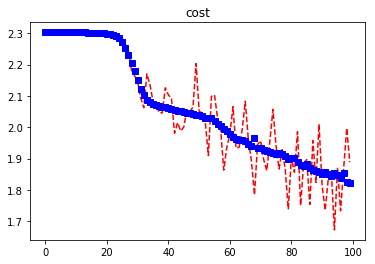

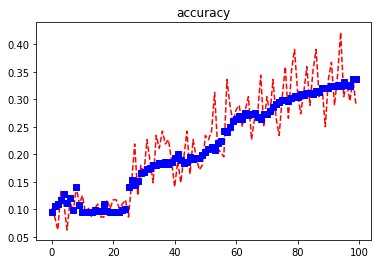

the accuracy on the validation set is:0.33


In [62]:
# plot the result here
plt.title("cost")
plt.plot(NN.train_cost,'r--', NN.validation_cost, 'bs')
plt.show()
plt.title("accuracy")
plt.plot(NN.train_accuracy,'r--', NN.validation_accuracy, 'bs')
plt.show()
y_predict_validation = NN.predict(X_validation)
accuracy = np.sum((y_predict_validation == y_validation) * 1) / len(y_validation)
print('the accuracy on the validation set is:' + str(accuracy))

In [2]:
# Helper functions, DO NOT modify this

def get_img_array(path):
    """
    Given path of image, returns it's numpy array
    """
    return scipy.misc.imread(path)

def get_files(folder):
    """
    Given path to folder, returns list of files in it
    """
    filenames = [file for file in glob.glob(folder+'*/*')]
    filenames.sort()
    return filenames

def get_label(filepath, label2id):
    """
    Files are assumed to be labeled as: /path/to/file/999_frog.png
    Returns label for a filepath
    """
    tokens = filepath.split('/')
    label = tokens[-1].split('_')[1][:-4]
    if label in label2id:
        return label2id[label]
    else:
        sys.exit("Invalid label: " + label)

In [3]:
# Functions to load data, DO NOT change these

def get_labels(folder, label2id):
    """
    Returns vector of labels extracted from filenames of all files in folder
    :param folder: path to data folder
    :param label2id: mapping of text labels to numeric ids. (Eg: automobile -> 0)
    """
    files = get_files(folder)
    y = []
    for f in files:
        y.append(get_label(f,label2id))
    return np.array(y)

def one_hot(y, num_classes=10):
    """
    Converts each label index in y to vector with one_hot encoding
    """
    y_one_hot = np.zeros((y.shape[0], num_classes))
    y_one_hot[y] = 1
    return y_one_hot.T

def get_label_mapping(label_file):
    """
    Returns mappings of label to index and index to label
    The input file has list of labels, each on a separate line.
    """
    with open(label_file, 'r') as f:
        id2label = f.readlines()
        id2label = [l.strip() for l in id2label]
    label2id = {}
    count = 0
    for label in id2label:
        label2id[label] = count
        count += 1
    return id2label, label2id

def get_images(folder):
    """
    returns numpy array of all samples in folder
    each column is a sample resized to 30x30 and flattened
    """
    files = get_files(folder)
    images = []
    count = 0
    
    for f in files:
        count += 1
        if count % 10000 == 0:
            print("Loaded {}/{}".format(count,len(files)))
        img_arr = get_img_array(f)
        img_arr = img_arr.flatten() / 255.0
        images.append(img_arr)
    X = np.column_stack(images)

    return X

def get_train_data(data_root_path):
    """
    Return X and y
    """
    train_data_path = data_root_path + 'train'
    id2label, label2id = get_label_mapping(data_root_path+'labels.txt')
    print(label2id)
    X = get_images(train_data_path)
    y = get_labels(train_data_path, label2id)
    return X, y

def save_predictions(filename, y):
    """
    Dumps y into .npy file
    """
    np.save(filename, y)

In [4]:
# Load the data
data_root_path = '/Users/zhengyixing/Documents/study/3nd_semester/DL/homework/cifar10-hw1/'
X_train, y_train = get_train_data(data_root_path) # this may take a few minutes
X_test = get_images(data_root_path + 'test')
print('Data loading done')
indexs = np.random.choice(50000, 5000, replace=False)
X_validation = X_train[:,indexs]
y_validation = y_train[indexs]
X_train = np.delete(X_train,indexs, axis = 1)
y_train = np.delete(y_train,indexs)

{'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
Loaded 10000/50000
Loaded 20000/50000
Loaded 30000/50000
Loaded 40000/50000
Loaded 50000/50000
Loaded 10000/10000
Data loading done


In [11]:
print(X_train.shape)
print(y_train.shape)
print(y_train)
print(len(y_train))
print(X_test.shape)
print(X_validation.shape)
# try train 
# layer_dimensions = [X_train.shape[0], 32, 10]  # including the input and output layers
# NN = NeuralNetwork(layer_dimensions)
# NN.train(X_train, y_train, iters=1000, alpha=0.0001, batch_size=100, print_every=100)

(3072, 45000)
(45000,)
[6 6 6 ..., 5 1 3]
45000
(3072, 10000)
(3072, 5000)


## Part 1

#### Simple fully-connected deep neural network

In [ ]:
layer_dimensions = [X_train.shape[0], ..., 10]  # including the input and output layers
NN = NeuralNetwork(layer_dimensions)
NN.train(X_train, y_train, iters=, alpha=, batch_size=, print_every=)

In [ ]:
y_predicted = NN.predict(X_test)
save_predictions('ans1-uni', y_predicted)

In [ ]:
# test if your numpy file has been saved correctly
loaded_y = np.load('ans1-uni.npy')
print(loaded_y.shape)
loaded_y[:10]

## Part 2: Regularizing the neural network
#### Add dropout and L2 regularization

In [ ]:
NN2 = NeuralNetwork(layer_dimensions, drop_prob=0, reg_lambda=0)
NN2.train(X_train, y_train, iters=1000, alpha=0.00001, batch_size=1000, print_every=10)

In [ ]:
y_predicted2 = NN2.predict(X)
save_predictions(y_predicted, 'ans2-uni')